# Data Investigation - Trip Data

### Import Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
sns.set()

In [477]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

# Load Trip Data

In [3]:
print('[%s] Loading Trip Data Data...' % datetime.datetime.now().time())
try:
    trip_data = pd.DataFrame()
    trip_data_file = '../clean_data/trip_data_cleaned_master.csv'

    # Chunk Settings
    chunks = []
    chunk_counter = 1
    chunksize = 10000
    num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

    # import file in chunks
    for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):

        # append chunk to chunks list
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
            print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
        chunk_counter += 1
    
    trip_data = pd.concat(chunks)

    print('[%s] Complete!' % datetime.datetime.now().time())

except:
    print('oops... something went wrong importing the data :(')
    


[16:48:29.432090] Loading Trip Data Data...
		[16:48:30.195583] finished chunk 1 of 96
		[16:48:31.065626] finished chunk 10 of 96
		[16:48:31.995652] finished chunk 20 of 96
		[16:48:33.073859] finished chunk 30 of 96
		[16:48:34.091767] finished chunk 40 of 96
		[16:48:34.974253] finished chunk 50 of 96
		[16:48:35.926011] finished chunk 60 of 96
		[16:48:36.966955] finished chunk 70 of 96
		[16:48:37.925153] finished chunk 80 of 96
		[16:48:38.854516] finished chunk 90 of 96
		[16:48:39.358431] finished chunk 96 of 96
[16:48:39.886792] Complete!


In [4]:
trip_data.head(5)

trip_id  duration          start_date        start_station_name  \
0     4069       174 2013-08-29 09:08:00         2nd at South Park   
1     4073      1067 2013-08-29 09:24:00  South Van Ness at Market   
2     4074      1131 2013-08-29 09:24:00  South Van Ness at Market   
3     4075      1117 2013-08-29 09:24:00  South Van Ness at Market   
4     4076      1118 2013-08-29 09:25:00  South Van Ness at Market   

   start_terminal            end_date  \
0              64 2013-08-29 09:11:00   
1              66 2013-08-29 09:42:00   
2              66 2013-08-29 09:43:00   
3              66 2013-08-29 09:43:00   
4              66 2013-08-29 09:43:00   

                          end_station_name  end_terminal  bike_id   user_type  \
0                        2nd at South Park            64      288  Subscriber   
1  San Francisco Caltrain 2 (330 Townsend)            69      321  Subscriber   
2  San Francisco Caltrain 2 (330 Townsend)            69      317  Subscriber   
3  San Francisco Caltrain 2 (330 Townsend)            69      316  Subscriber   
4  San Francisco Caltrain 2 (330 Townsend)            69      322  Subscriber   

    ...    end_zip  max_temp mean_temp min_temp  max_wind  mean_wind  \
0   ...      94107      74.0      68.0     61.0      23.0       11.0   
1   ...      94107      74.0      68.0     61.0      23.0       11.0   
2   ...      94107      74.0      68.0     61.0      23.0       11.0   
3   ...      94107      74.0      68.0     61.0      23.0       11.0   
4   ...      94107      74.0      68.0     61.0      23.0       11.0   

   max_gust  precipitation  cloud_cover  events  
0      28.0            0.0          4.0     NaN  
1      28.0            0.0          4.0     NaN  
2      28.0            0.0          4.0     NaN  
3      28.0            0.0          4.0     NaN  
4      28.0            0.0          4.0     NaN  

[5 rows x 25 columns]

In [5]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955557 entries, 0 to 955556
Data columns (total 25 columns):
trip_id               955557 non-null int64
duration              955557 non-null int64
start_date            955557 non-null datetime64[ns]
start_station_name    955557 non-null object
start_terminal        955557 non-null int64
end_date              955557 non-null datetime64[ns]
end_station_name      955557 non-null object
end_terminal          955557 non-null int64
bike_id               955557 non-null int64
user_type             955557 non-null object
user_zip              955557 non-null int64
duration_minutes      955557 non-null float64
start_area            955557 non-null object
end_area              955557 non-null object
start_zip             955557 non-null int64
end_zip               955557 non-null int64
max_temp              955507 non-null float64
mean_temp             955507 non-null float64
min_temp              955507 non-null float64
max_wind              

## Utility Functions

In [6]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

zip_lookup = {
    94107 : 'San Francisco',
    94063 : 'Redwood City',
    94301 : 'Palo Alto',
    94041 : 'Mountain View',
    95113 : 'San Jose'
}

# Goal 1 - Identify Key User Groups

- All Users
    - Customers
    - Subscribers

In [7]:
# Separate Customer Data and SUbscriber Data
customer_trip_data = trip_data[trip_data.user_type == 'Customer'].copy()
subscriber_trip_data = trip_data[trip_data.user_type == 'Subscriber'].copy()

print('Desription\t\t\tTrip Count\tShare')
print('Total Trips Records\t\t%s' % len(trip_data))
print('Total Subscriber Trip Records\t%s\t\t%0.2f' % (len(subscriber_trip_data), len(subscriber_trip_data)/len(trip_data)*100.))
print('Total Customer Trip Records\t%s\t\t%0.2f' % (len(customer_trip_data), len(customer_trip_data)/len(trip_data)*100.))


Desription			Trip Count	Share
Total Trips Records		955557
Total Subscriber Trip Records	844570		88.39
Total Customer Trip Records	110987		11.61


# Goal 2 - Identify Usage Patterns for User Groups

> We have two key user groups, what are the similarities and difference of their ussage?
- Subscribers
    - Hour of the Day - Two Distinct peaks, during commute hours
    - Day of the Week - Weekday Trips out number Weekend Trips nearly 5 to 1
    - Month of the Year - Rougly 35% dip in November into December, remainder of year steady
- Commuters
    - Hour of the Day - Nice Even lump during daylight hours 8am-7pm
    - Day of the Week - Weekends are busiest, but not by much
    - Month of the Year - Peak in September, busiest in Summer months
    
> How do these groups compare by volume?
- Subscribers make up 88.39% of all Trips
    - 78% of all Subscriber trips are during commuting hours


### Distribution by User Type

In [480]:
x_ticks = sorted(pd.unique(trip_data.start_date.dt.hour))
subscriber_y = trip_data[trip_data.user_type == 'Subscriber'].groupby(trip_data.start_date.dt.hour)['trip_id'].count()
customer_y   = trip_data[trip_data.user_type == 'Customer'].groupby(trip_data.start_date.dt.hour)['trip_id'].count()
sub_norm  = subscriber_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))
cust_norm =   customer_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))

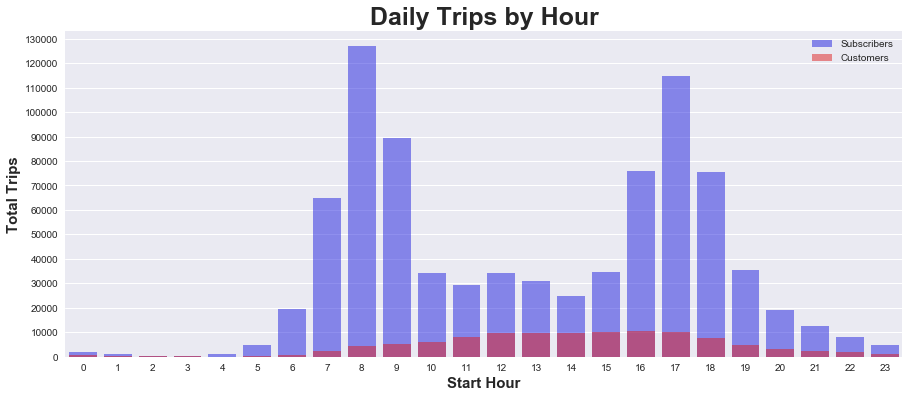

In [481]:
plt.subplots(figsize=(15,6))
ax = sns.barplot(x = x_ticks , y = subscriber_y, color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = customer_y, color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Daily Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)


y_step = 10000
y_max = int(math.ceil(subscriber_y.max() / y_step) * y_step) + y_step
y_ticks = range(0, subscriber_y.max()+y_step, y_step)
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_yticks(y_ticks)
ax.legend(['Subscribers', 'Customers'], loc=1)


fig = ax.get_figure()
save_file = '../Documents/charts/00_%s' % ('Distribution of Trips by Hour'.replace(' ', '_'))
fig.savefig(save_file)

plt.legend()
plt.show()

In [457]:
y_max = trip_data[trip_data.user_type == 'Subscriber'].groupby(trip_data.start_date.dt.hour)['trip_id'].count().max()
y_max = int(math.ceil(y_max / 100000) * 100000)
y_step = int(y_max / 10)
y_ticks = range(0, y_max, y_step)

In [485]:
def plot_trip_distributions(user_type = 'Subscriber', color='b', h_step=10000, d_step=25000, m_step=10000):
    
    def draw_plot(user_type, x, y, title, x_label, y_label, x_tick_labels, y_step, draw_lines = []):

        plt.subplots(figsize=(15,6))
        ax = sns.barplot(x = x, 
                         y = y, 
                         color = color, 
                         alpha = 0.5, 
                         label=user_type)

        ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
        

        ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(x_tick_labels)

        y_max = int(math.ceil(y.max() / y_step) * y_step) + y_step
        y_ticks = range(0, y.max()+y_step, y_step)

        ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
        ax.set_yticks(y_ticks)

        if len(draw_lines) > 0 and user_type == 'Subscriber':
            for xc in draw_lines:
                ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
        else:
            for xc in draw_lines[2:]:
                ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
            
        fig = ax.get_figure()
        save_file = '../Documents/charts/01_%s_%s' % (user_type, title.replace(' ', '_').replace('_-_', '_').replace('__', '_'))
        fig.savefig(save_file)

        plt.legend()
        plt.show()
     
    # Draw Trips by Hour of Day
    
    # Only Weekdays
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(trip_data.start_date.dt.hour)), 
              y = trip_data[(trip_data.user_type == user_type) & (trip_data.start_date.dt.dayofweek <= 4)].groupby(trip_data.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour - Weekdays Only' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = h_step,
              draw_lines=[6.5, 10.5, 15.5, 19.5])
    
    
    # Only Weekends
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(trip_data.start_date.dt.hour)), 
              y = trip_data[(trip_data.user_type == user_type) & (trip_data.start_date.dt.dayofweek > 4)].groupby(trip_data.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour - Weekends Only' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = 1000)
    
    # all days
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(trip_data.start_date.dt.hour)), 
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = h_step)

    
    
    # Draw Trips by Day of Week
    weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU',
                  4:'FRI', 5:'SAT', 6:'SUN'}
    
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(trip_data.start_date.dt.dayofweek)), 
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.dayofweek)['trip_id'].count(), 
              title = ' %s Weekly Trips by Day' % user_type.title(), 
              x_label = 'Day of Week', 
              y_label = 'Trip Count', 
              x_tick_labels = [weekday_map[d] for d in sorted(pd.unique(trip_data.start_date.dt.dayofweek))],
              y_step = d_step)

    # Draw Trips by Month of Year
    month_map = {1:'JAN', 2:'FEB', 3:'MAR', 4:'APR', 
                 5:'MAY', 6:'JUN', 7:'JUL', 8:'AUG', 
                 9:'SEP', 10:'OCT', 11:'NOV', 12:'DEC'}

    month_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    draw_plot(user_type=user_type,
              x = month_ticks,
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.month)['trip_id'].count(), 
              title = ' %s Monthly Trips by Year' % user_type.title(), 
              x_label = 'Month', 
              y_label = 'Trip Count', 
              x_tick_labels = [month_map[d] for d in sorted(pd.unique(trip_data.start_date.dt.month))],
              y_step = m_step)

### Subscriber Distribution

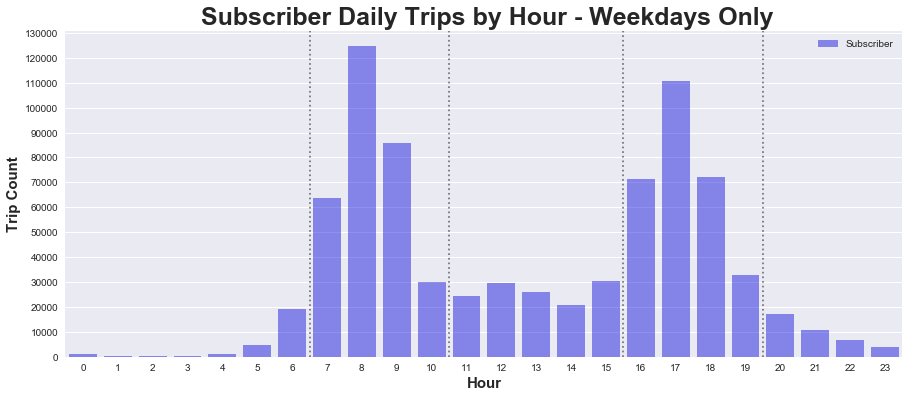

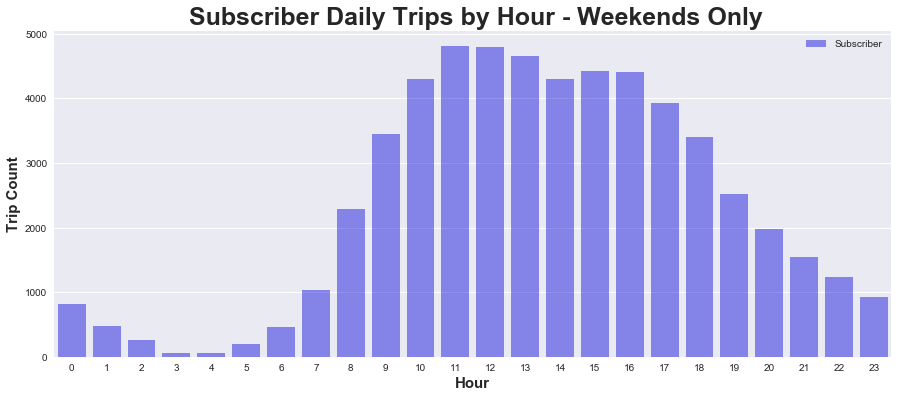

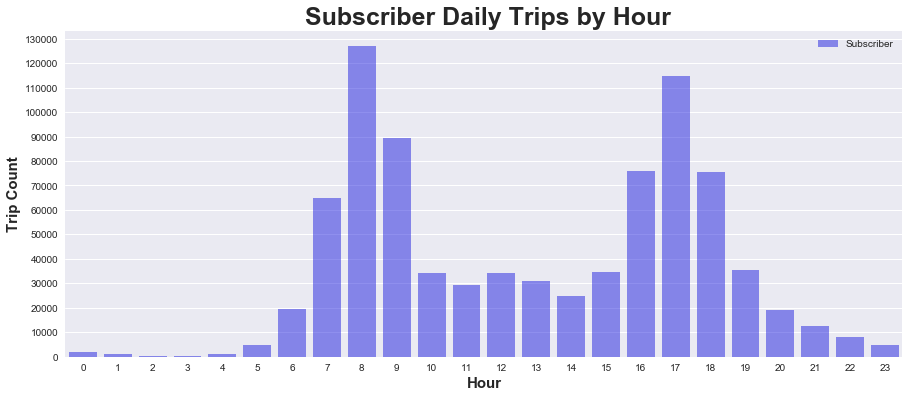

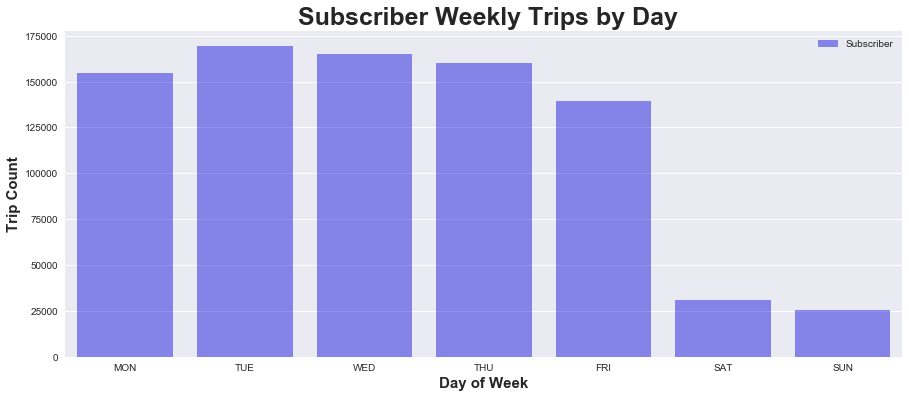

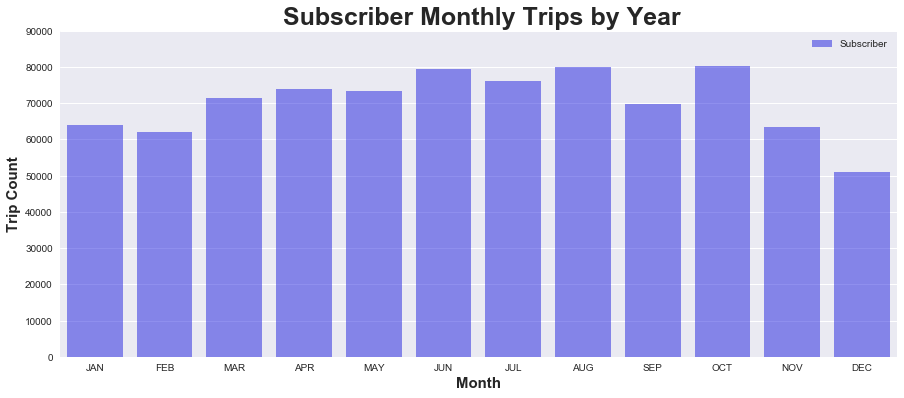

In [486]:
plot_trip_distributions(user_type = 'Subscriber', color='b', h_step=10000, d_step=25000, m_step=10000)

### Customer Distribution

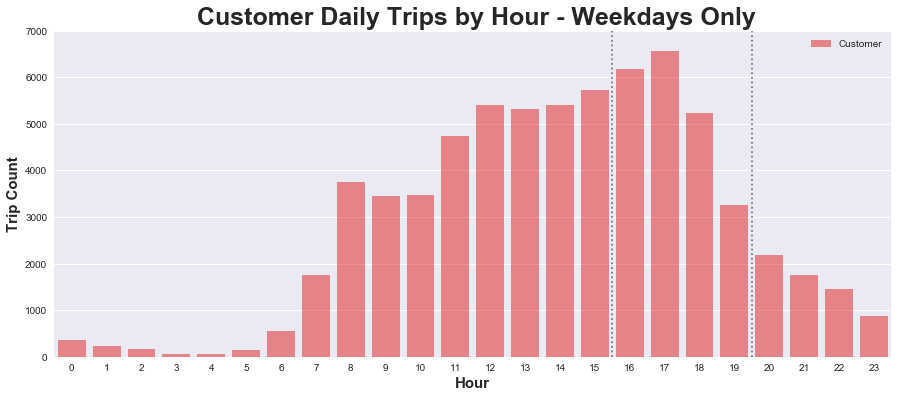

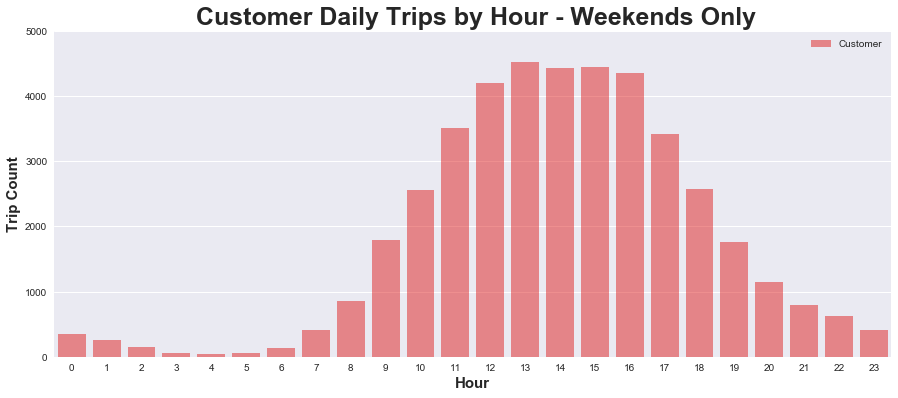

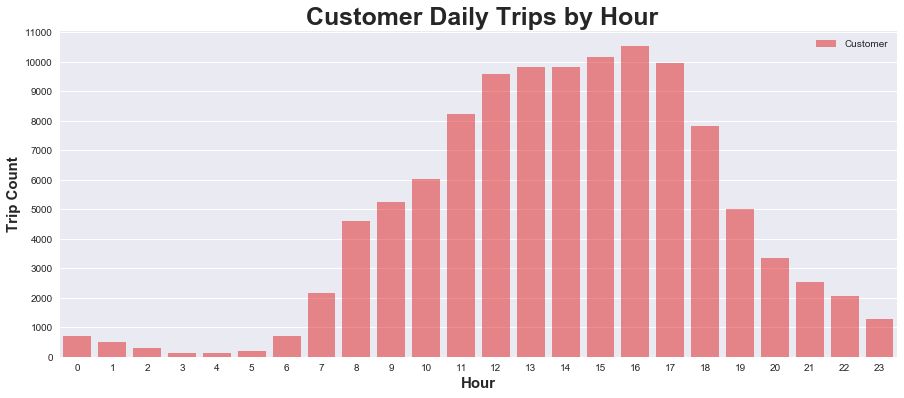

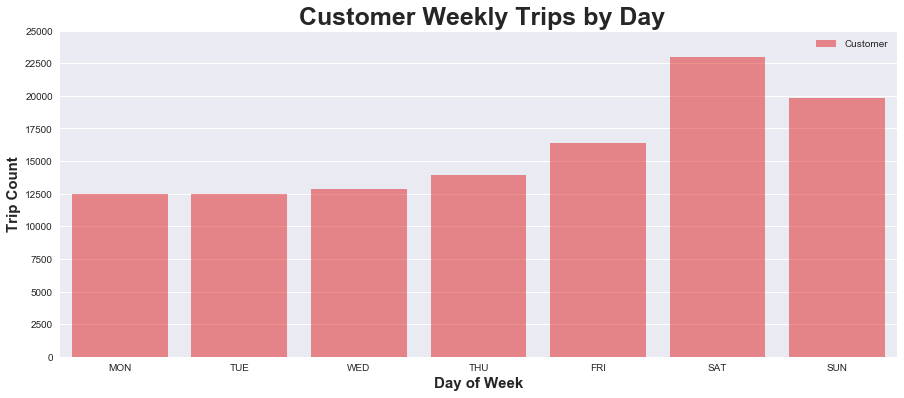

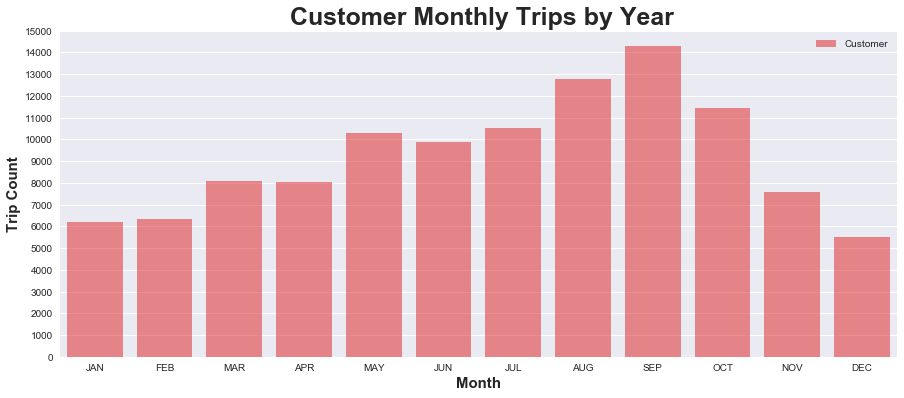

In [487]:
plot_trip_distributions(user_type = 'Customer', color='r', h_step=1000, d_step=2500, m_step=1000)

# Goal 3 - Identify Trends in Service Areas

> The Bay Area Bike Share Program serves 5 Metro Areas
- San Francisco
    - Identify Popular Terminals
    - Customers vs Subscribers
    
- San Jose
    - Identify Popular Terminals
    - Customers vs Subscribers

- Mountain View
    - Identify Popular Terminals
    - Customers vs Subscribers

- Palo Alto
    - Identify Popular Terminals
    - Customers vs Subscribers

- Redwood City
    - Identify Popular Terminals
    - Customers vs Subscribers

In [461]:
def plot_trip_heatmap(df, z=1, user_type='Subscriber', station_by='start'):
    
    if user_type == 'Customer':
        cmap = sns.color_palette("OrRd", 10)
    elif user_type == 'Subscriber':
        cmap = sns.color_palette("PuBu", 10)
    else:
        cmap = sns.color_palette("YlGn", 10)
    
    if z < 5:
        data = df.copy()
    else:
        data = df[df.start_zip == z].copy()
        print('Total Trips in %s\t%s\t%0.2f' % (zip_lookup[z], len(data), (len(data)/len(df)) * 100.))

    if station_by == 'start':
        grid_set = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
        
    elif station_by == 'end':
        grid_set = data.groupby(['end_terminal', 'start_terminal'])['bike_id'].count().unstack()
        
    elif station_by == 'both':
        grid_set_A = data.groupby(['end_terminal', 'start_terminal'])['bike_id'].count().unstack()
        grid_set_B = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
        
        grid_set = grid_set_A + grid_set_B
        station_by = 'all'
        
        
    norm_grid = grid_set/grid_set.max()
    norm_grid_set = grid_set/grid_set.max()

    plot_size=21

    fig1 = plt.subplots(figsize=(plot_size*1.5,plot_size))

    ax1 = sns.heatmap(grid_set, linewidths=.5, square=True, cbar=True, cmap=cmap, vmin=0, vmax=grid_set.max().max())
    sns.despine()
    if z < 5:
        title1 = '%s - %s Terminal Usage' % (user_type, station_by.title())
        file1  = '%s - %s Terminal Usage Heatmap' % (user_type, station_by.title())
    else:
        title1 = '%s - %s %s Terminal Usage' % (user_type, zip_lookup[z], station_by.title())
        file1  = '%s - %s %s Terminal Usage Heatmap' % (user_type, zip_lookup[z], station_by.title())
    title1 = title1.replace(' All ', ' ')
        
    ax1.set_title(title1, size=TITLE_FONT_SIZE*1.5, weight='bold')
    ax1.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax1.set_xticklabels(grid_set.columns, size=LABEL_FONT_SIZE*0.95)
    ax1.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax1.set_yticklabels(grid_set.index, size=LABEL_FONT_SIZE*0.95, rotation=0)

    try:
        if zip_lookup[z] != 'San Francisco' or zip_lookup[z] != 'San Jose':
            ax1.set_title(title1, size=TITLE_FONT_SIZE*1.5*1.1, weight='bold')
            ax1.set_xticklabels(norm_grid_start.columns, size=LABEL_FONT_SIZE*0.95*1.5)
            ax1.set_yticklabels(norm_grid_start.index, size=LABEL_FONT_SIZE*0.95*1.5, rotation=0)    
    except:
        pass
        
    plt.show()

    
    fig2 = plt.subplots(figsize=(plot_size*1.5,plot_size))

    ax2 = sns.heatmap(norm_grid_set, linewidths=.5, square=True, cbar=True, cmap=cmap, vmin=0, vmax=1)
    sns.despine()
    if z < 5:
        title2 = '%s - %s Terminal Usage' % (user_type, station_by.title())
        file2  = '%s - %s Terminal Usage Heatmap' % (user_type, station_by.title())
    else:
        title2 = '%s - %s %s Terminal Usage' % (user_type, zip_lookup[z], station_by.title())
        file2  = '%s - %s %s Terminal Usage Heatmap' % (user_type, zip_lookup[z], station_by.title())
    title2 = title2.replace(' All ', ' ')

    ax2.set_title(title2, size=TITLE_FONT_SIZE*1.5, weight='bold')
    ax2.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95*2.5, weight='bold')
    ax2.set_xticklabels(norm_grid_set.columns, size=LABEL_FONT_SIZE*0.95)
    ax2.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95*2.5, weight='bold')
    ax2.set_yticklabels(norm_grid_set.index, size=LABEL_FONT_SIZE*0.95, rotation=0)
    
    try:
        if zip_lookup[z] != 'San Francisco' or zip_lookup[z] != 'San Jose':
            ax2.set_title(title2, size=TITLE_FONT_SIZE*1.5*1.1, weight='bold')
            ax2.set_xticklabels(norm_grid_set.columns, size=LABEL_FONT_SIZE*0.95*1.5)
            ax2.set_yticklabels(norm_grid_set.index, size=LABEL_FONT_SIZE*0.95*1.5, rotation=0)    
    except:
        pass
        
    fig2 = ax2.get_figure()
    save_file2 = '../Documents/charts/02_%s' % (file2.replace(' ', '_').replace('_-_', '_'))
    fig2.savefig(save_file2)
    plt.show()

In [462]:
def heatmap_regonalized_trips(df, user_type='Subscriber'):
    
    terminal_usage = df[df.user_type == user_type].copy()

    # select only trips that start and end in same zip code
    regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip == terminal_usage.end_zip].copy()
    non_regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip != terminal_usage.end_zip].copy()

    print('Regional Terminal Usage\t\t', len(regonalized_terminal_usage))
    print('Non Regional Terminal Usage\t    %s\t\t%0.2f' % (len(non_regonalized_terminal_usage), (len(non_regonalized_terminal_usage)/ len(terminal_usage) * 100)))
    print('-' * 80)

    for z in sorted(pd.unique(df.start_zip)):
        plot_trip_heatmap(regonalized_terminal_usage, z=z, user_type=user_type, station_by='start')
        plot_trip_heatmap(regonalized_terminal_usage, z=z, user_type=user_type, station_by='end')
        plot_trip_heatmap(regonalized_terminal_usage, z=z, user_type=user_type, station_by='both')

        
        
def heatmap_usertype_trips(df, user_type='Subscriber'):
    
    terminal_usage = df[df.user_type == user_type].copy()
        
    # select only trips that start and end in same zip code
    regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip == terminal_usage.end_zip].copy()
    non_regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip != terminal_usage.end_zip].copy()

    print('Regional Terminal Usage\t\t', len(regonalized_terminal_usage))
    print('Non Regional Terminal Usage\t    %s\t\t%0.2f' % (len(non_regonalized_terminal_usage), (len(non_regonalized_terminal_usage)/ len(terminal_usage) * 100)))
    
    plot_trip_heatmap(regonalized_terminal_usage, z=1, user_type=user_type, station_by='start')
    plot_trip_heatmap(regonalized_terminal_usage, z=1, user_type=user_type, station_by='end')
    plot_trip_heatmap(regonalized_terminal_usage, z=1, user_type=user_type, station_by='both')

    

### Subscriber Terminal Usage

Regional Terminal Usage		 843880
Non Regional Terminal Usage	    690		0.08


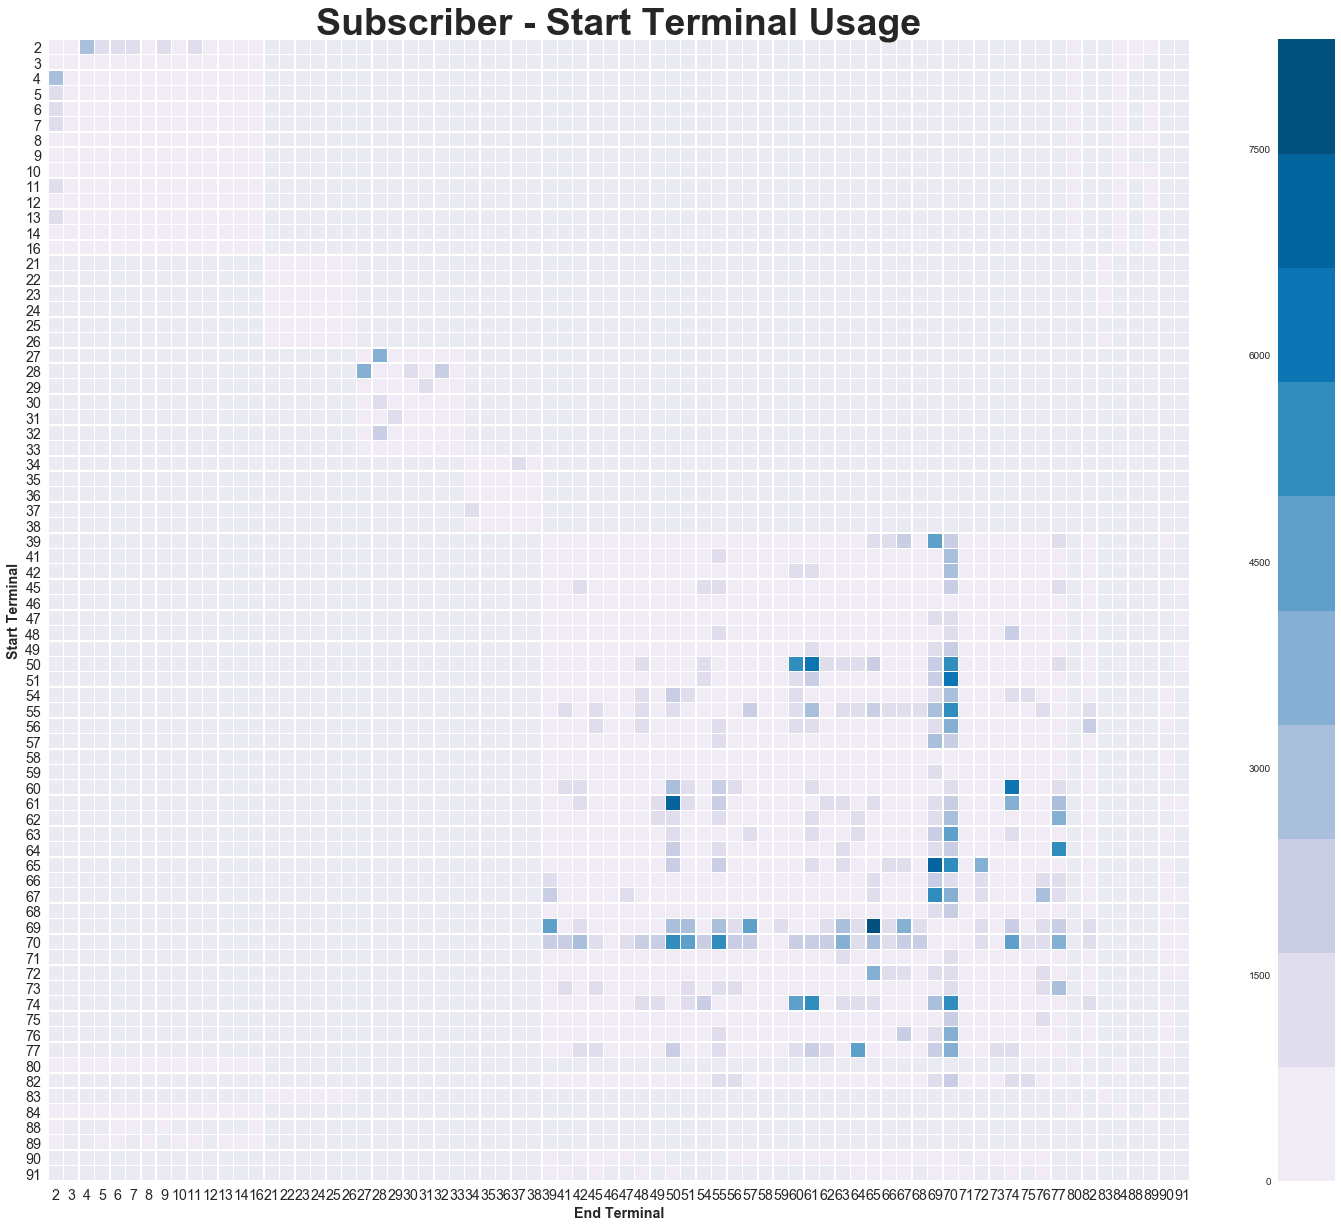

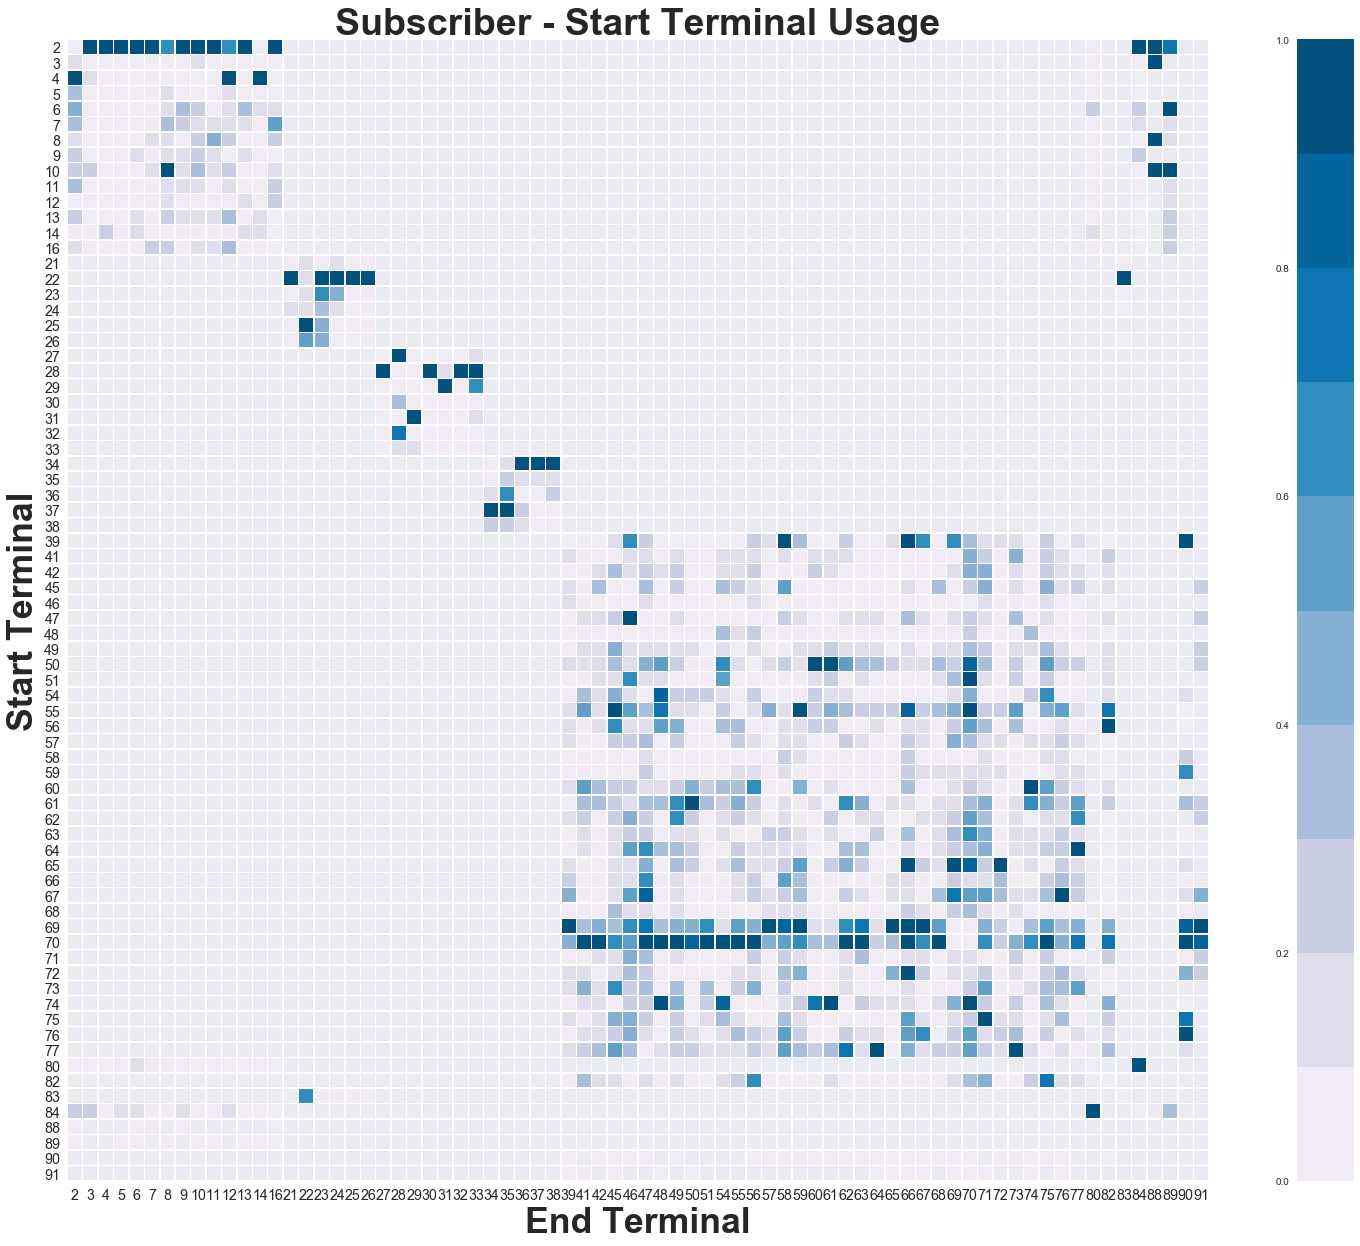

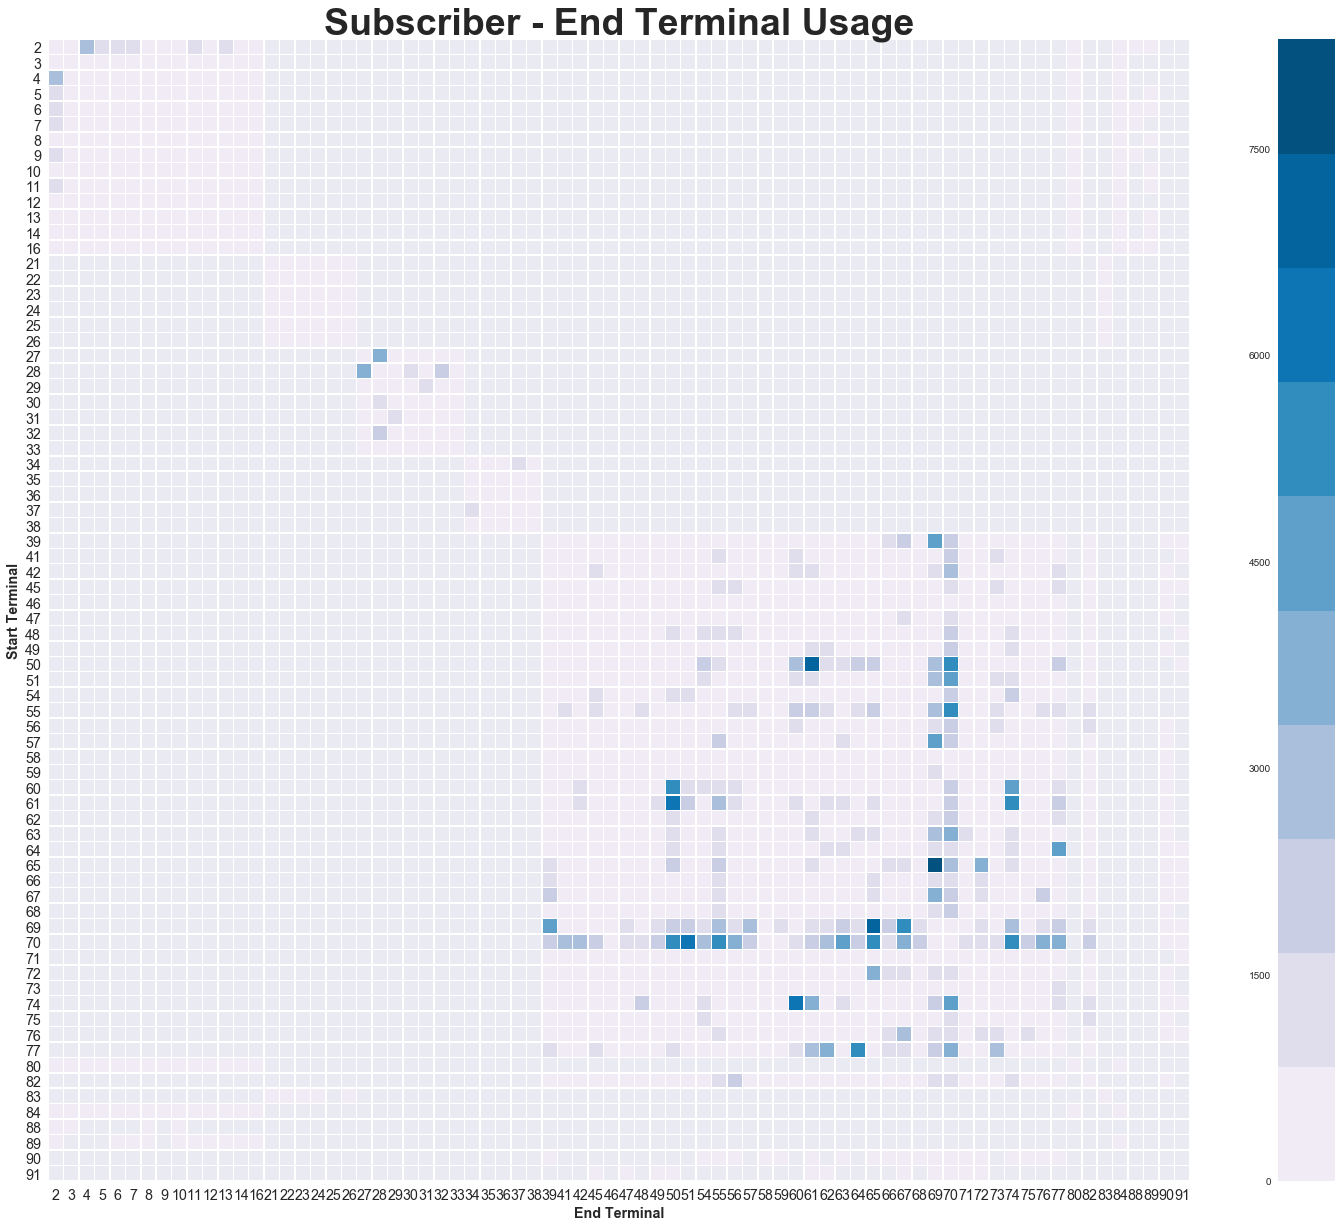

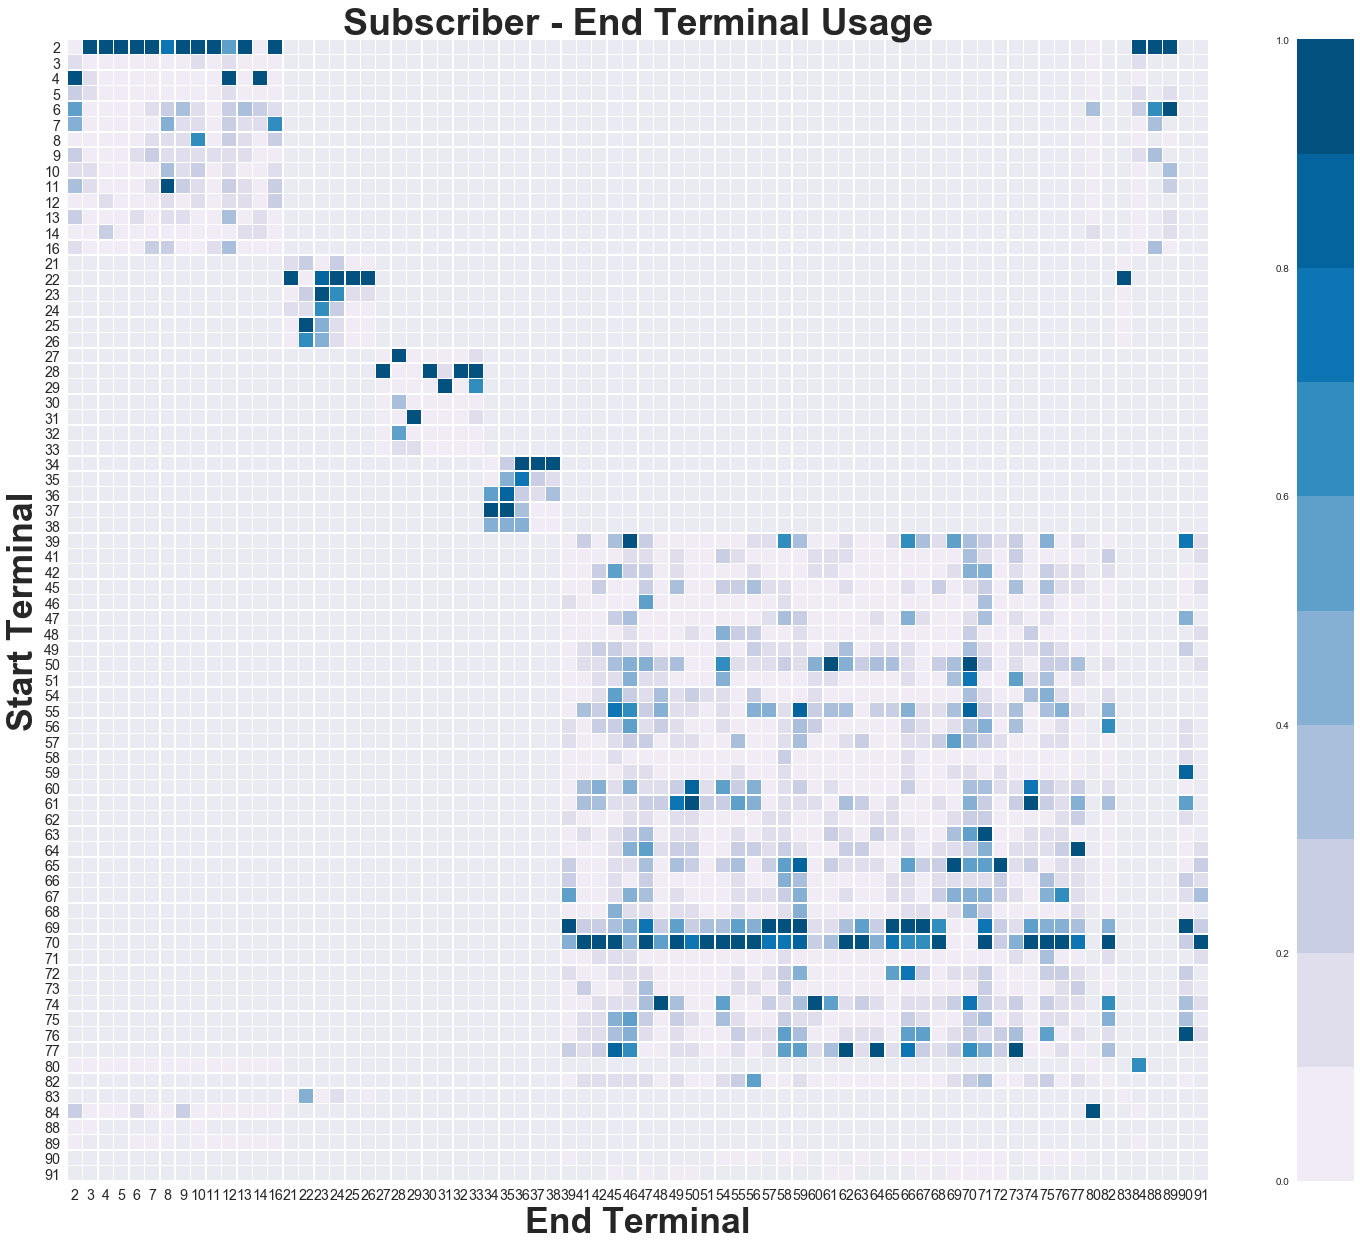

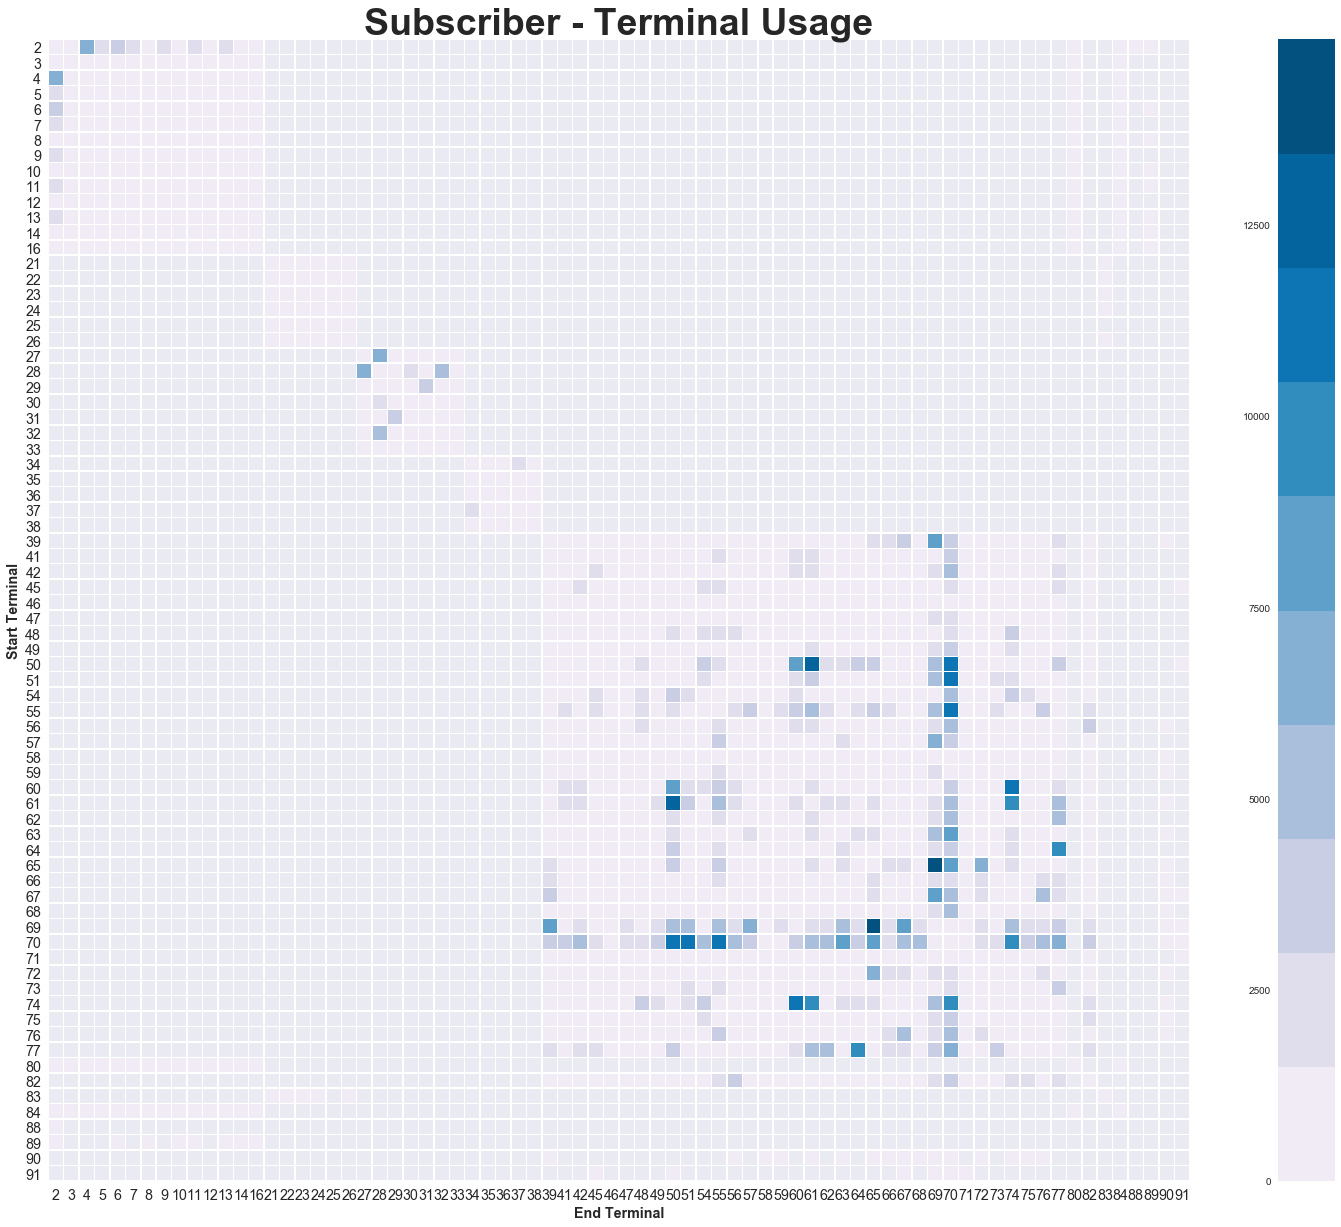

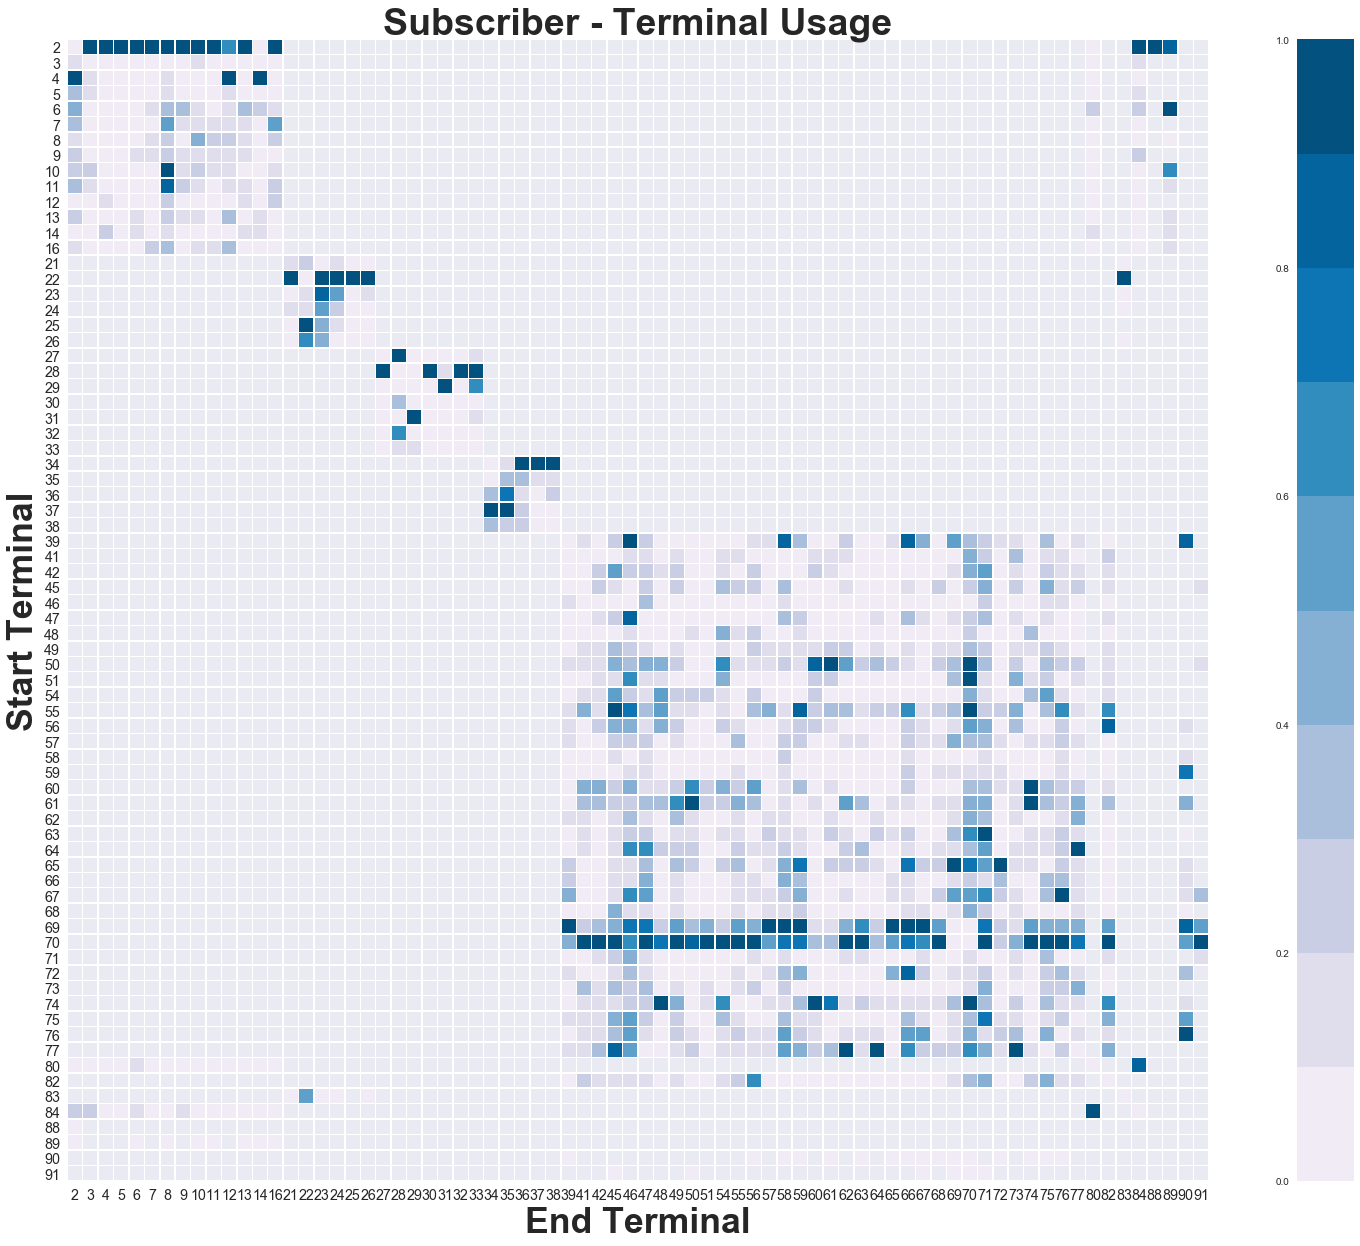

In [463]:
heatmap_usertype_trips(trip_data, user_type='Subscriber')

### Customer Terminal Usage

Regional Terminal Usage		 110524
Non Regional Terminal Usage	    463		0.42


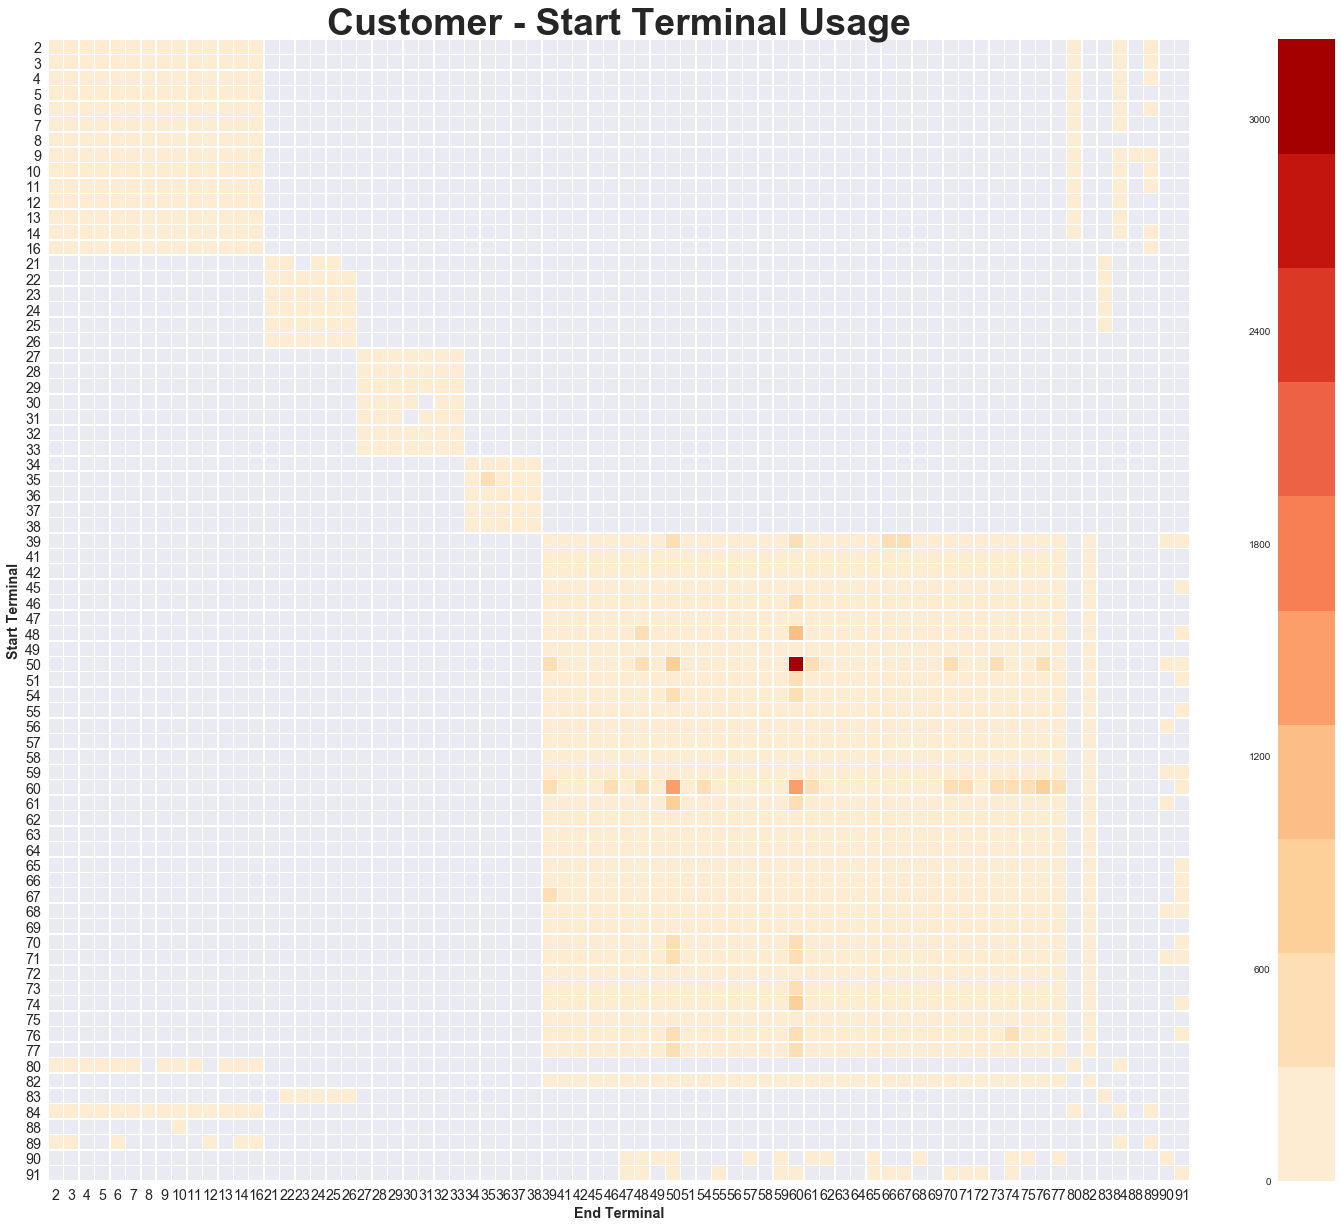

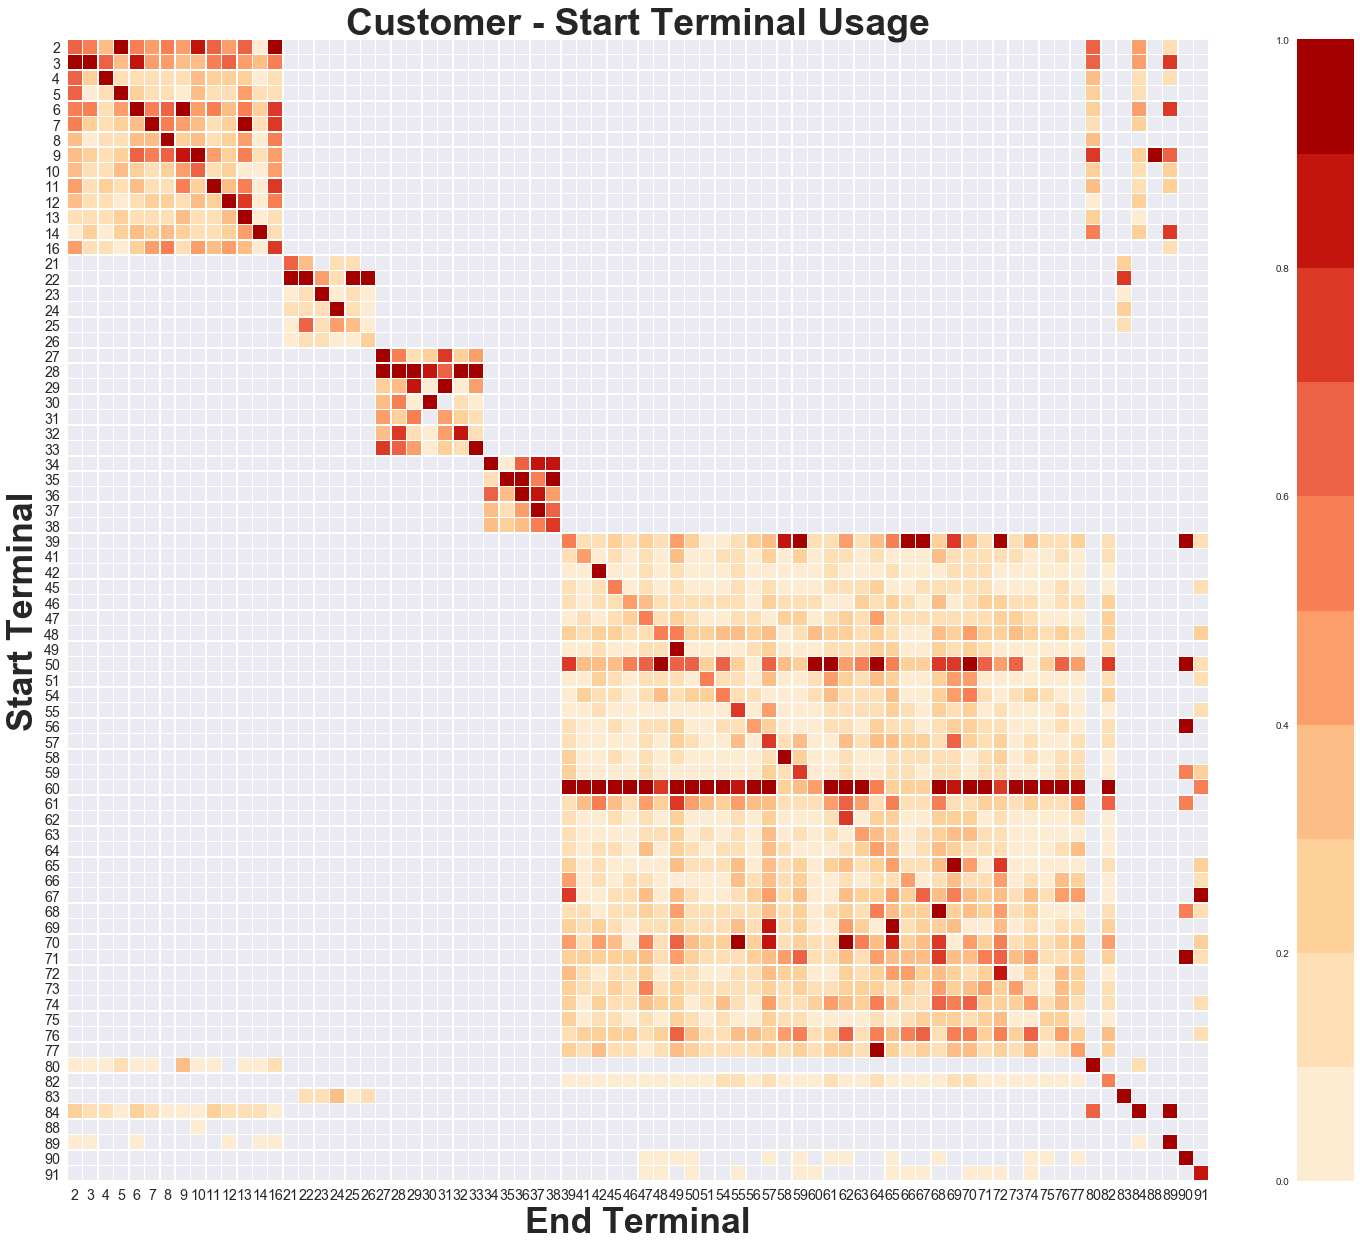

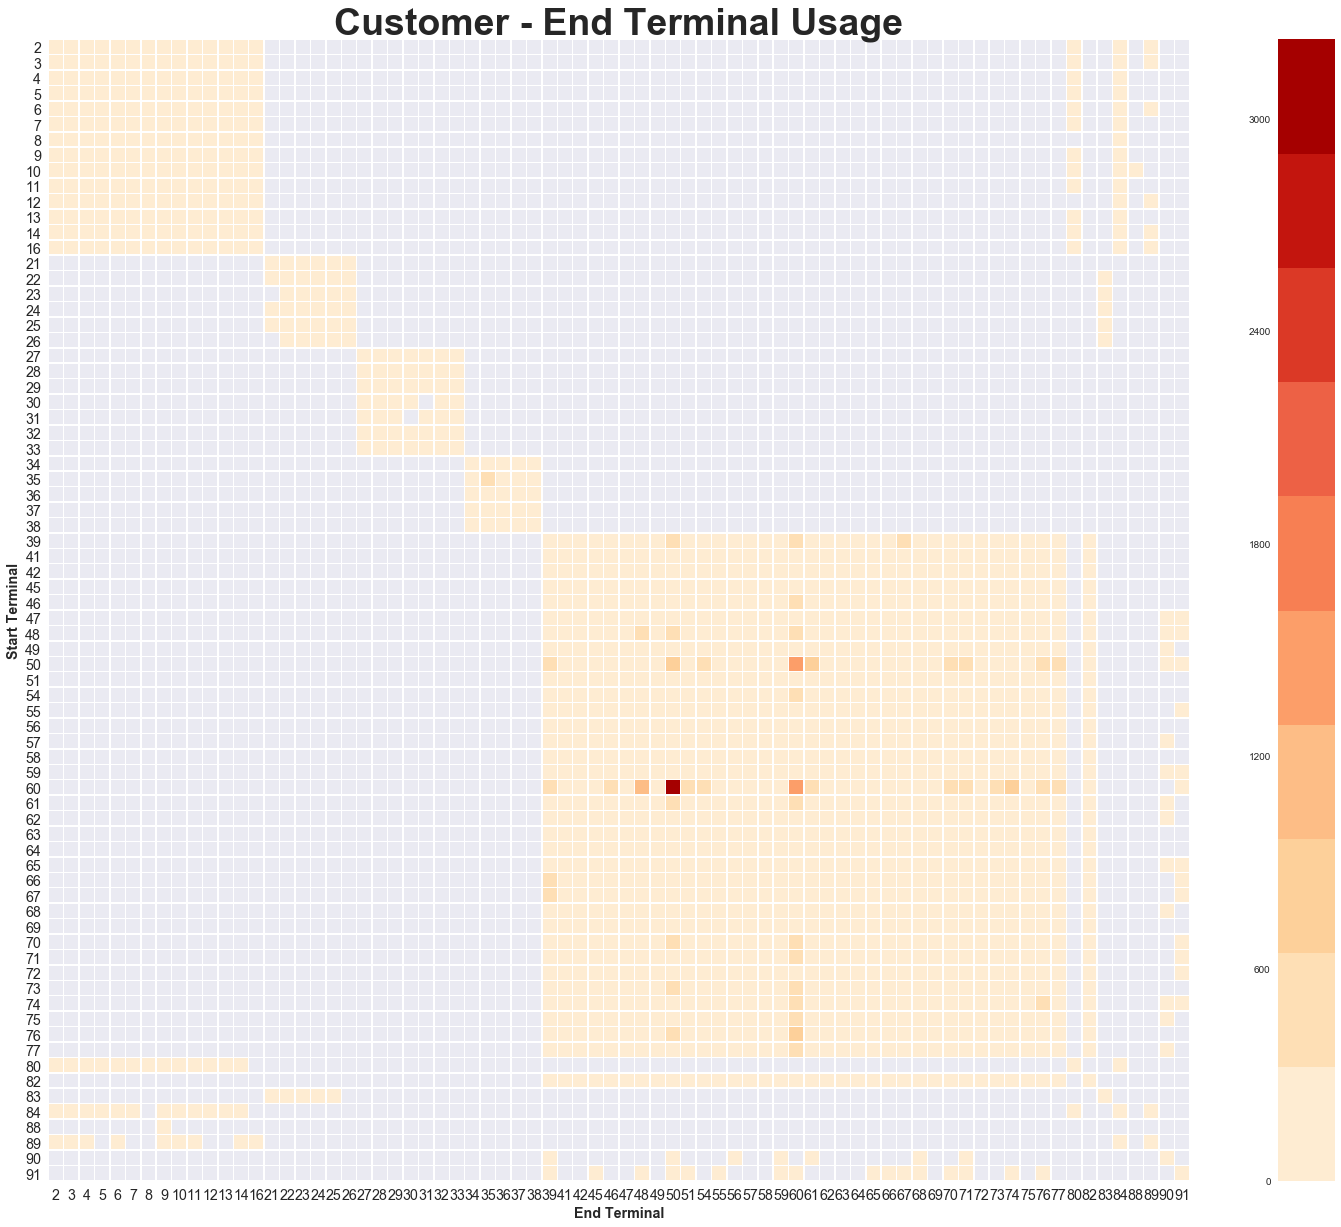

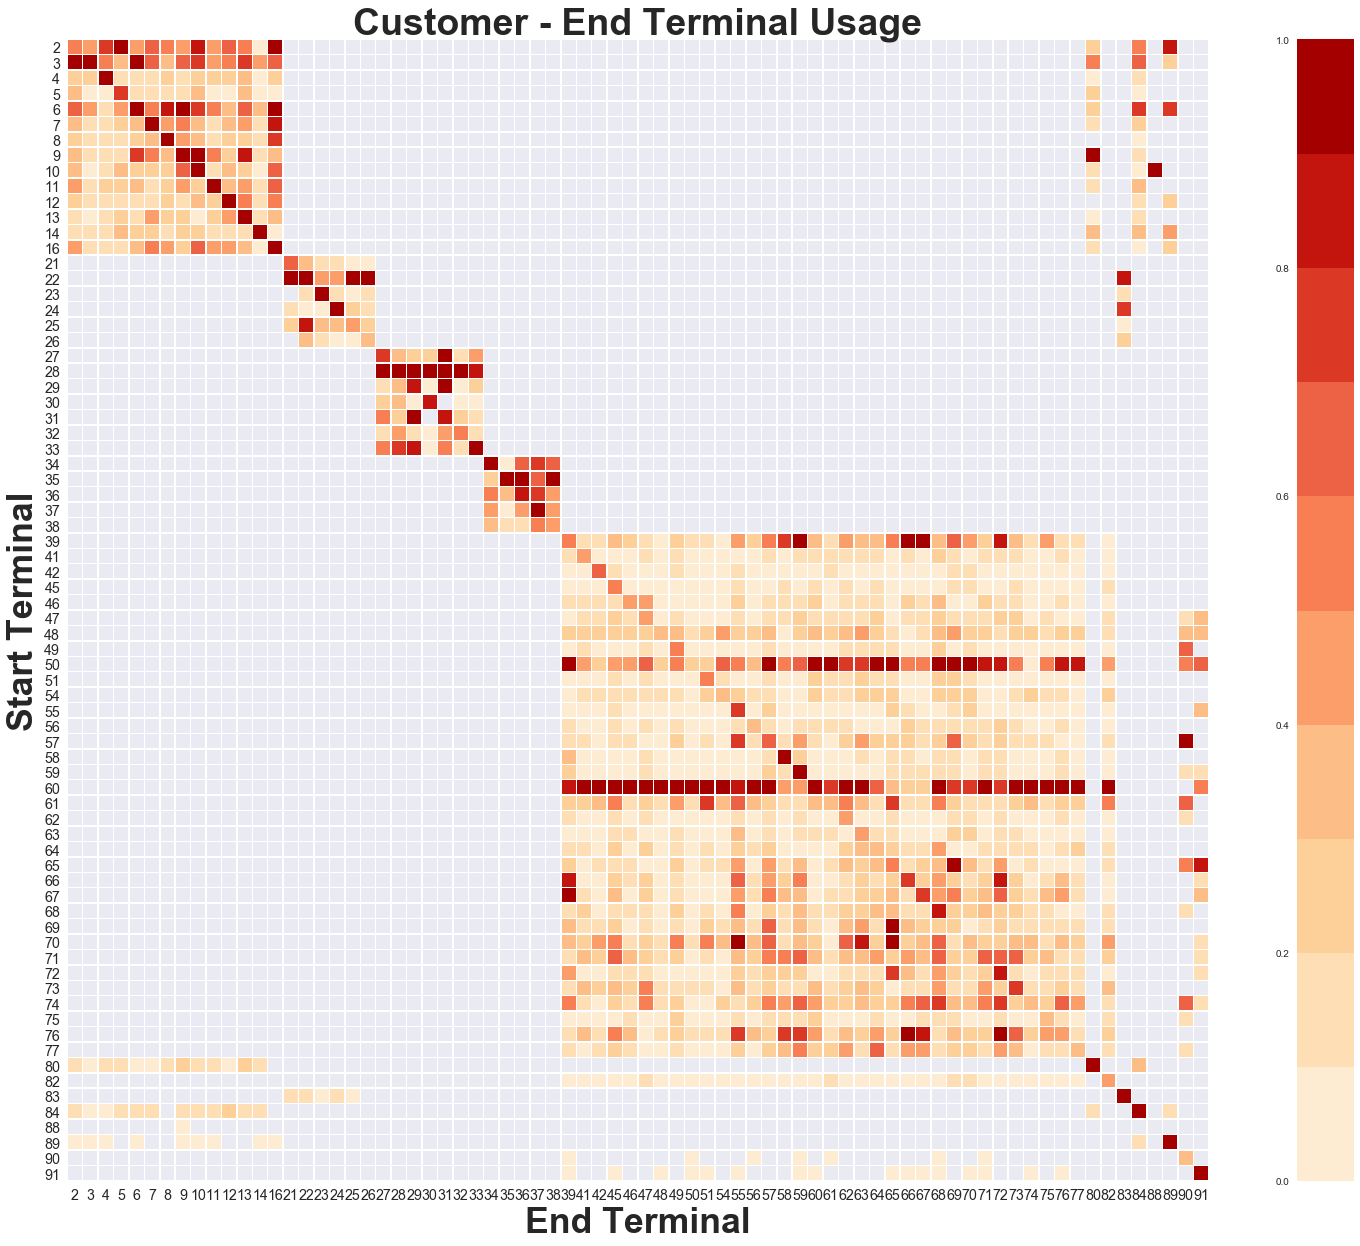

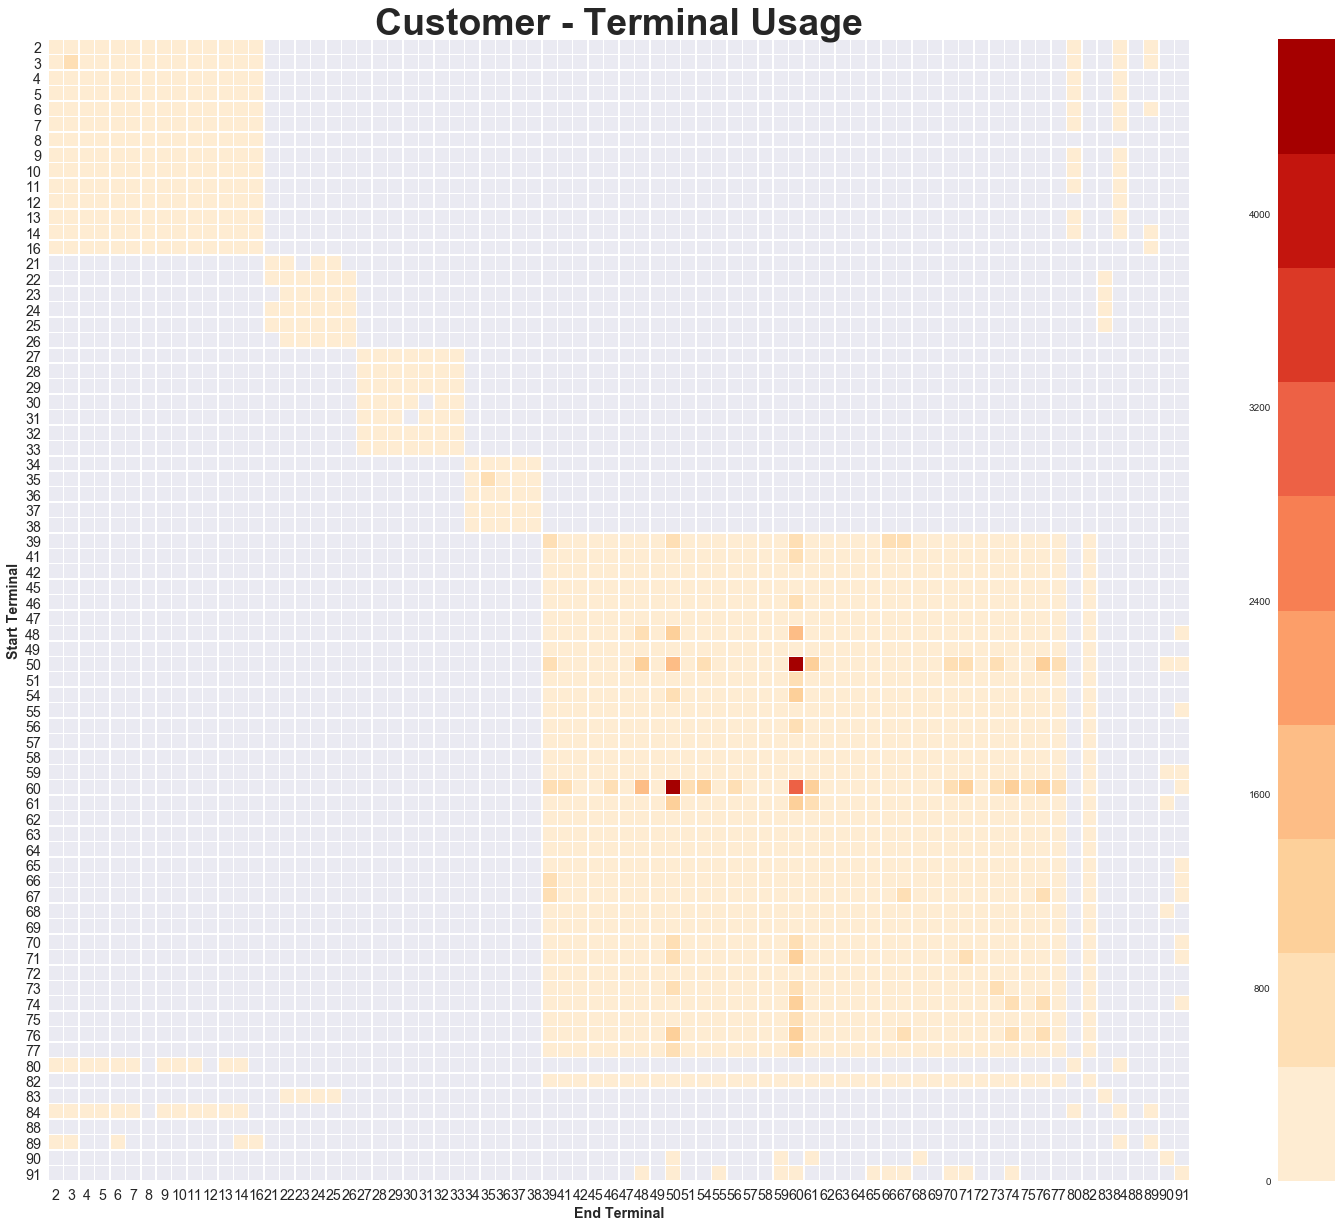

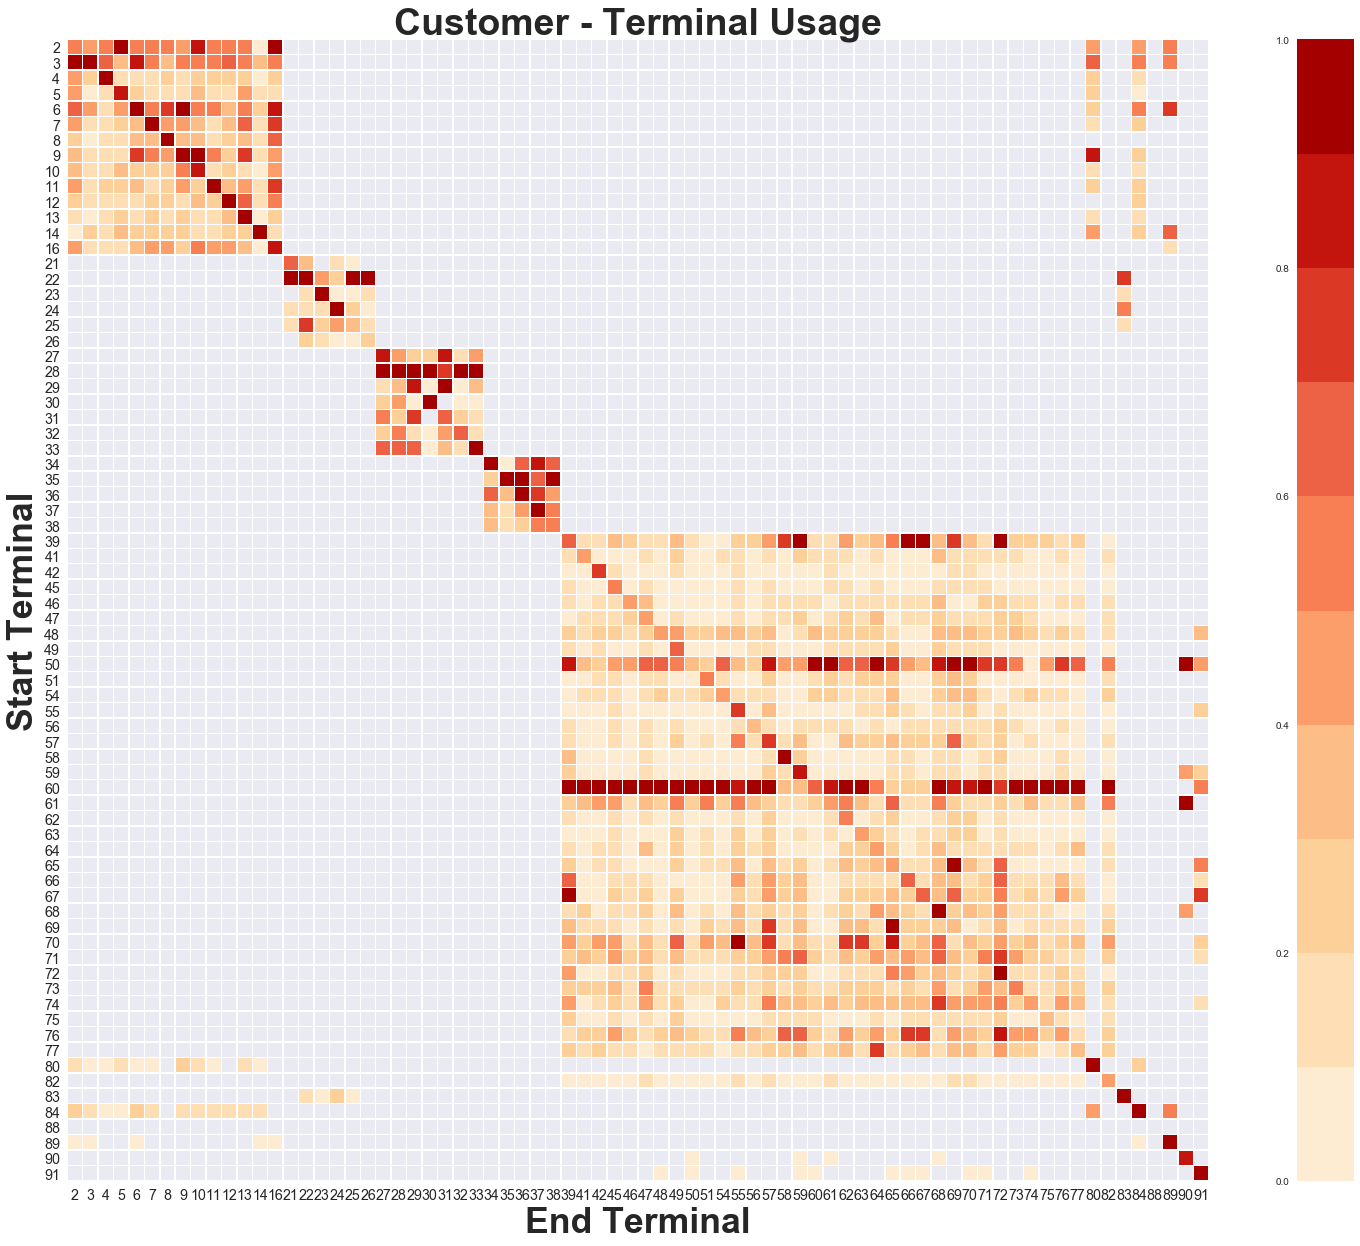

In [464]:
heatmap_usertype_trips(trip_data, user_type='Customer')

### Subscriber Terminal Usage - By Region

Regional Terminal Usage		 843880
Non Regional Terminal Usage	    690		0.08
--------------------------------------------------------------------------------
Total Trips in Mountain View	20620	2.44


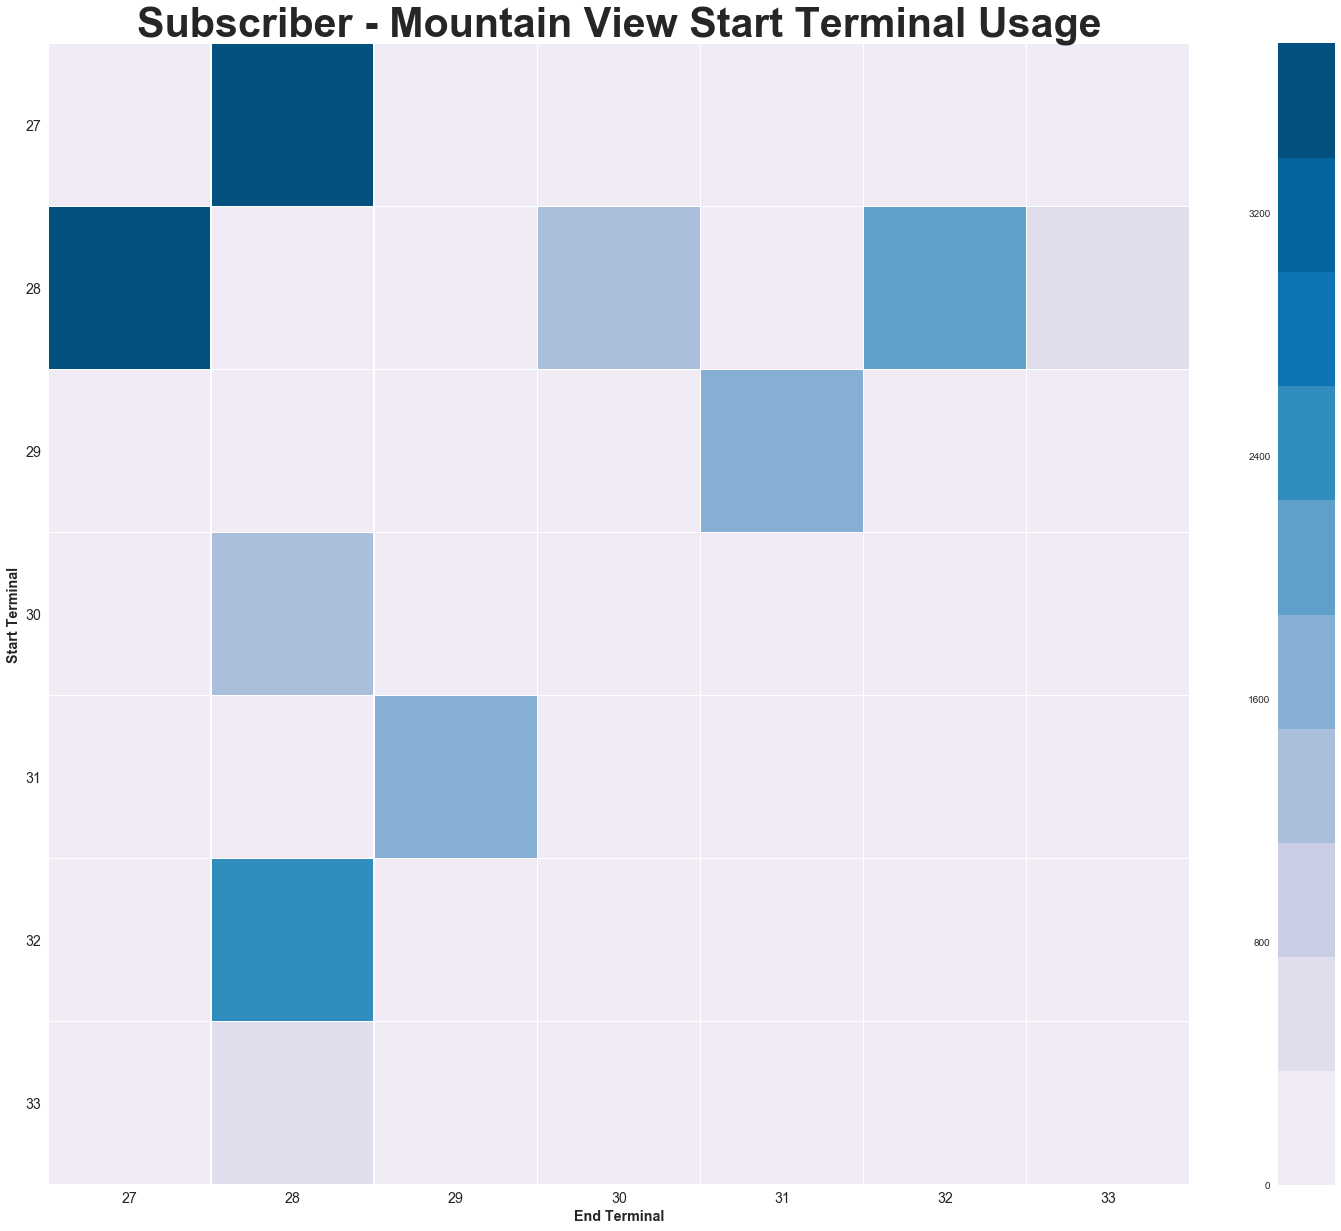

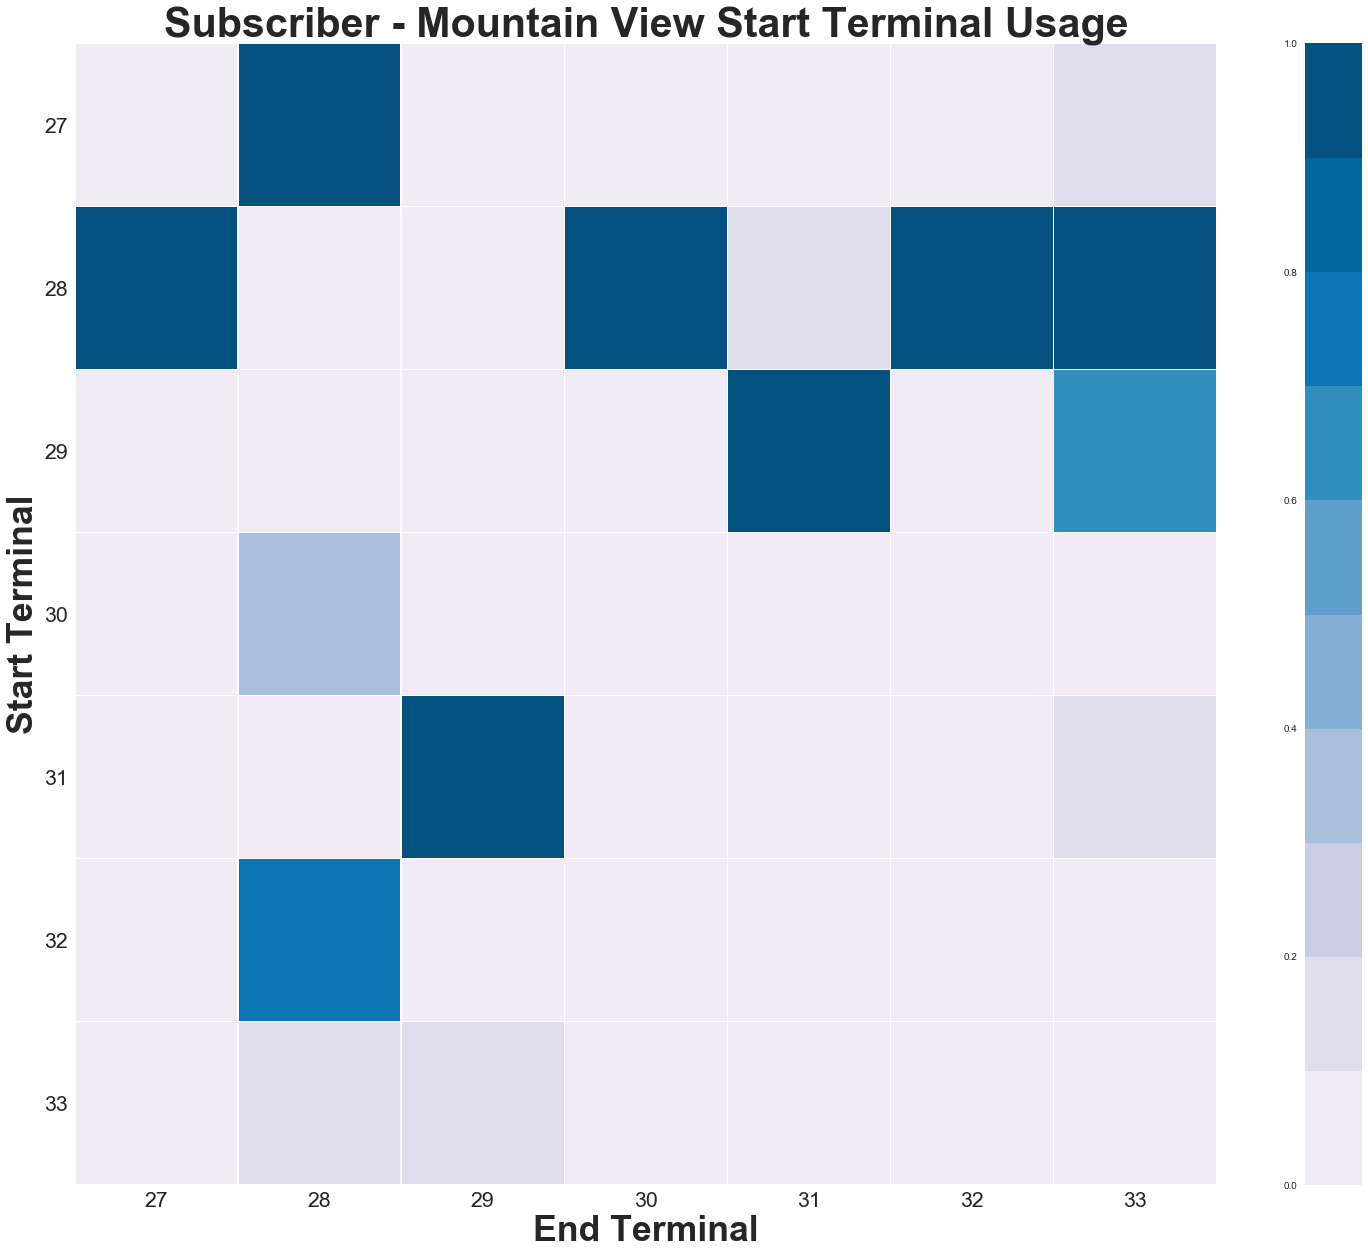

Total Trips in Mountain View	20620	2.44


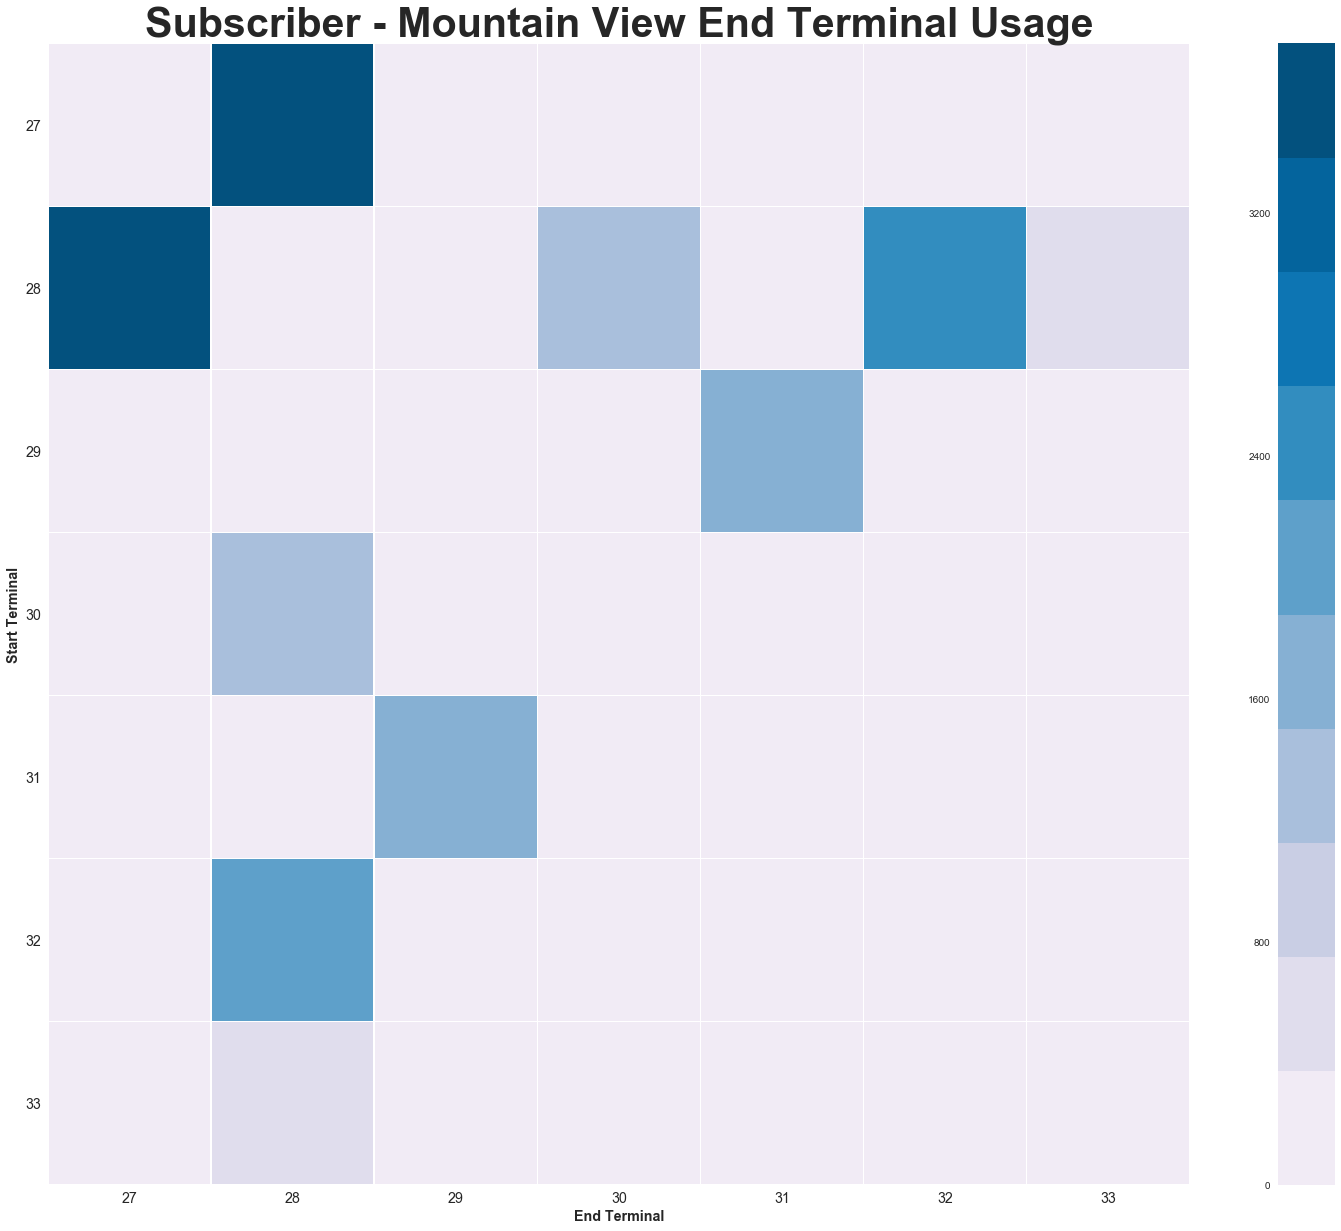

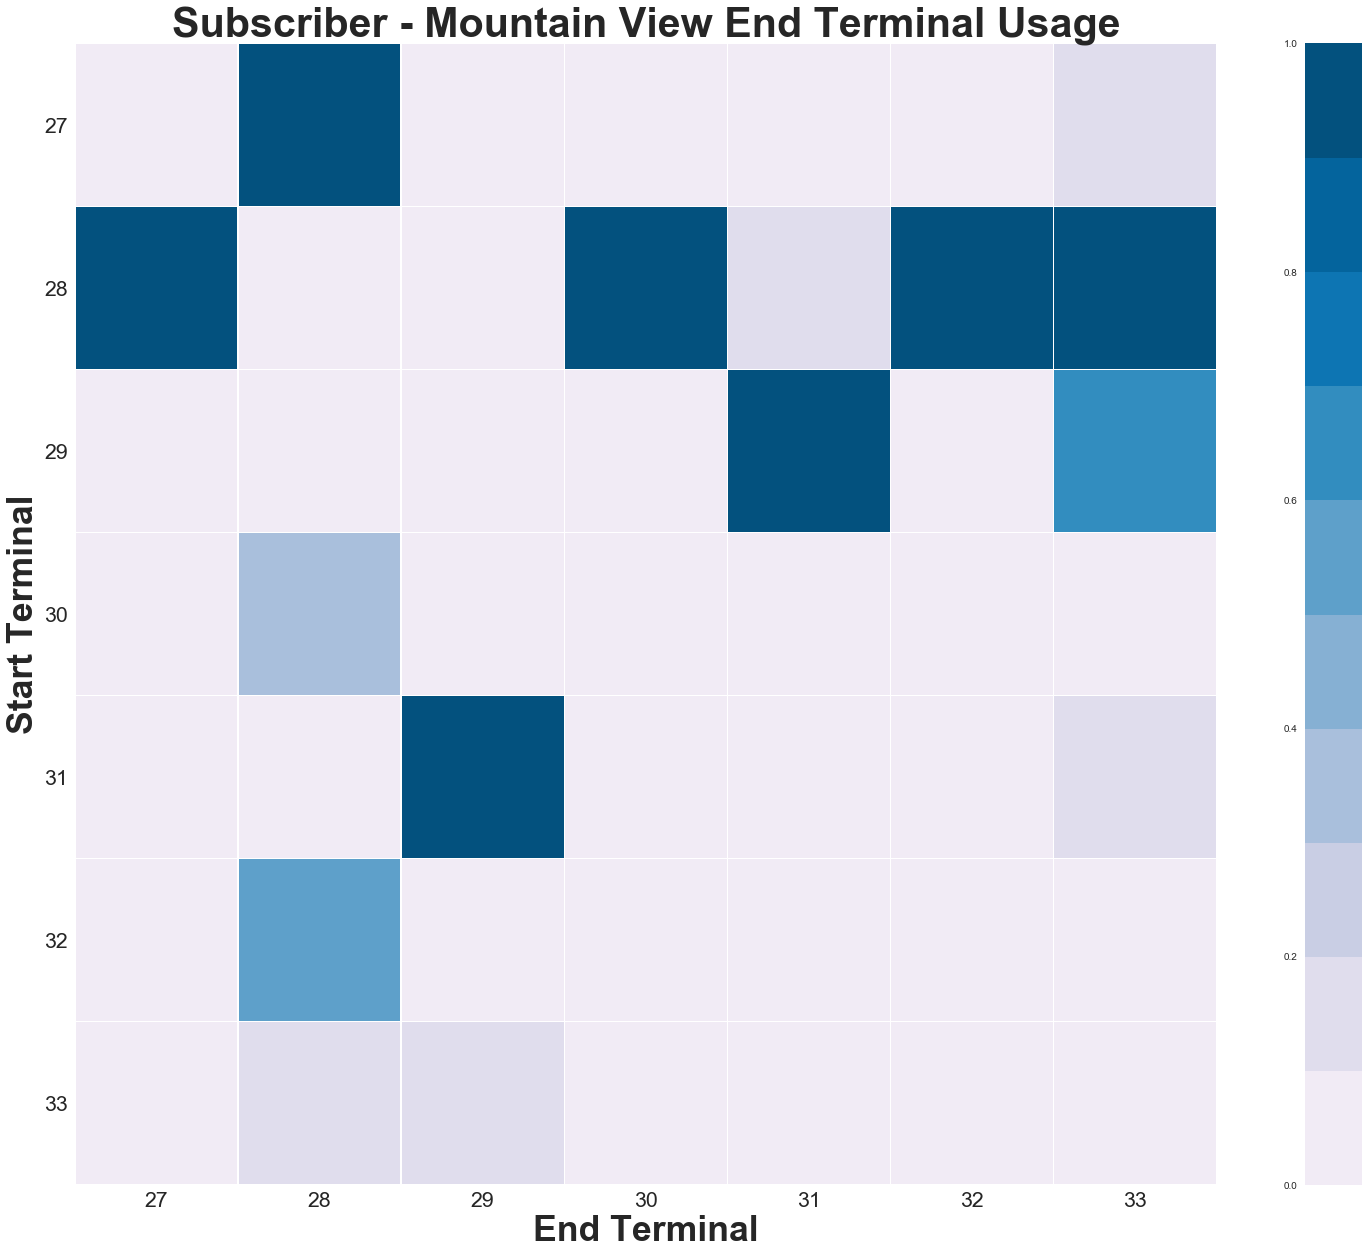

Total Trips in Mountain View	20620	2.44


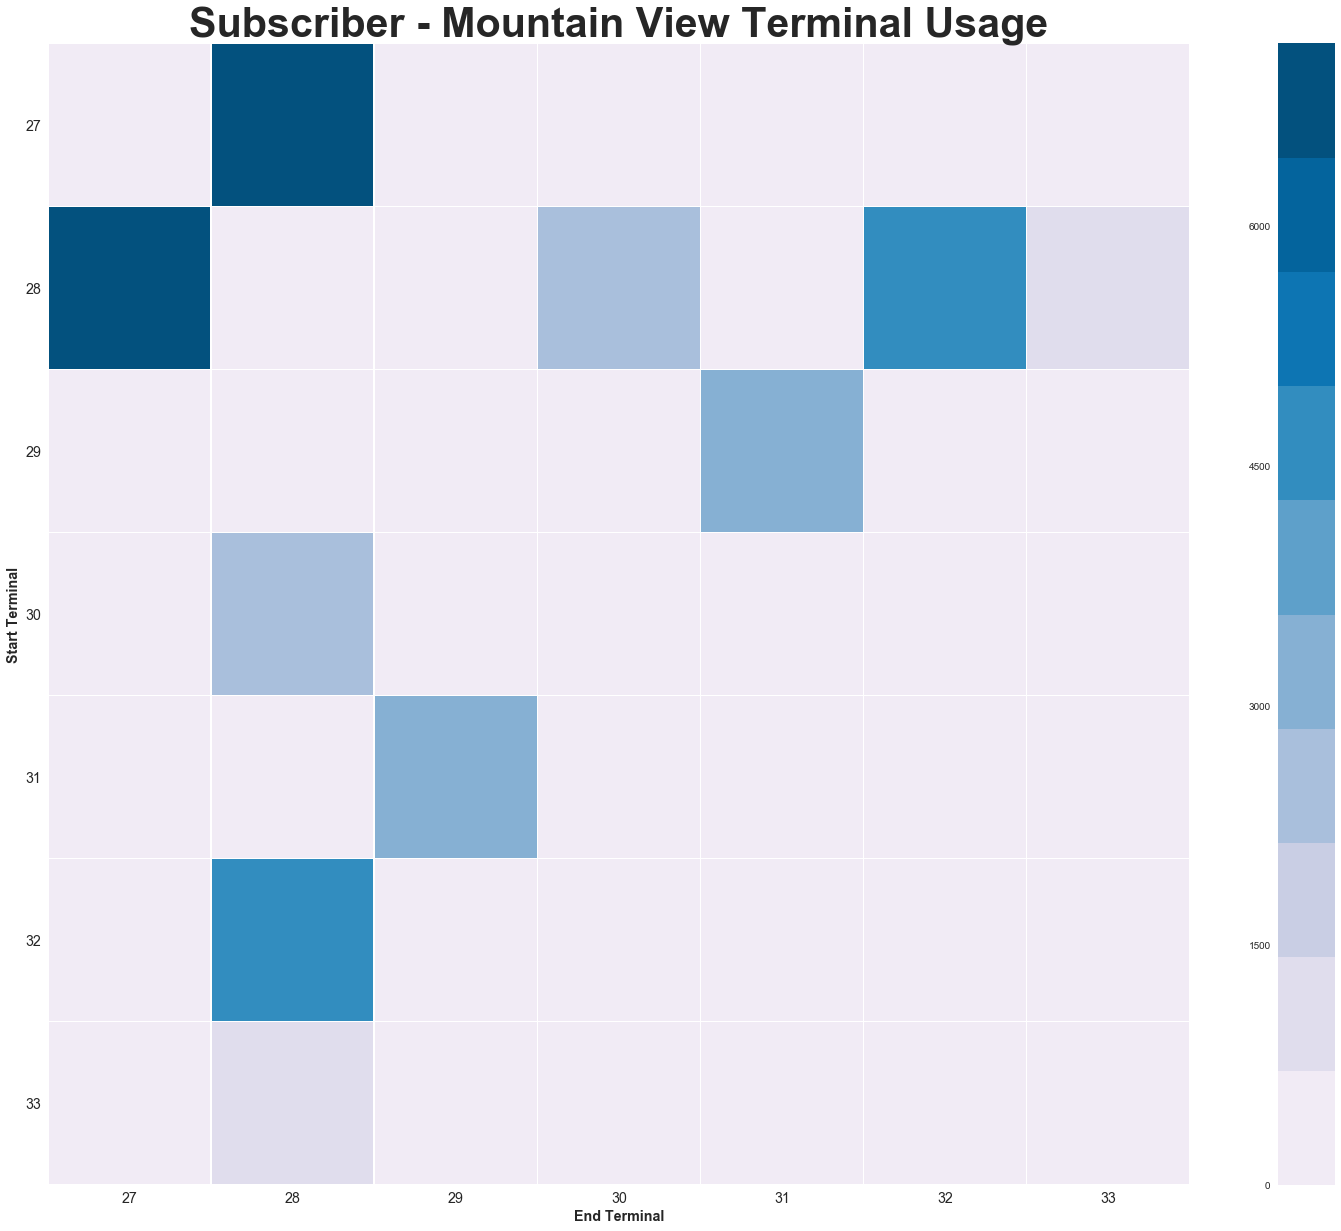

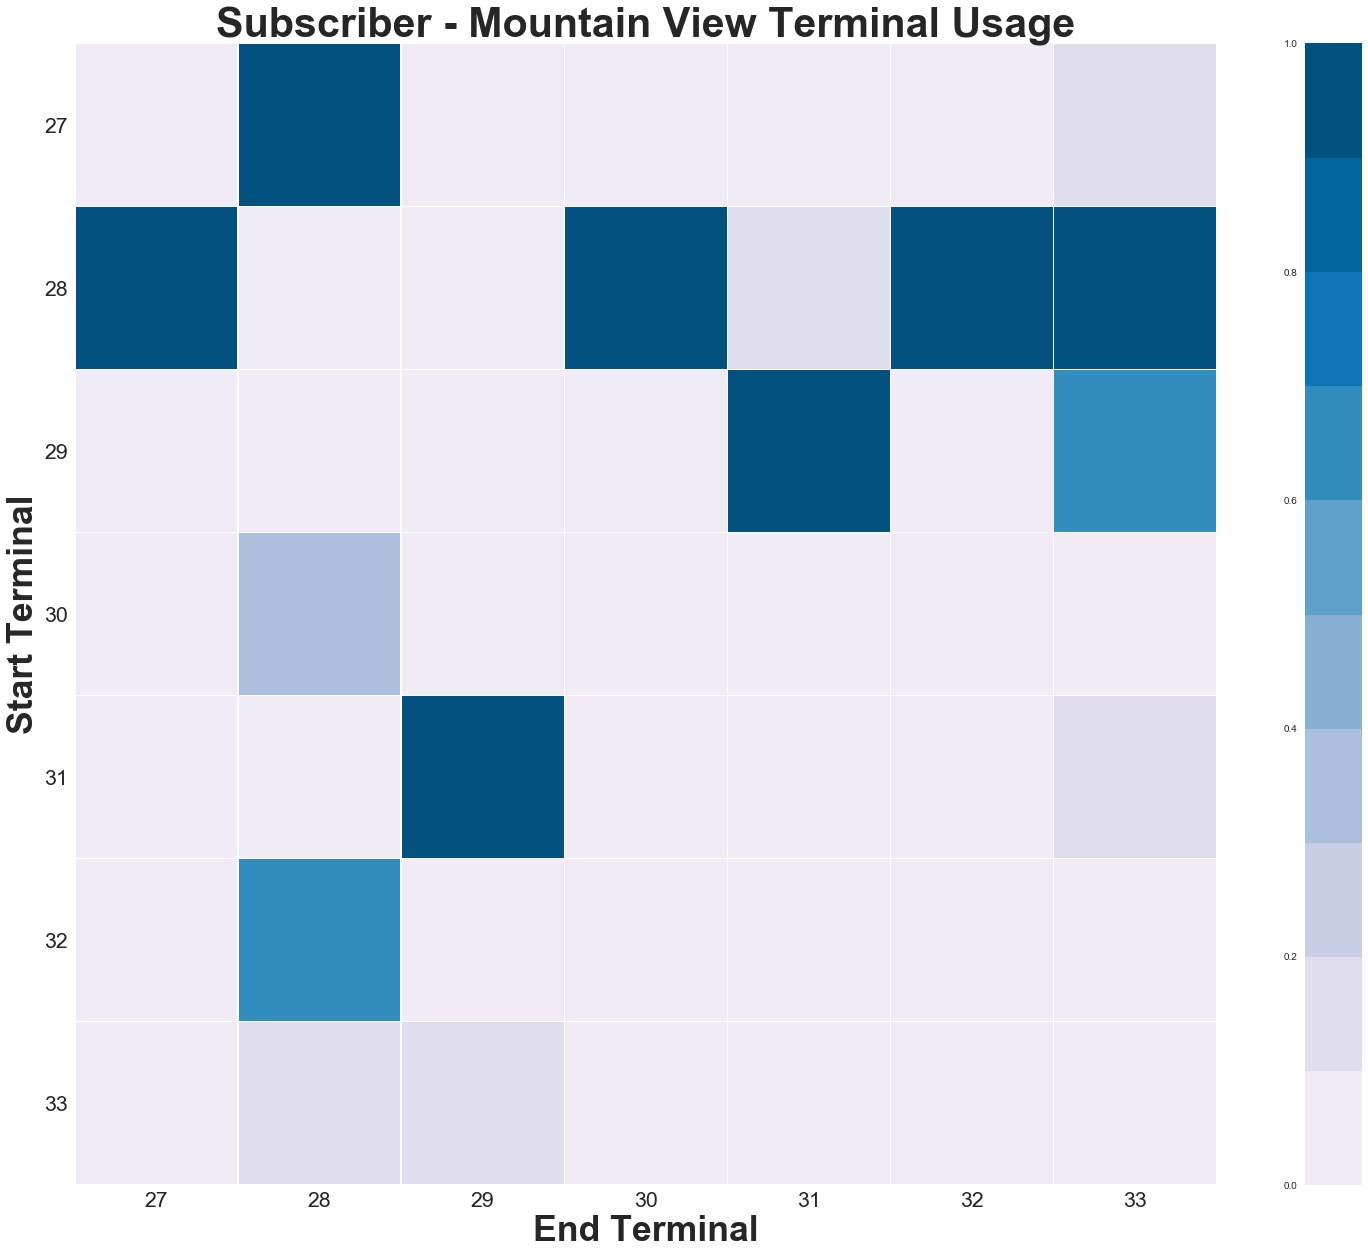

Total Trips in Redwood City	4075	0.48


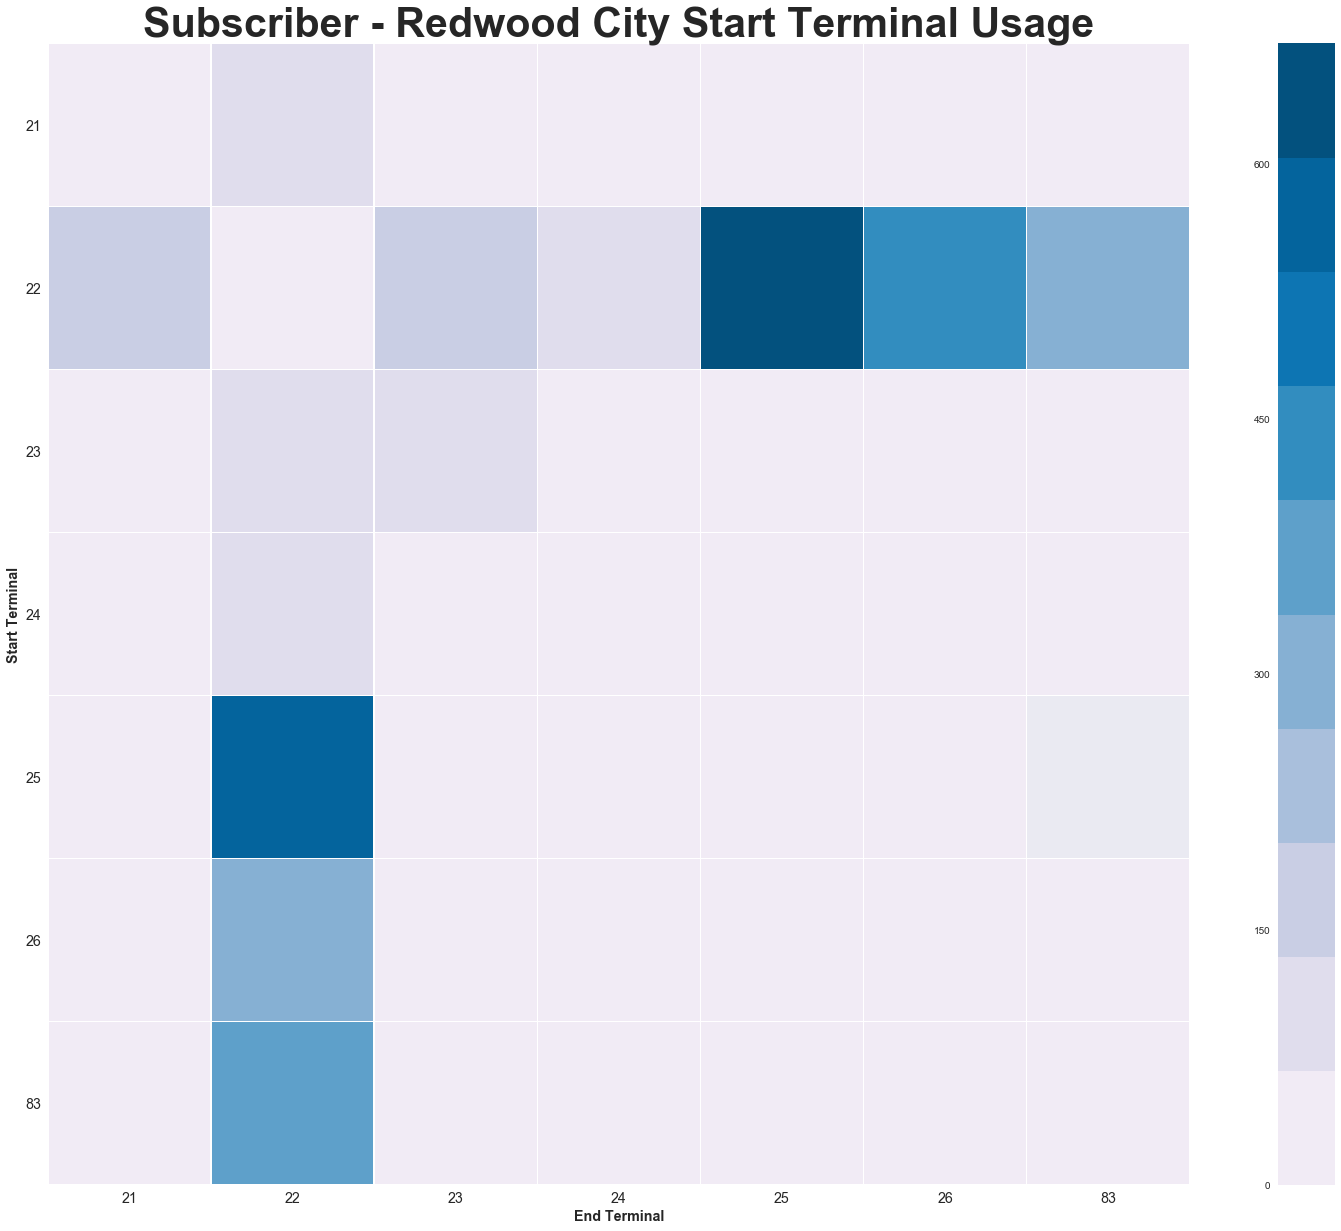

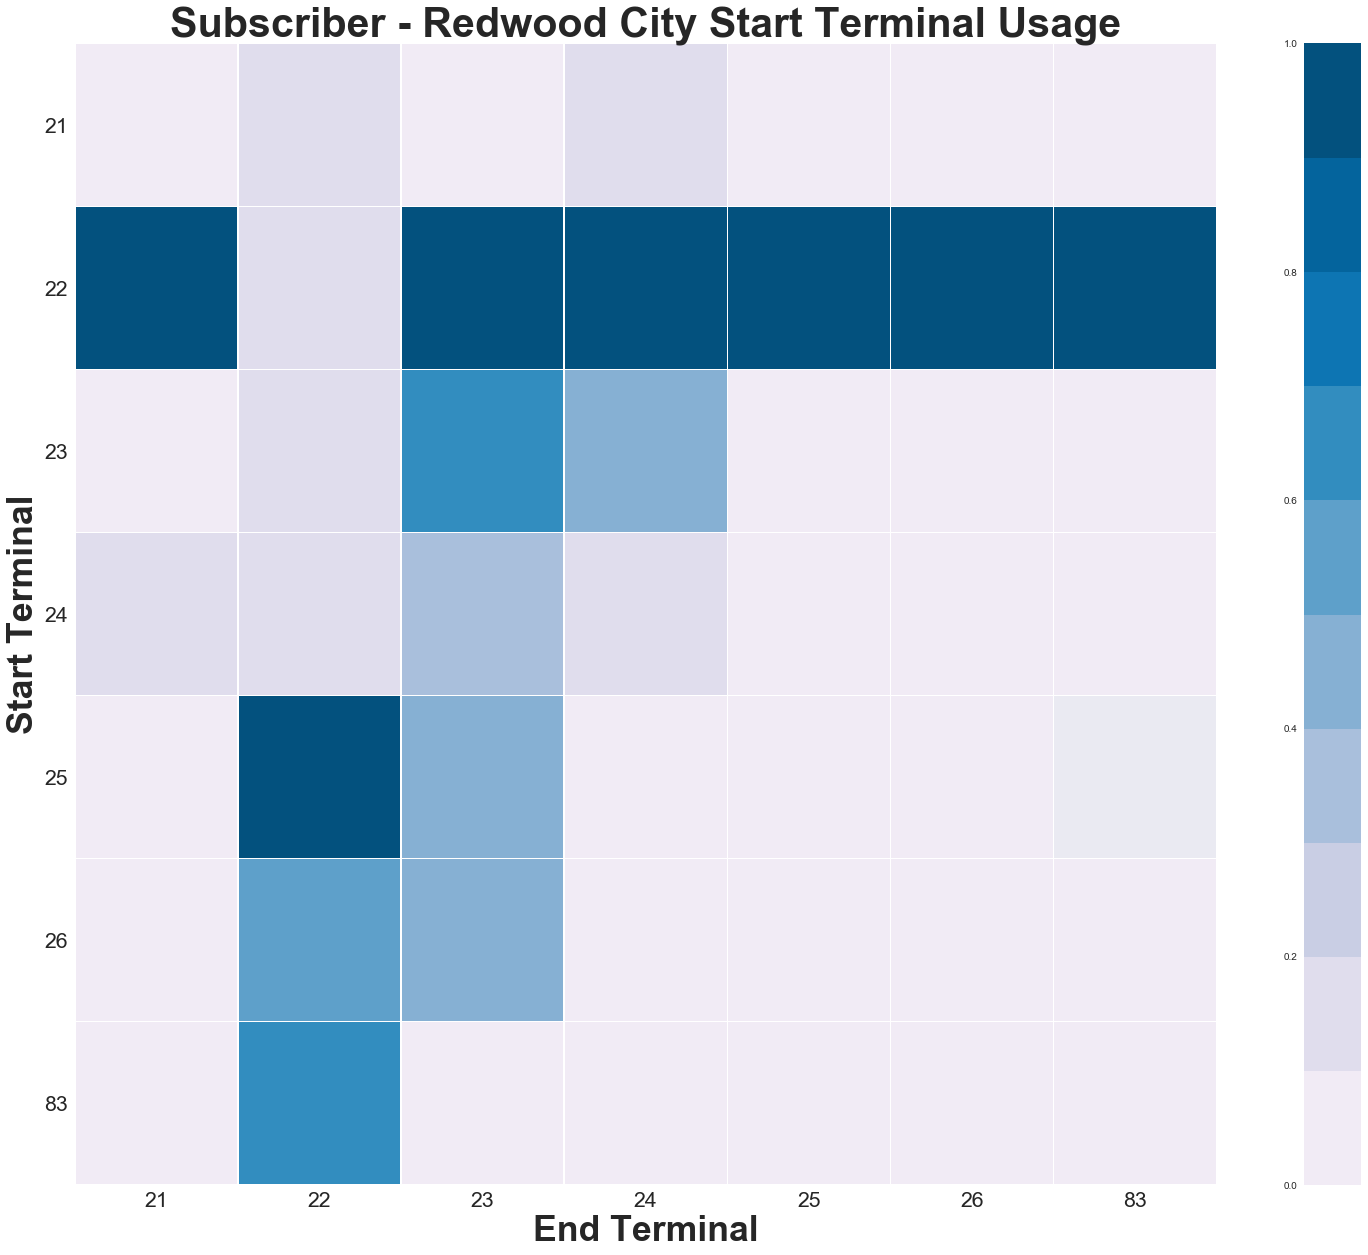

Total Trips in Redwood City	4075	0.48


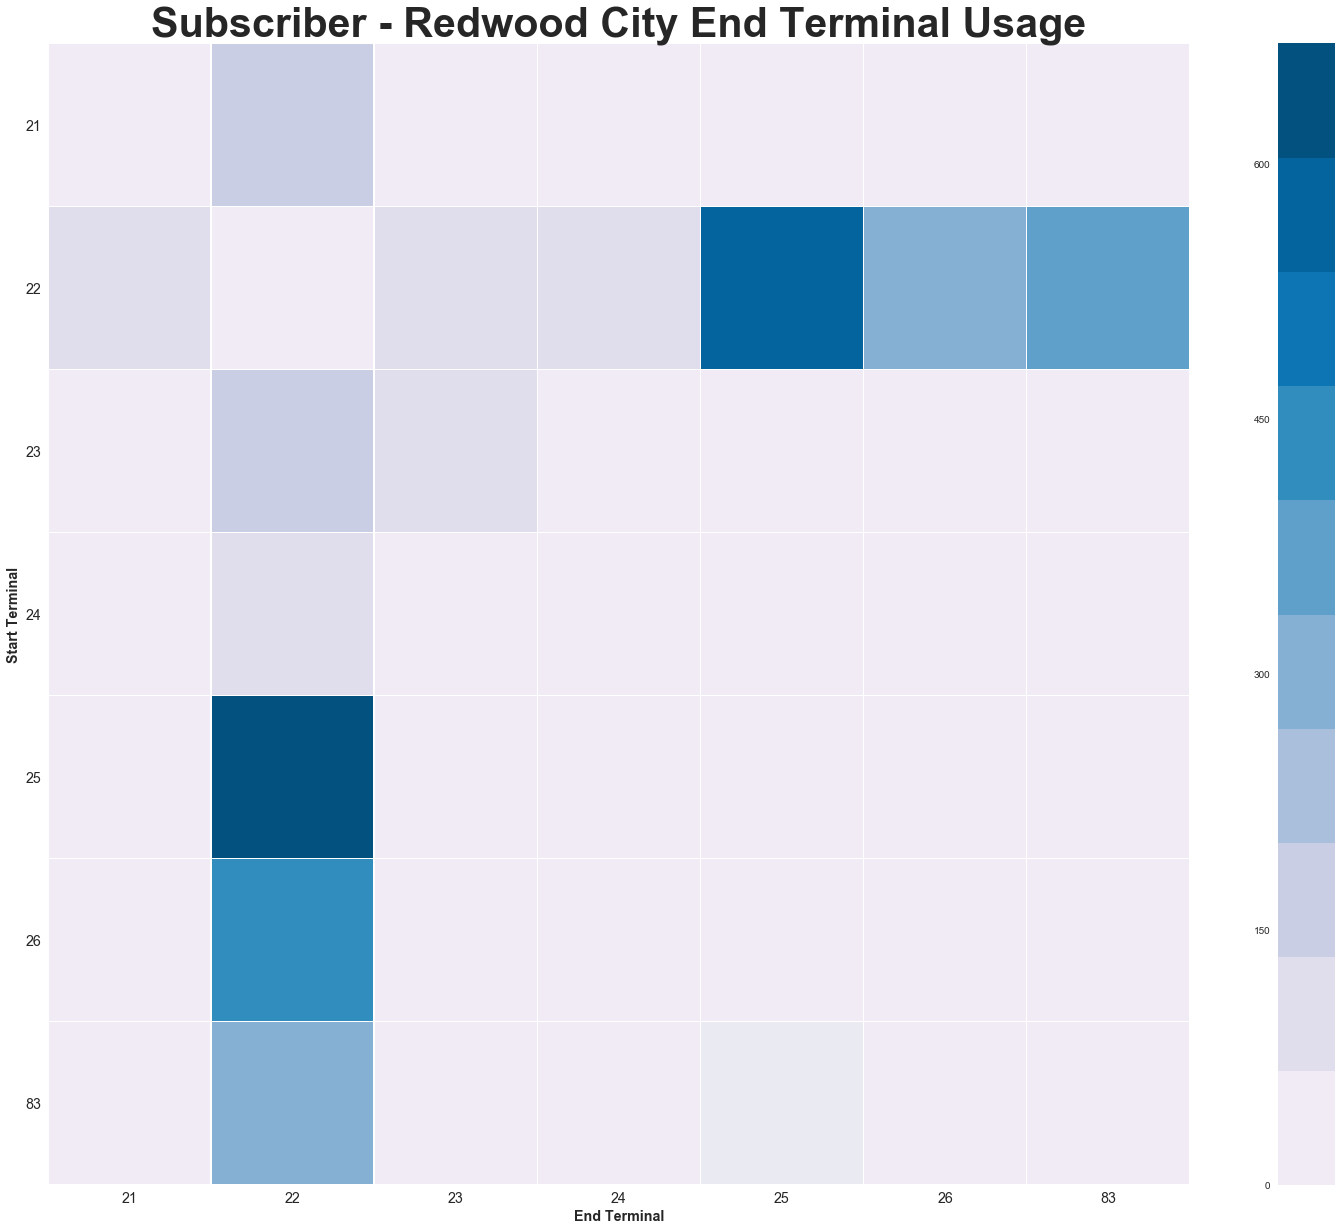

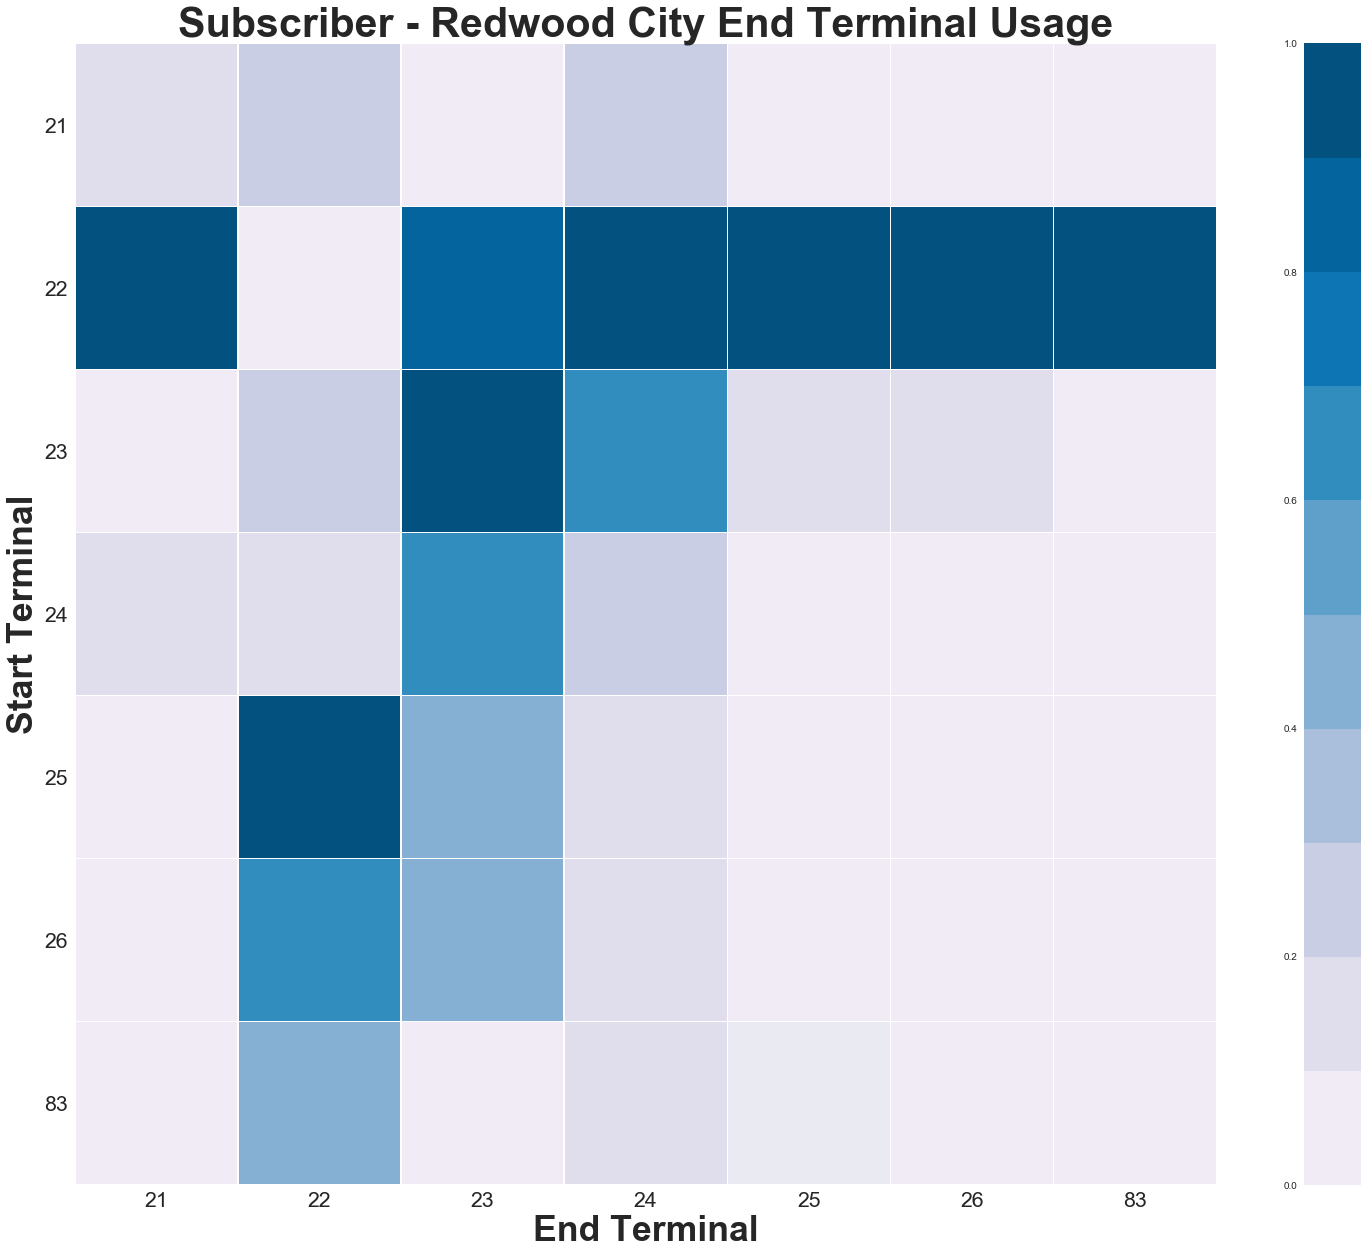

Total Trips in Redwood City	4075	0.48


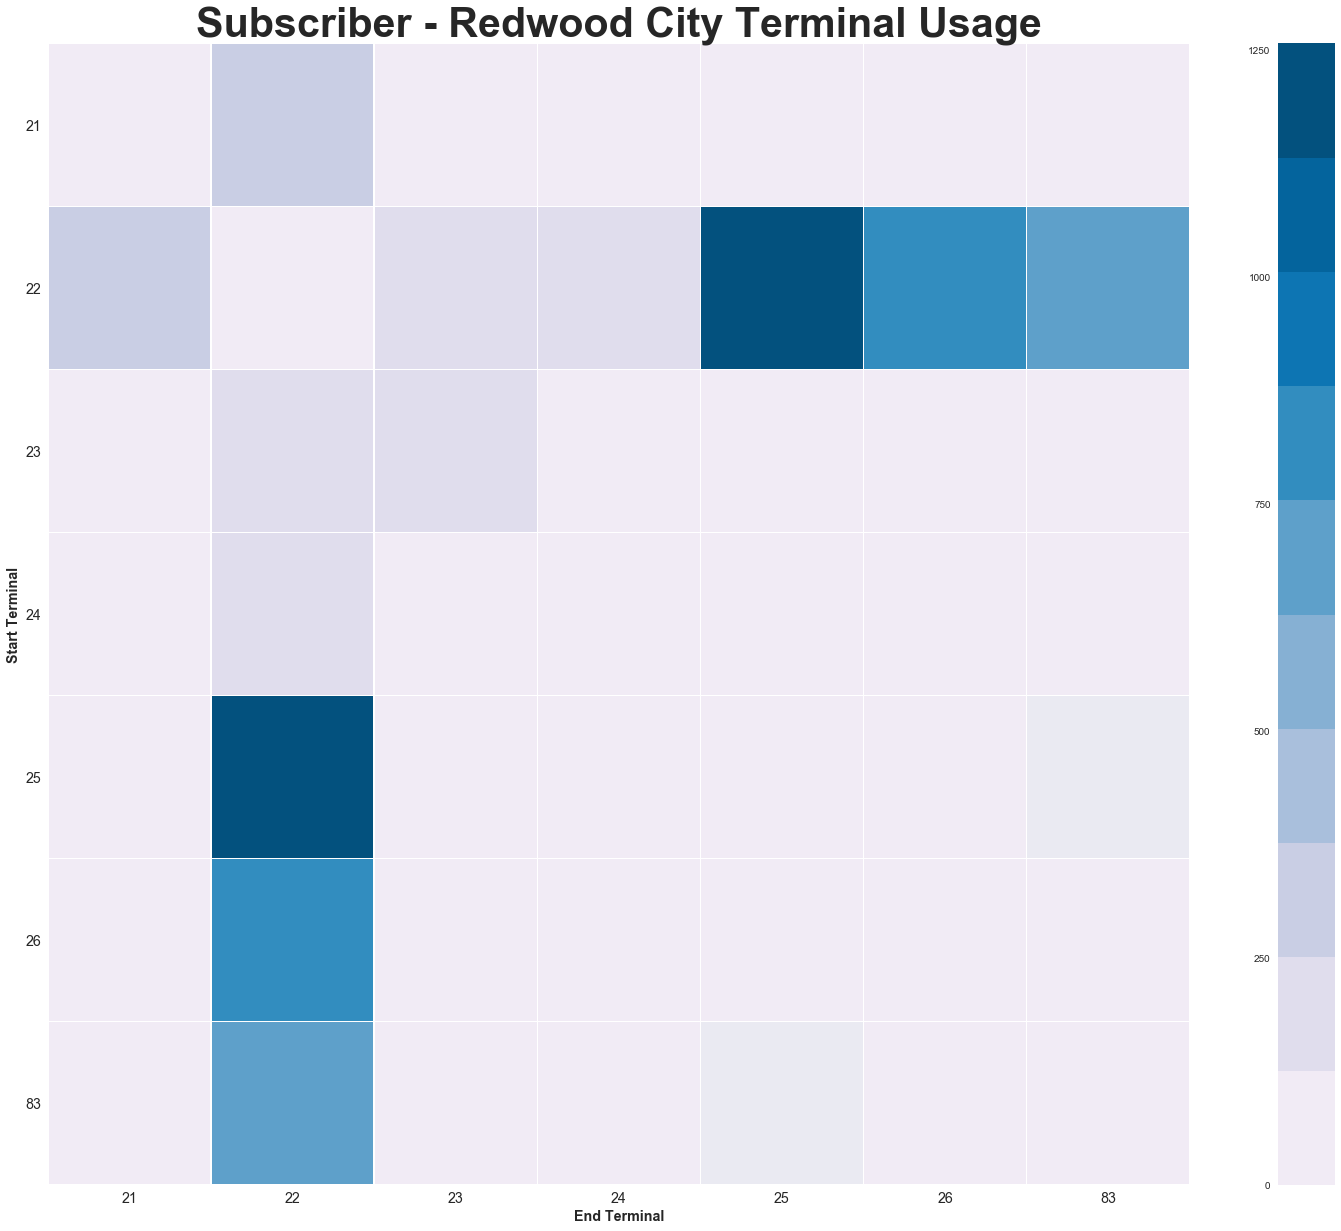

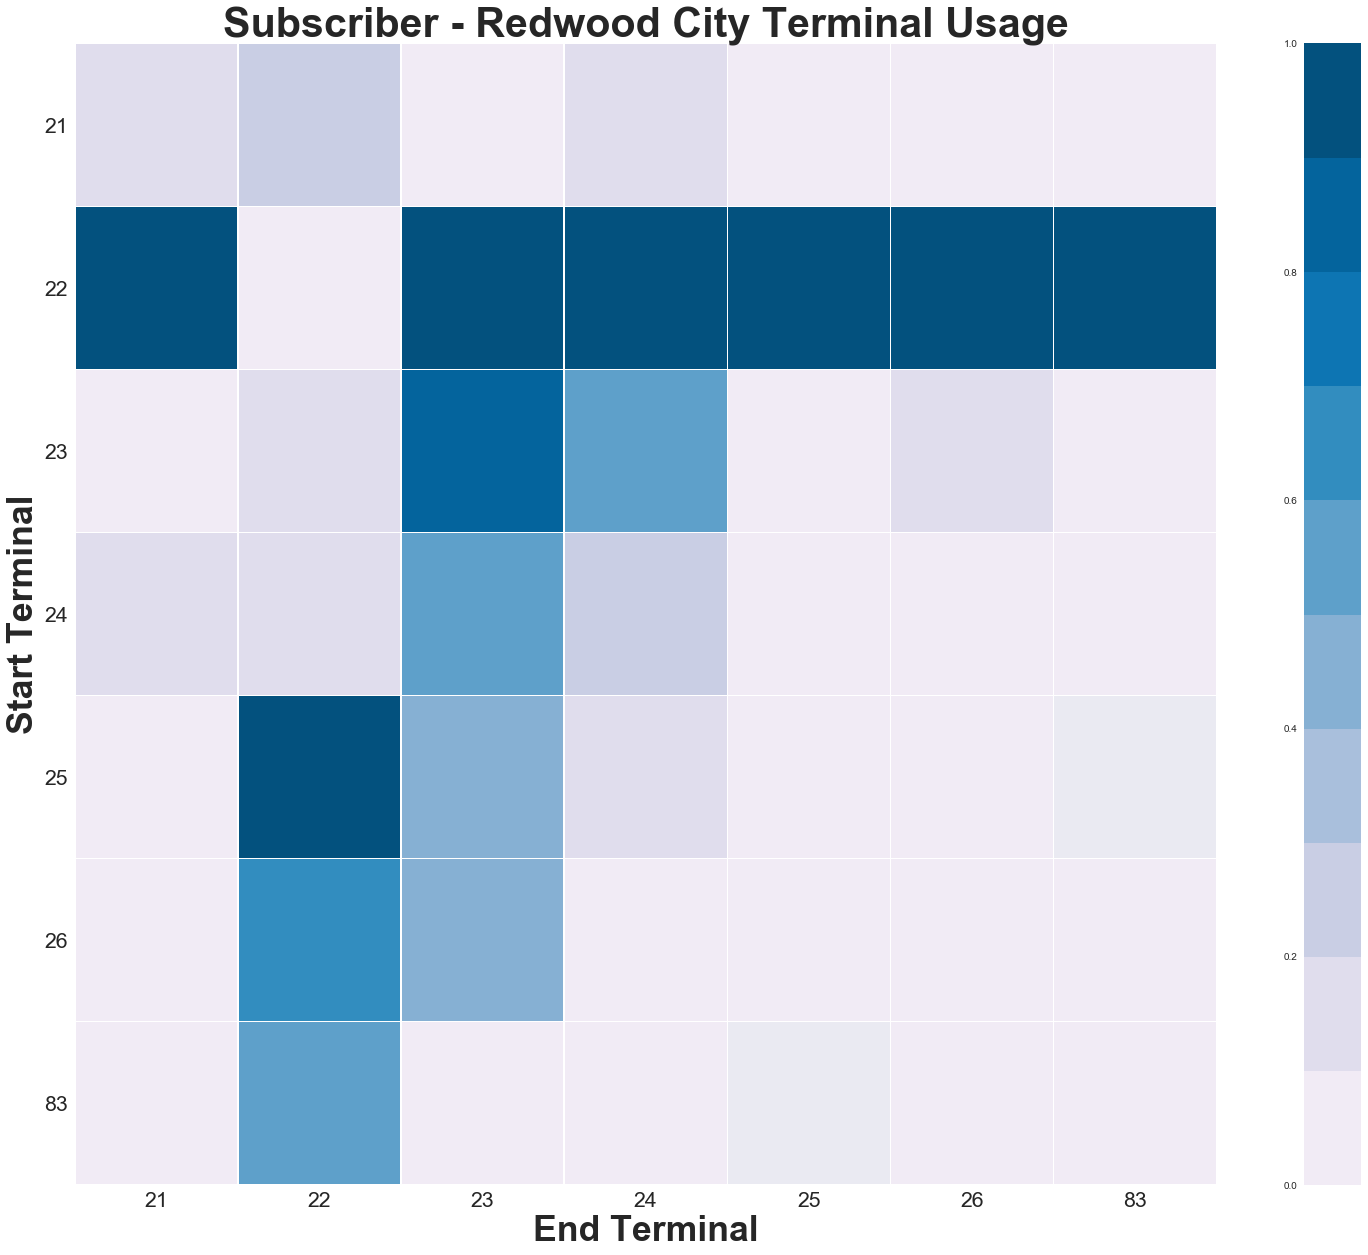

Total Trips in San Francisco	769677	91.21


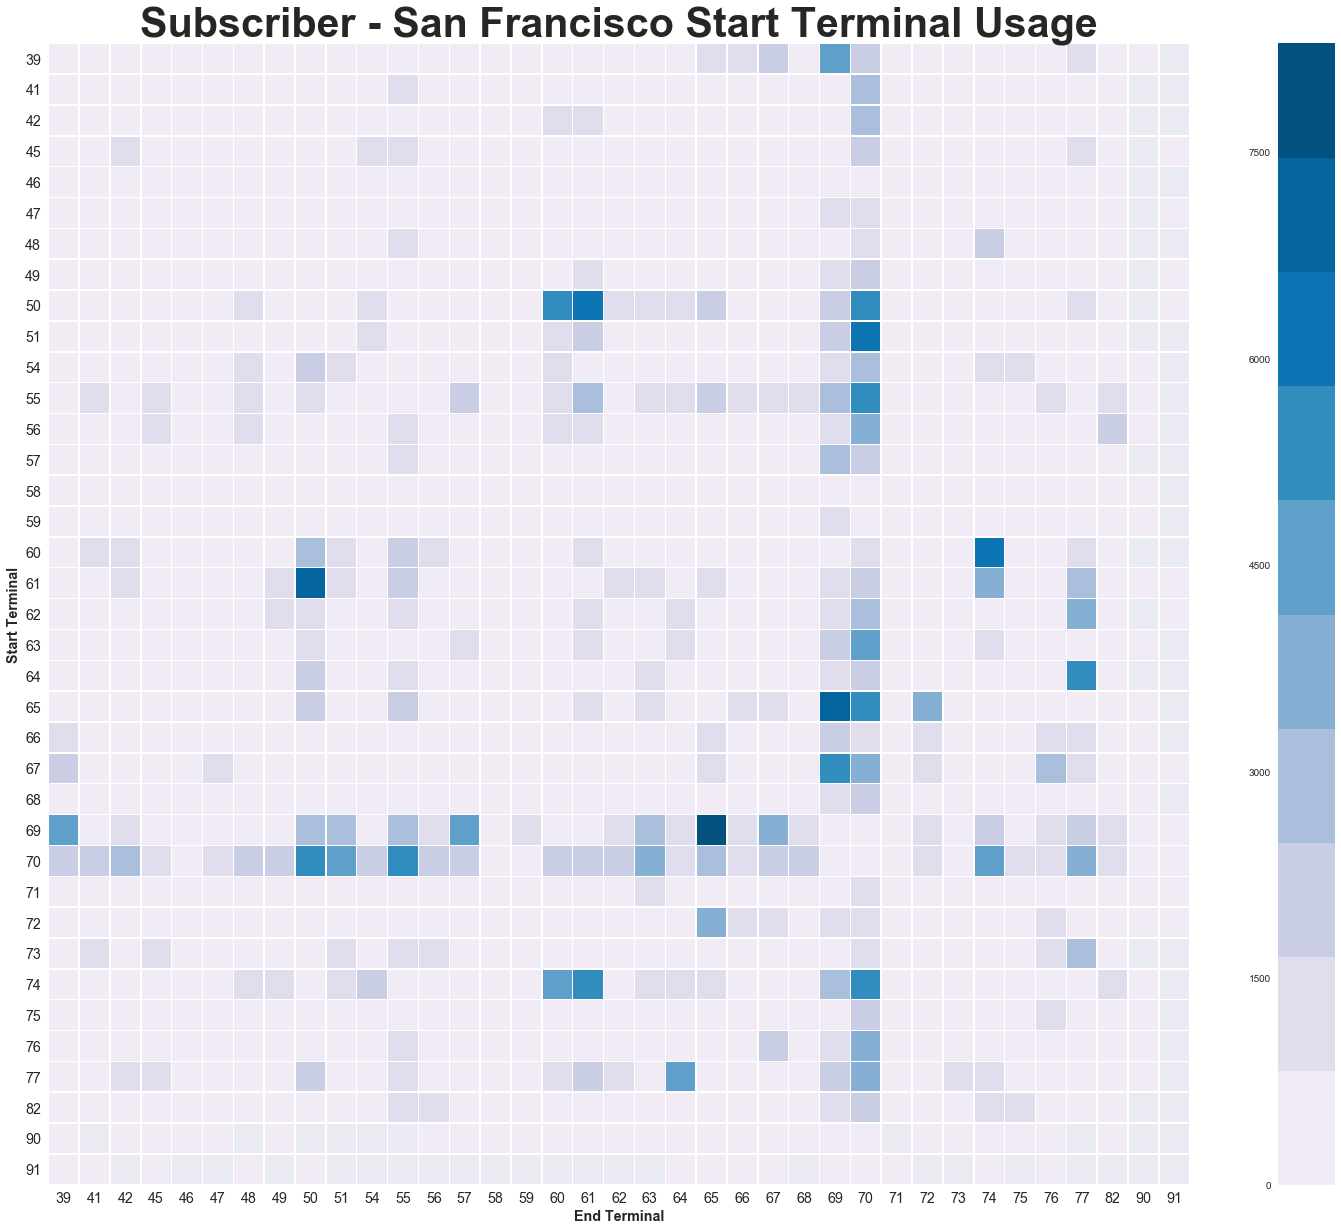

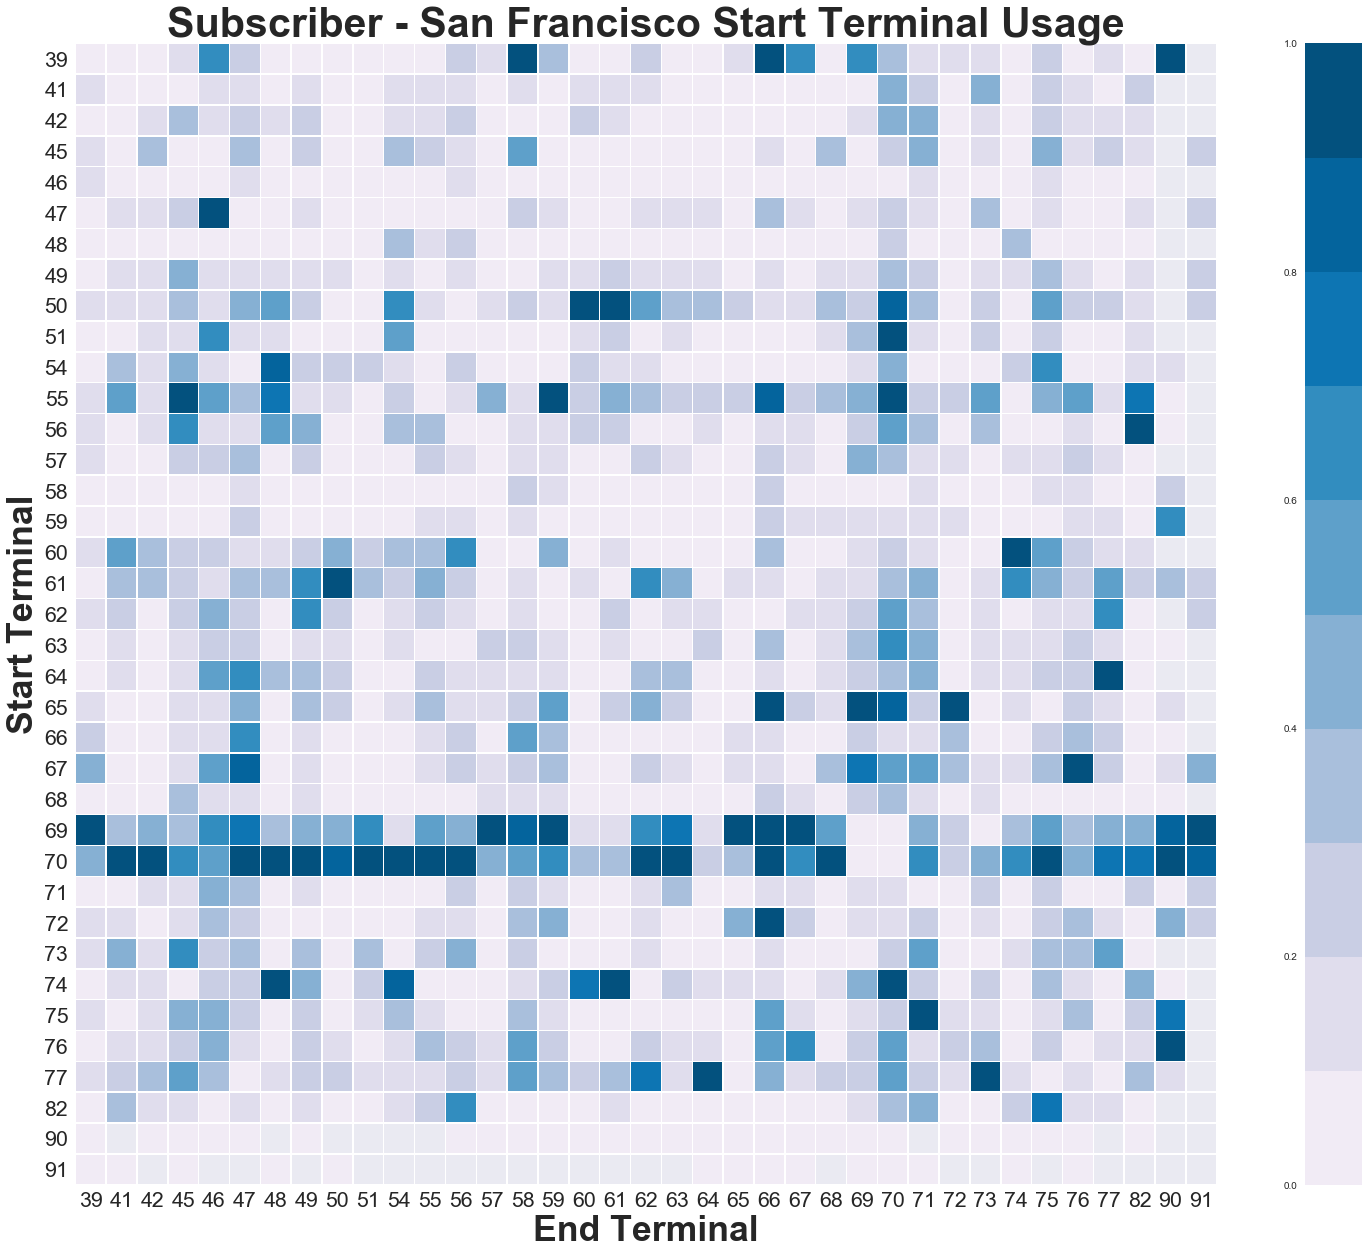

Total Trips in San Francisco	769677	91.21


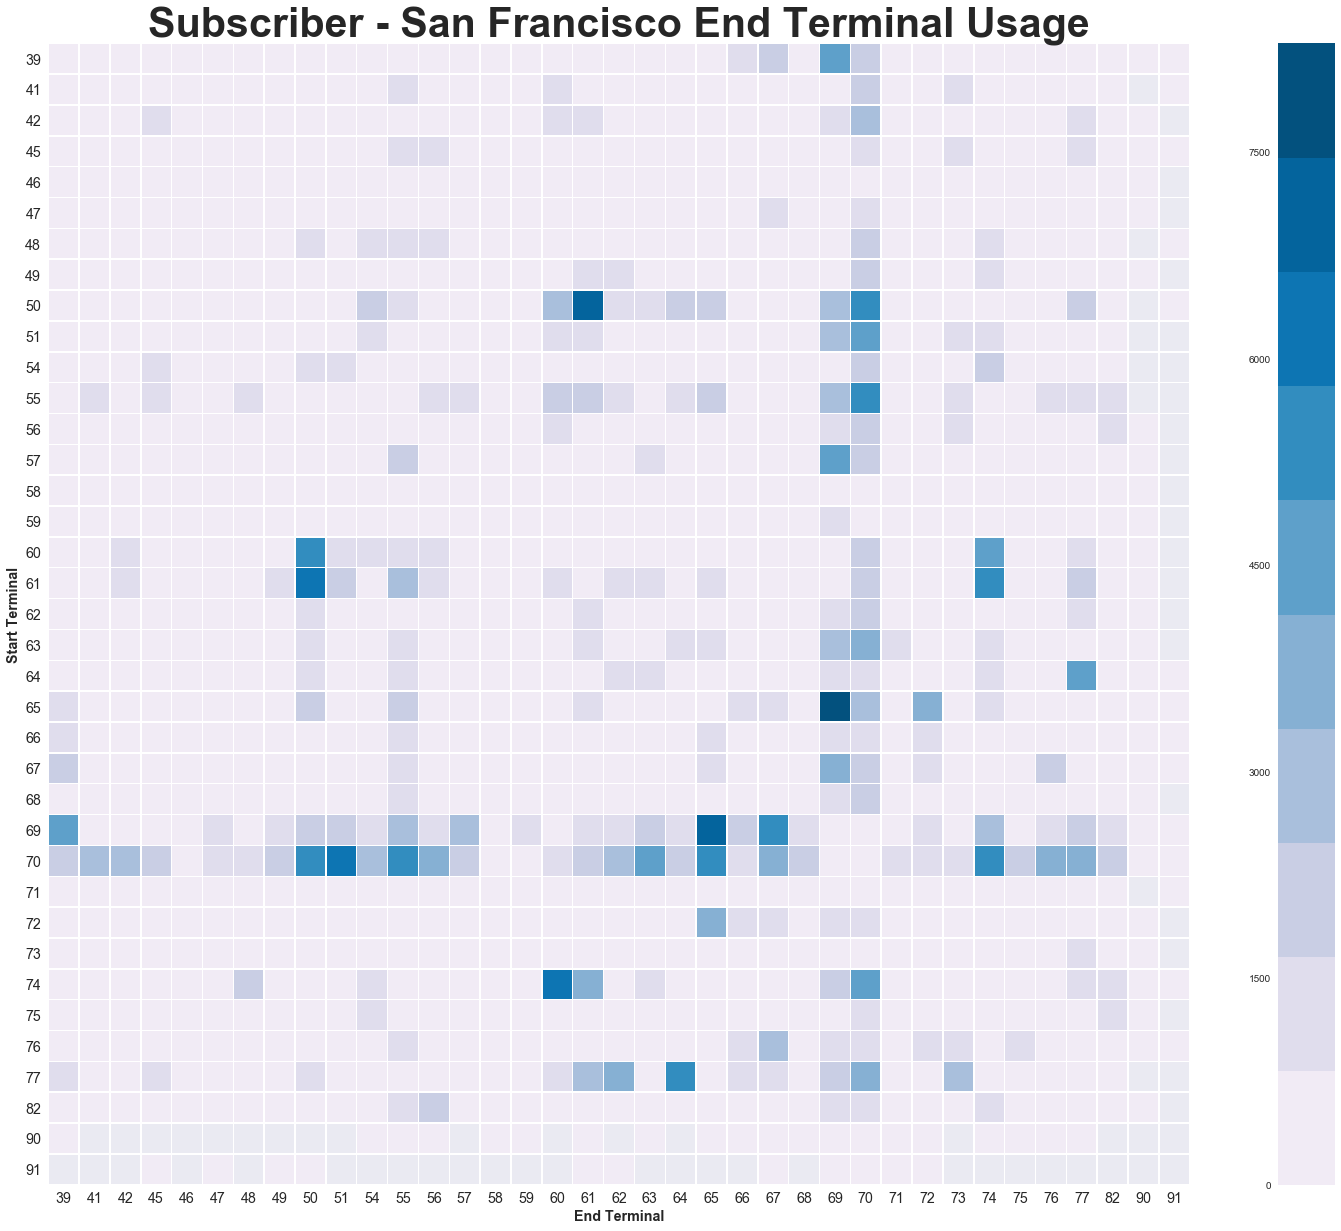

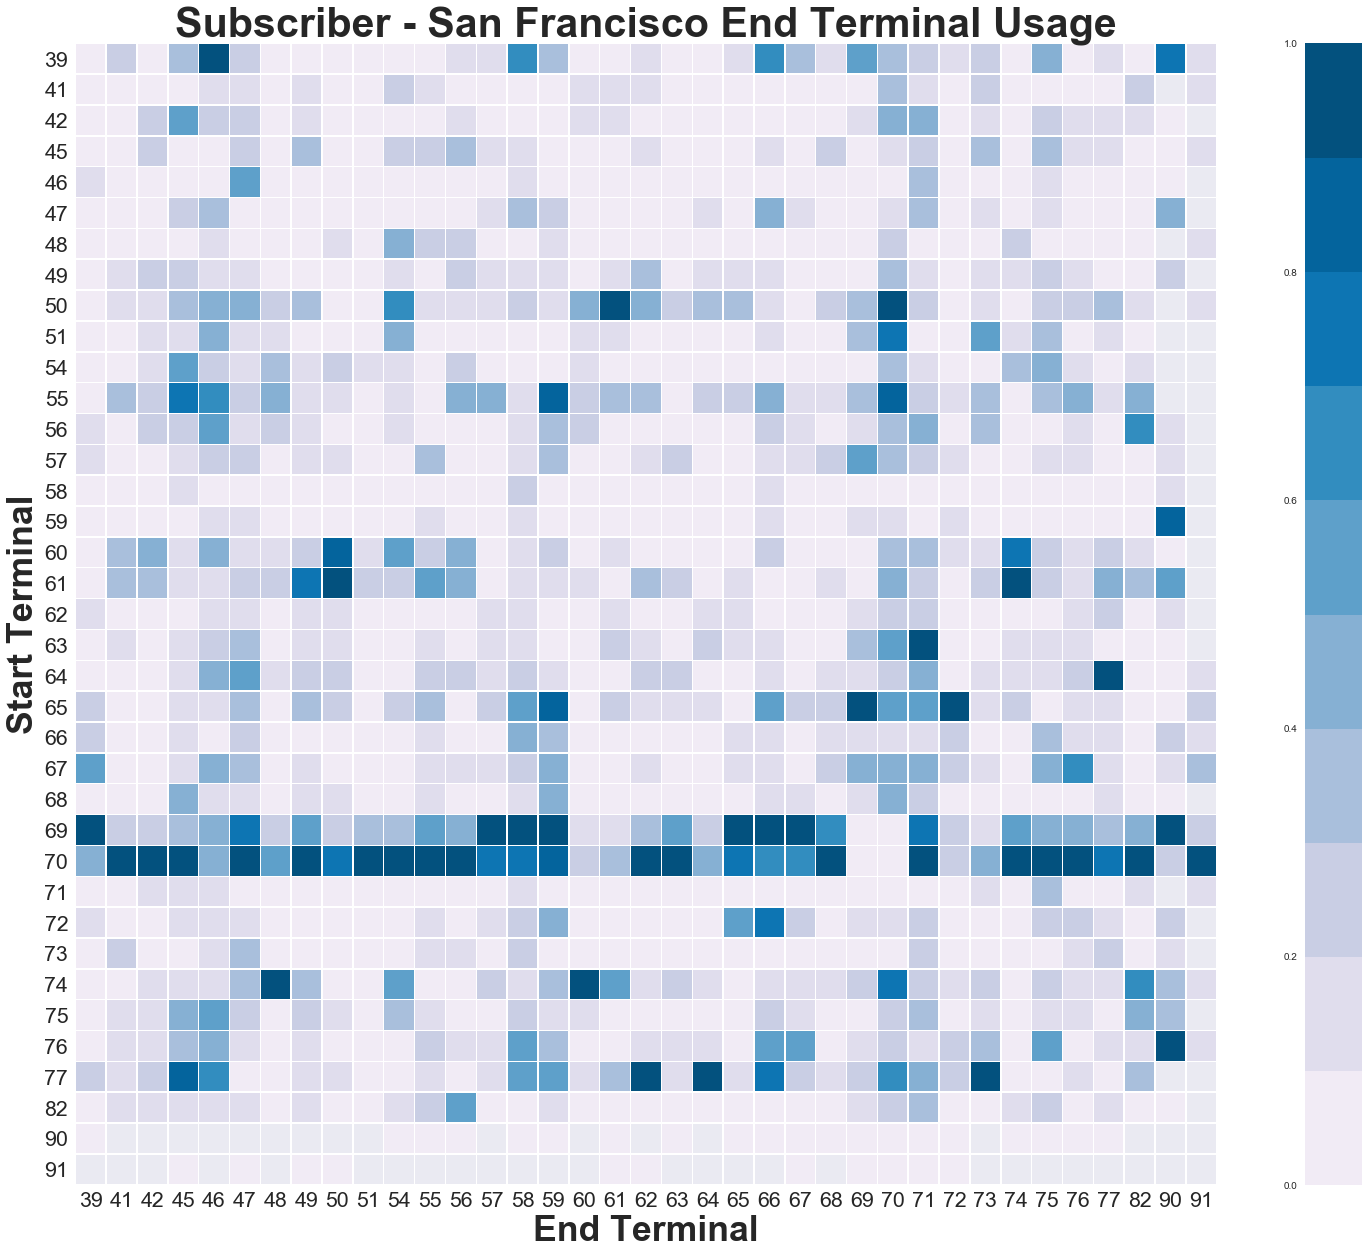

Total Trips in San Francisco	769677	91.21


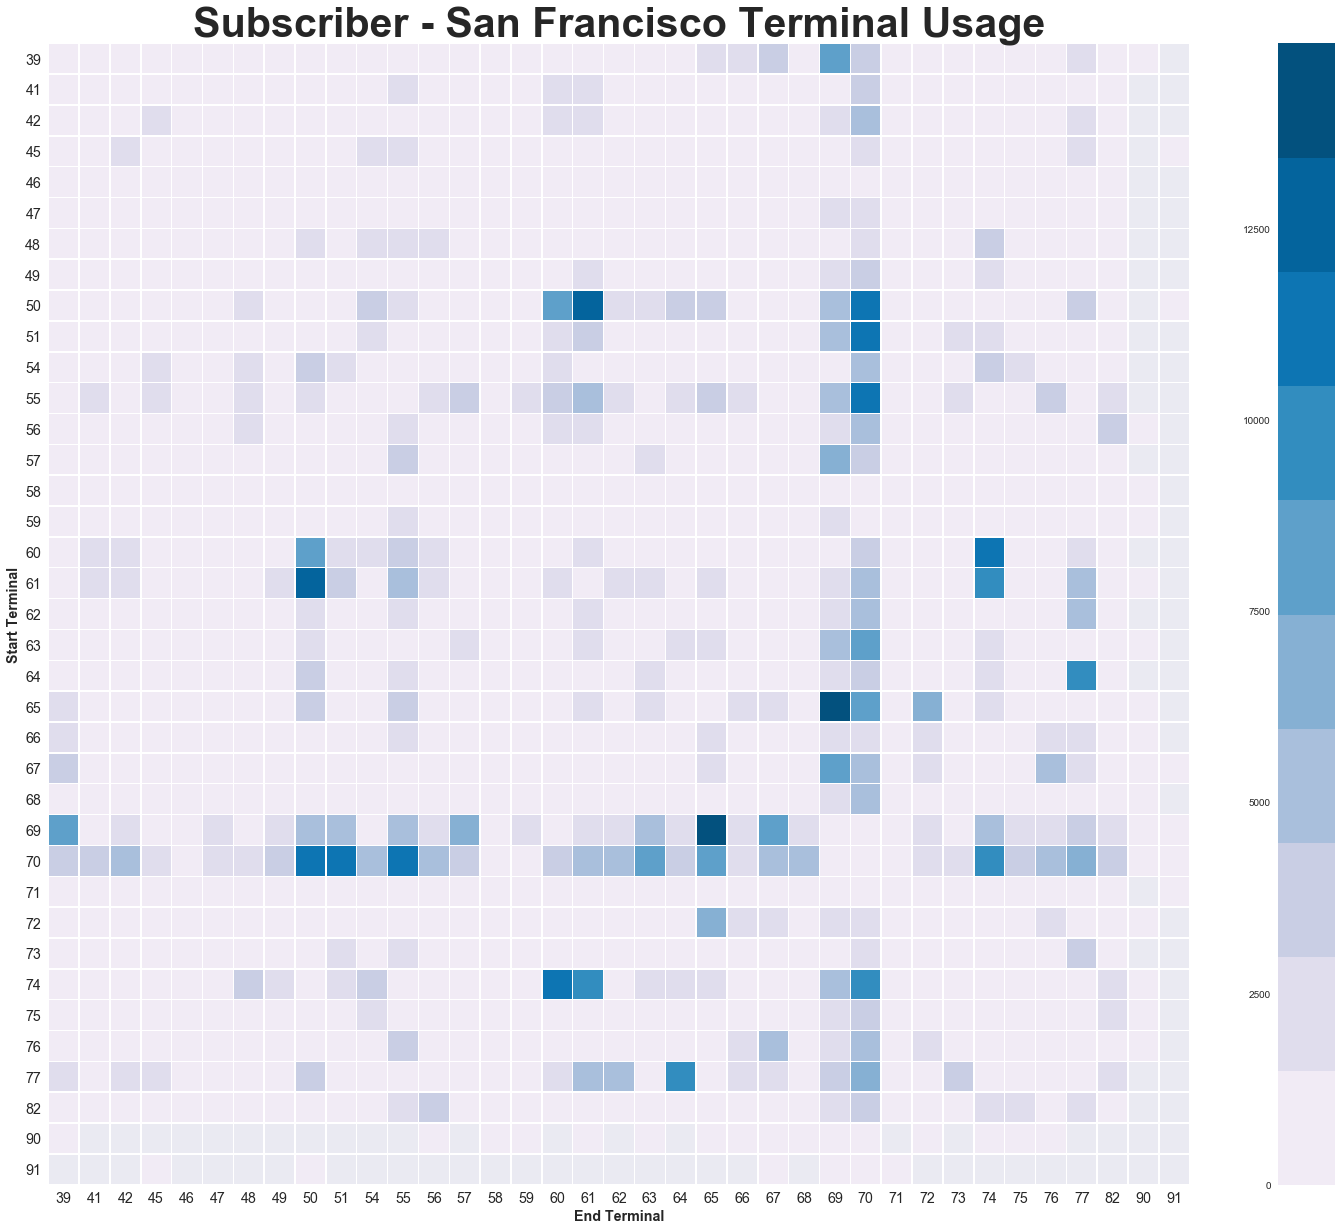

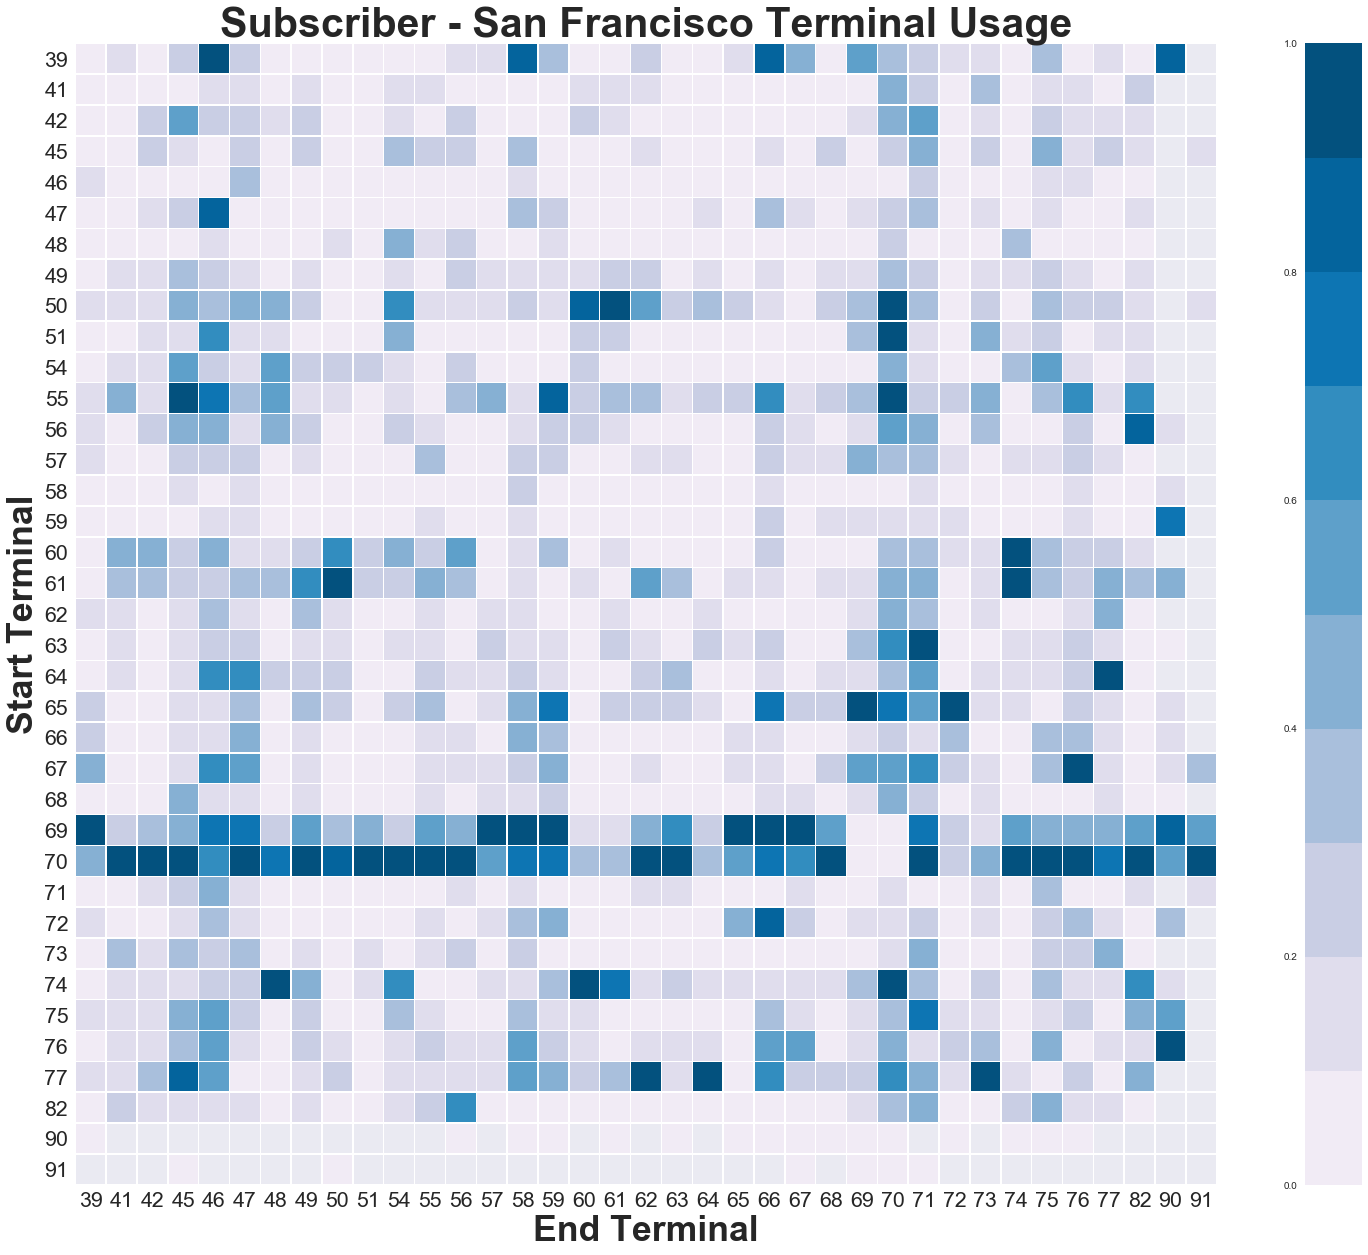

Total Trips in Palo Alto	5530	0.66


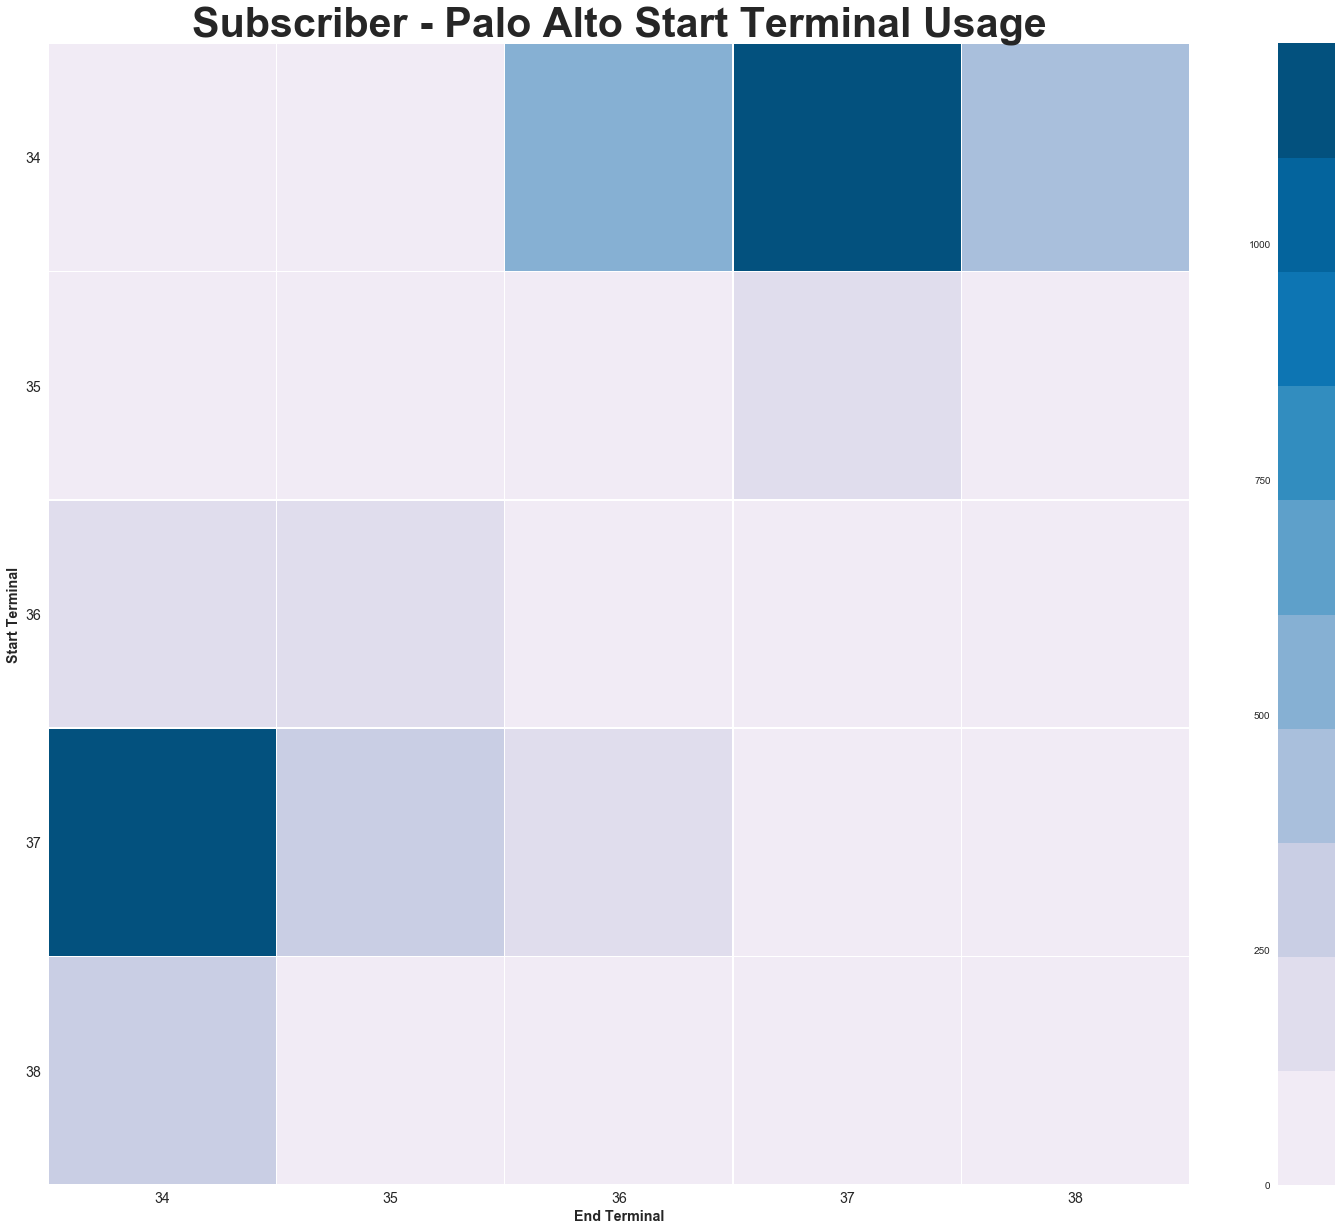

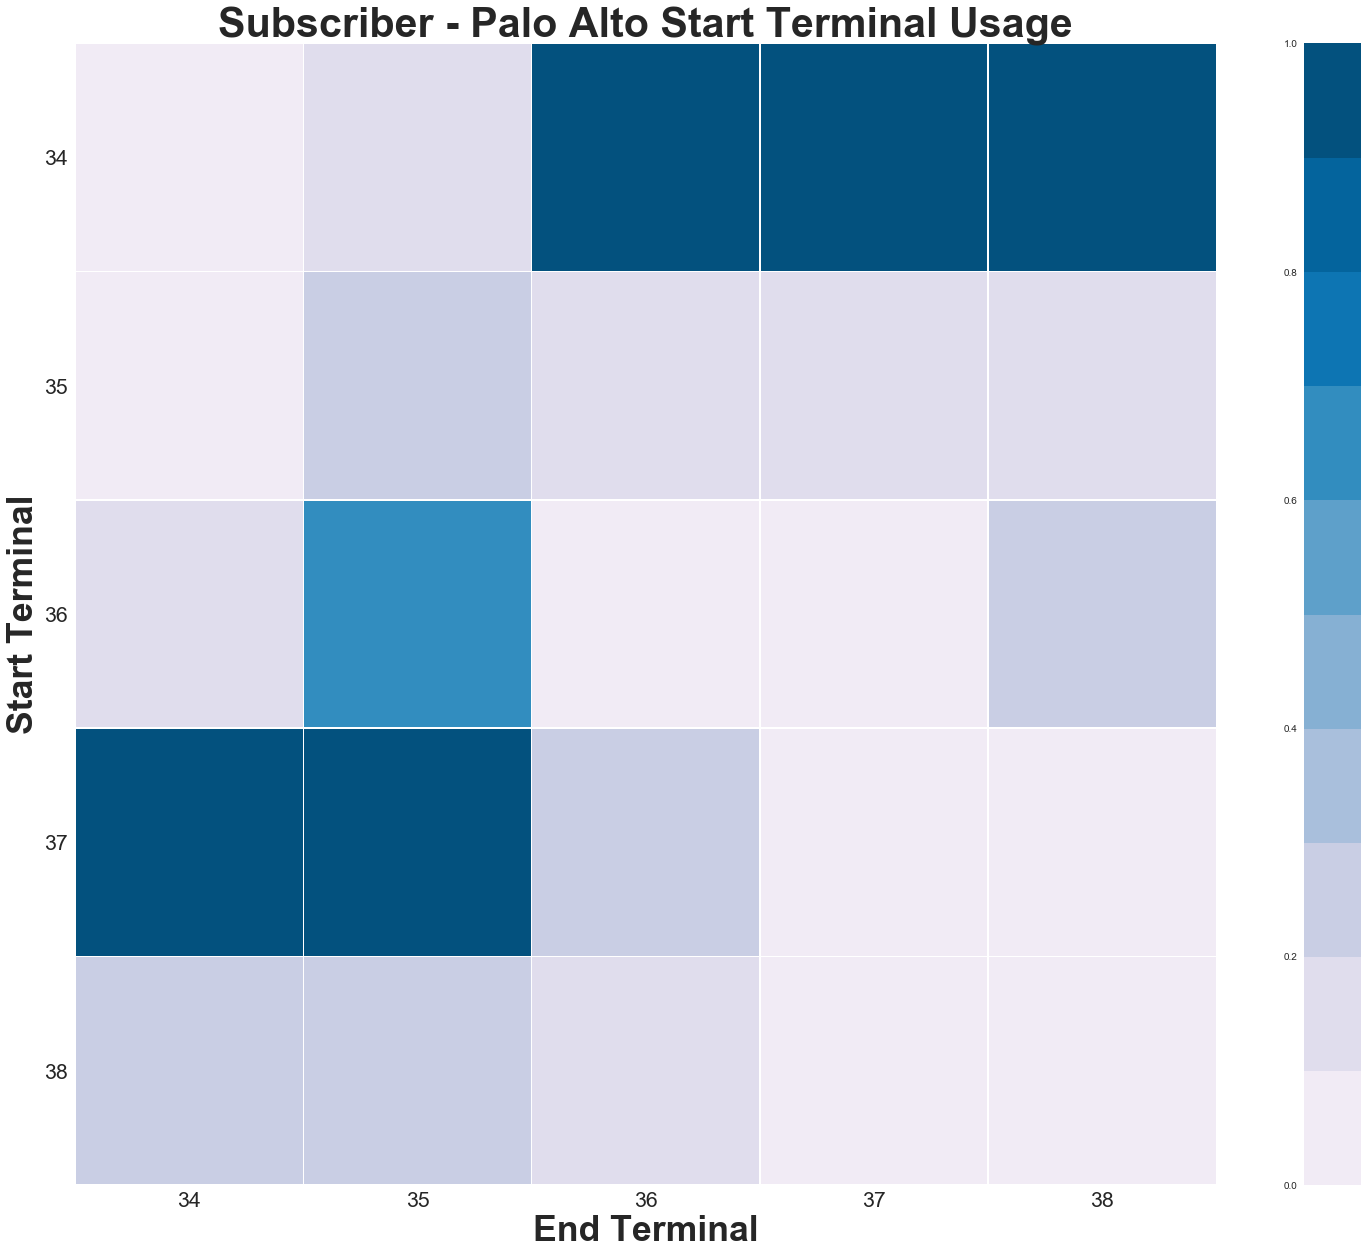

Total Trips in Palo Alto	5530	0.66


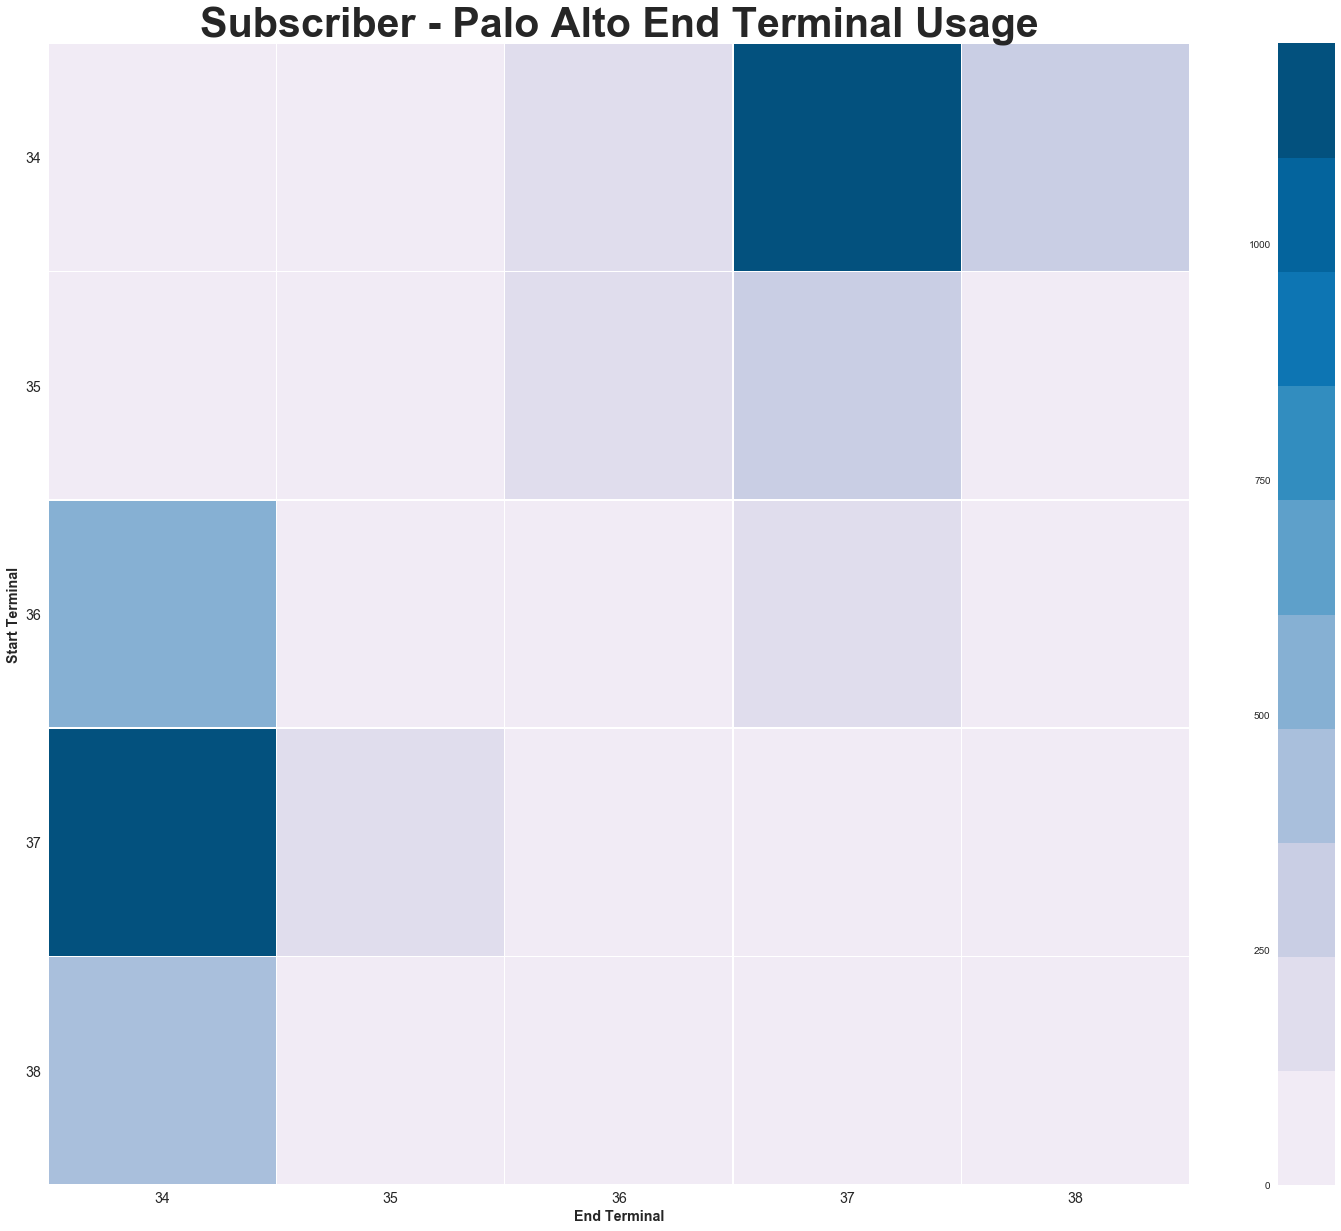

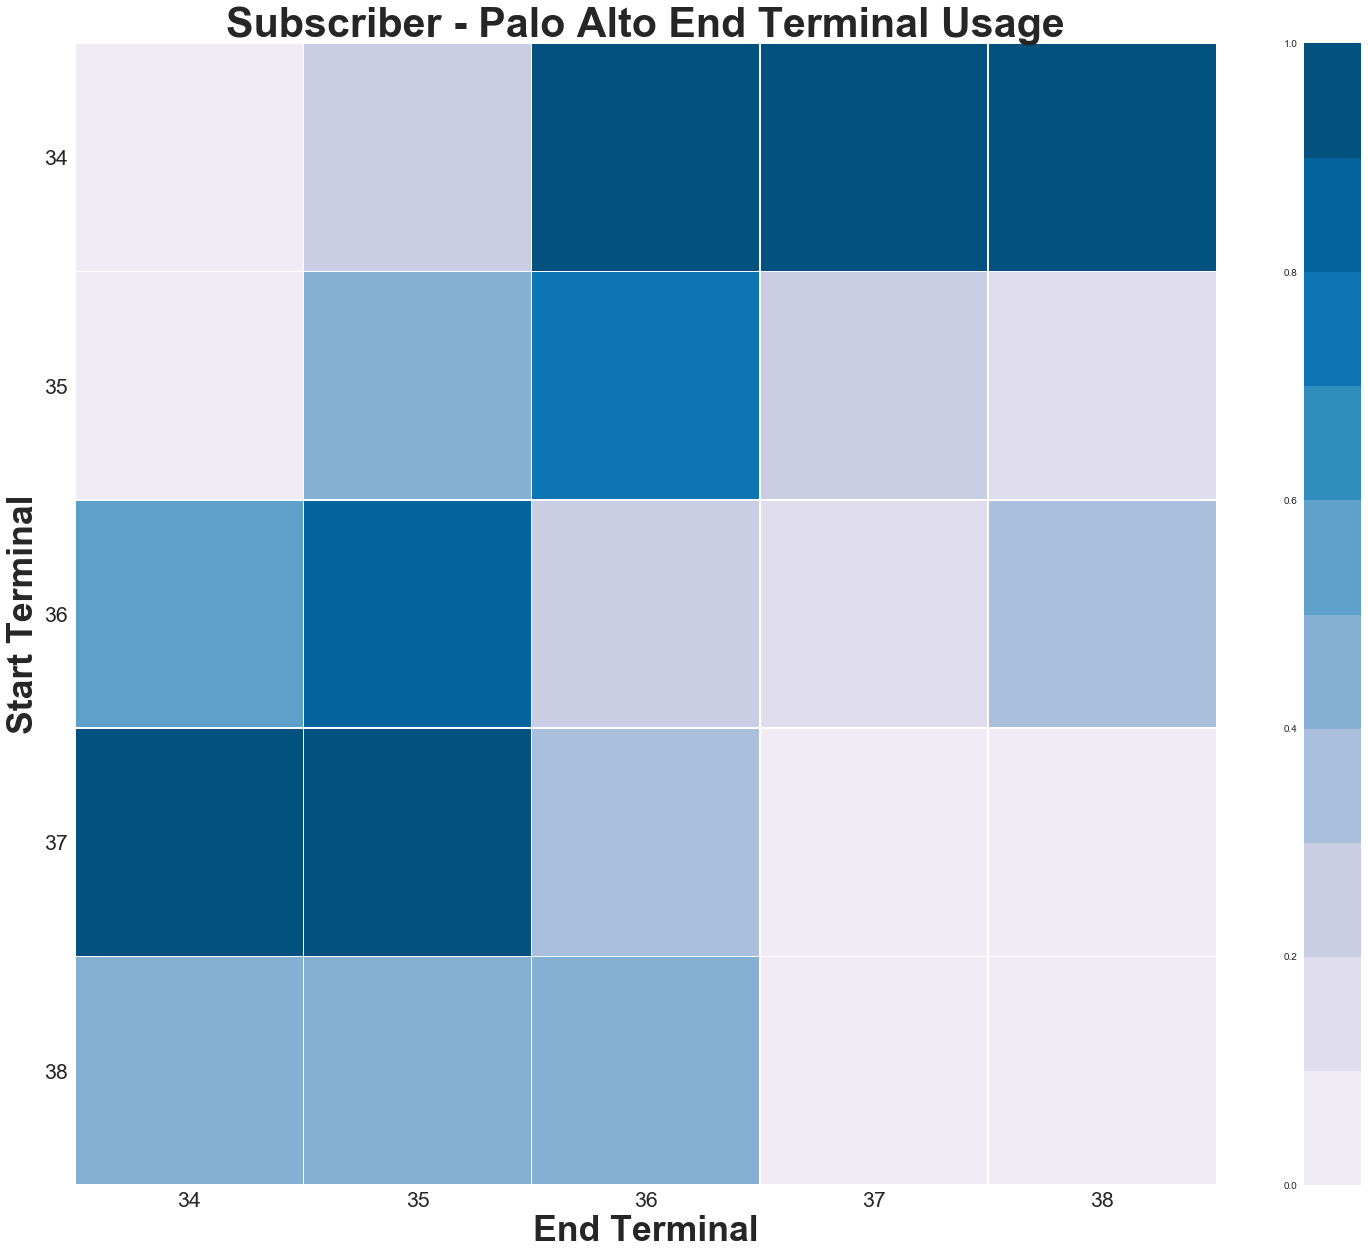

Total Trips in Palo Alto	5530	0.66


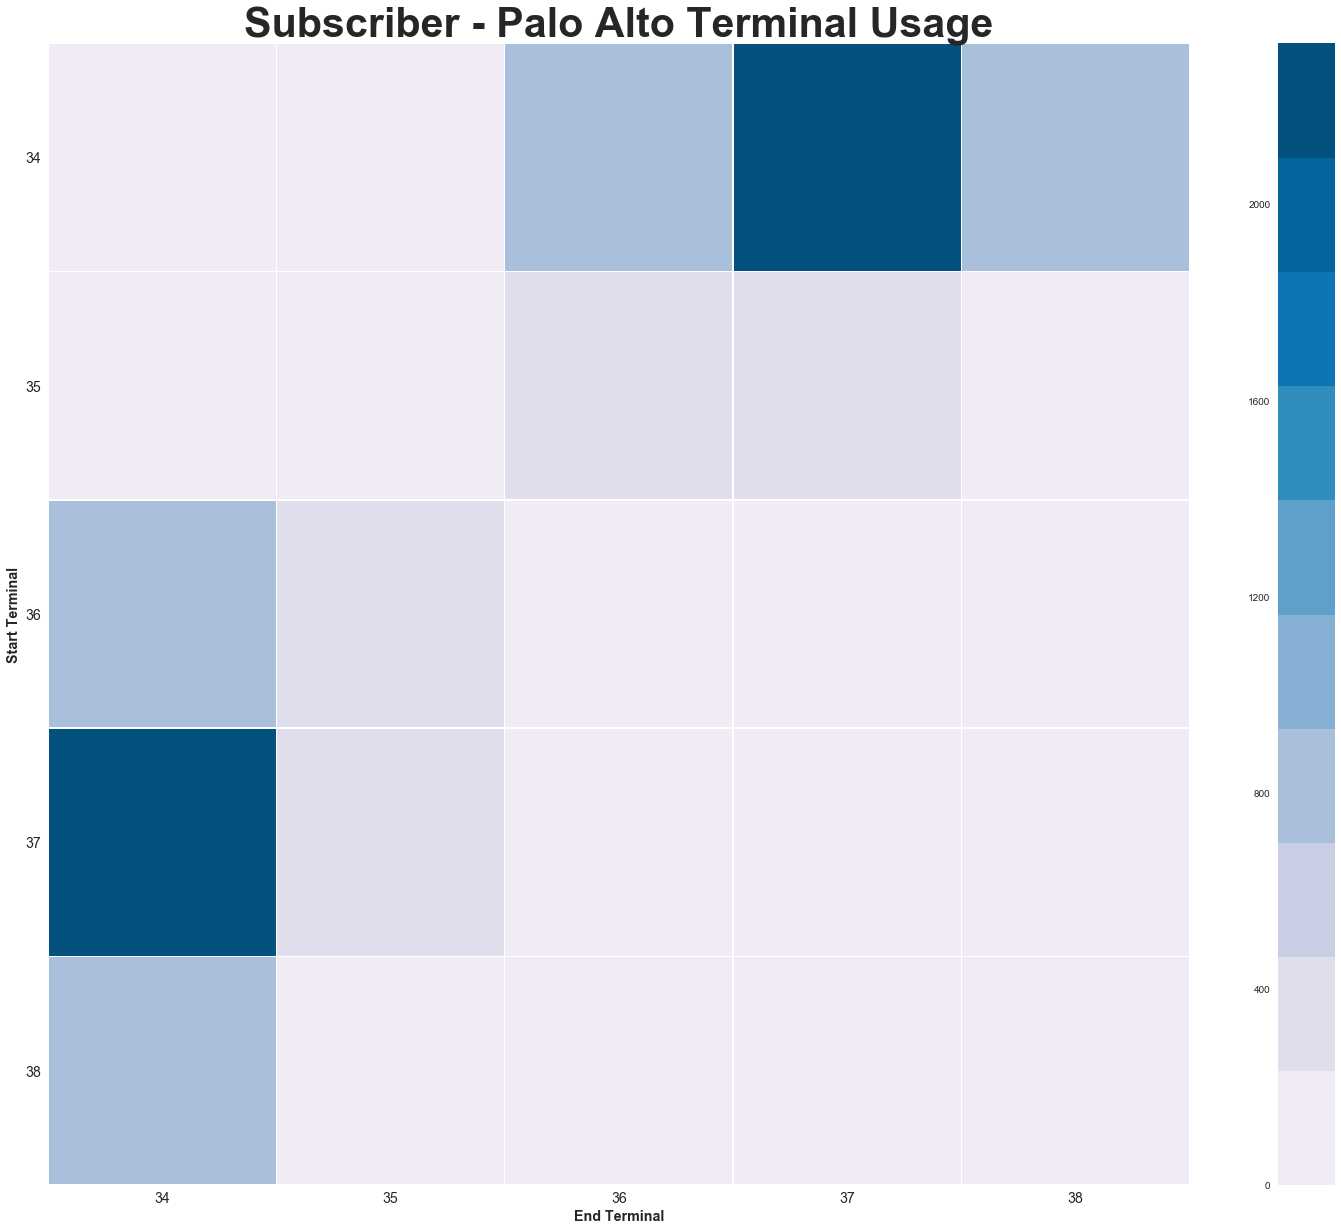

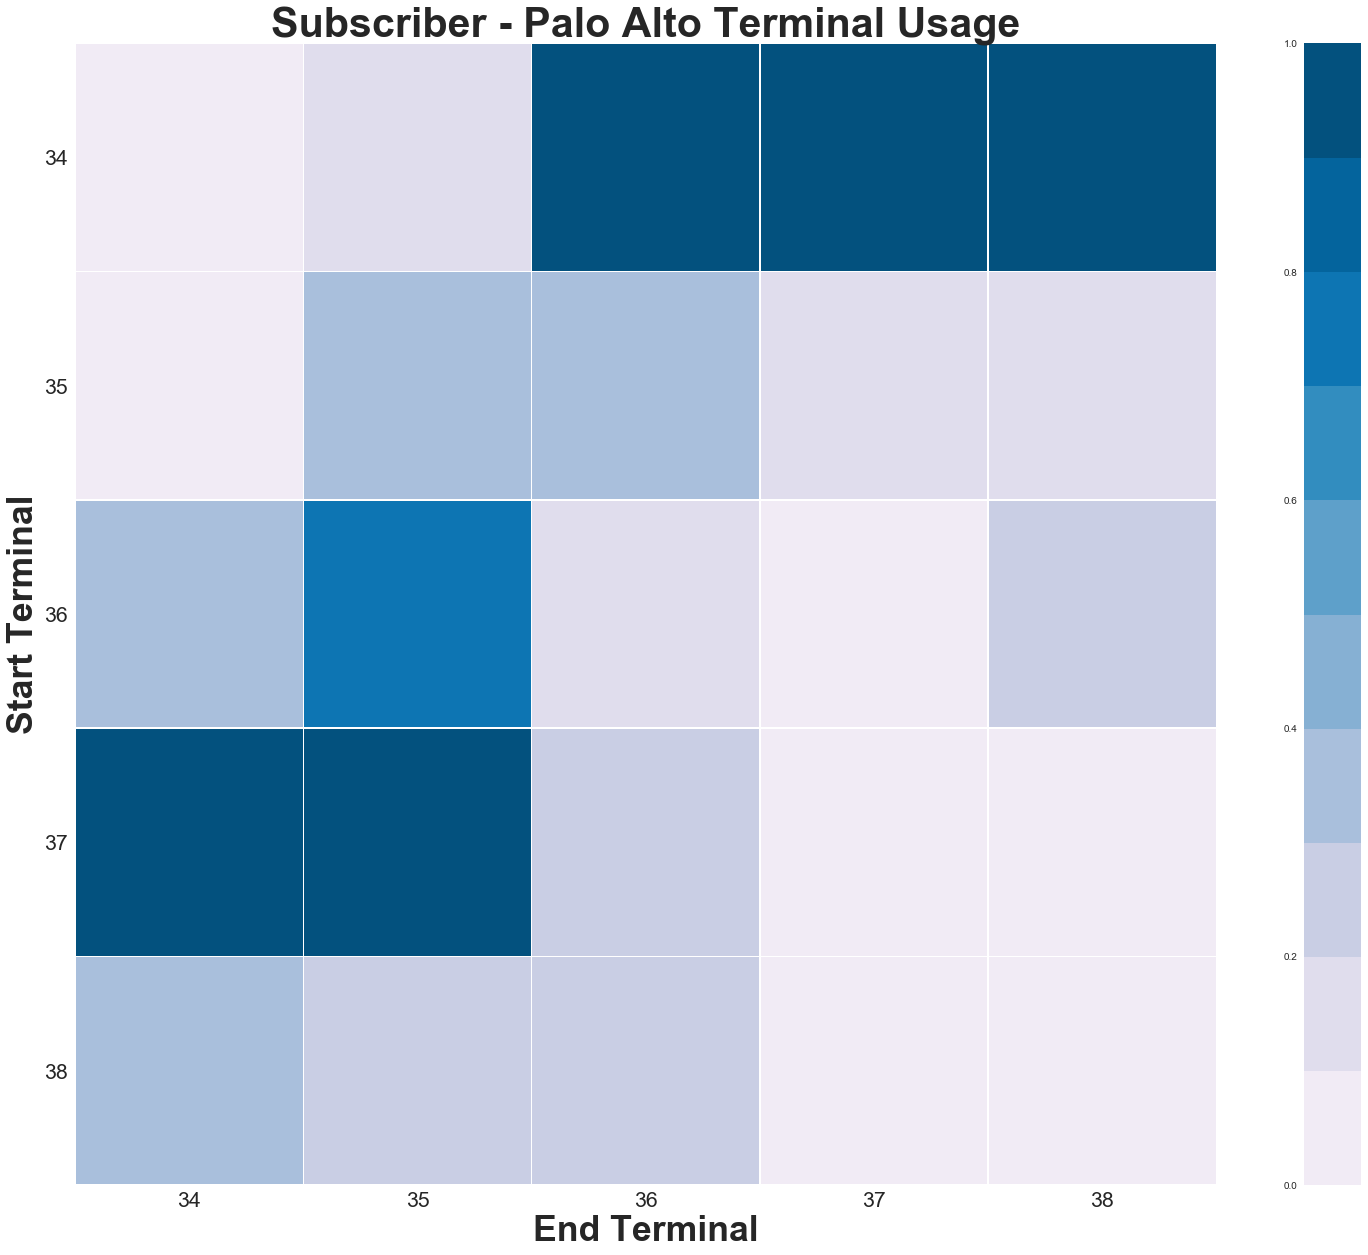

Total Trips in San Jose	43978	5.21


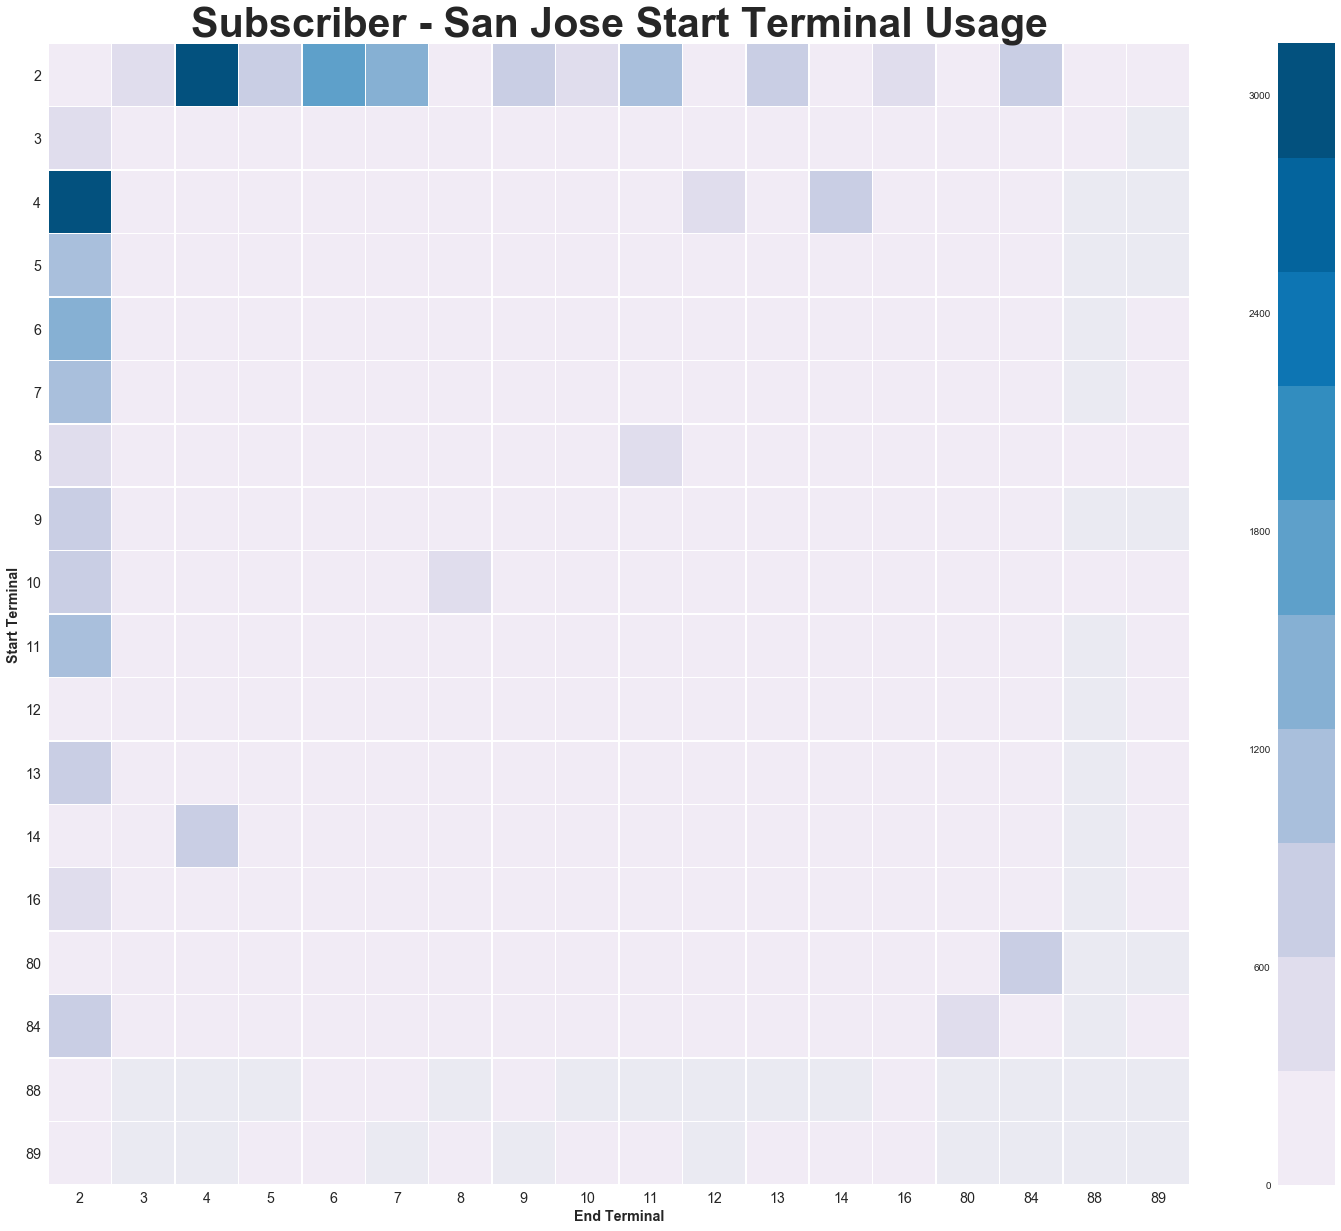

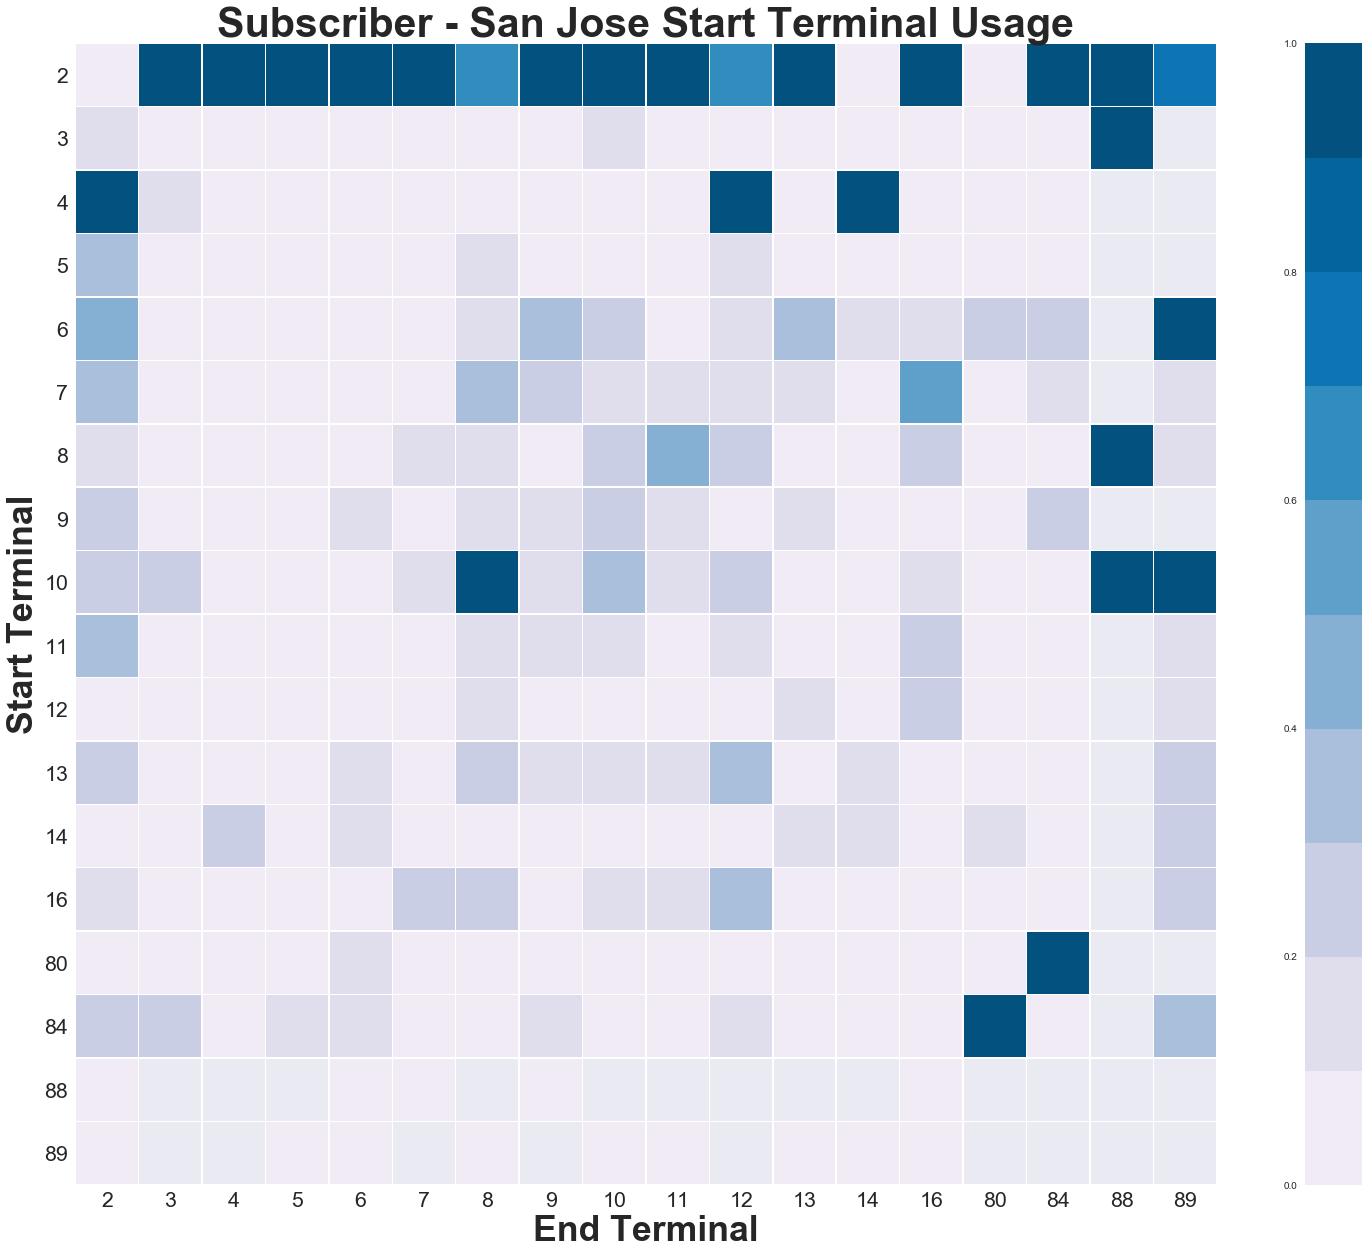

Total Trips in San Jose	43978	5.21


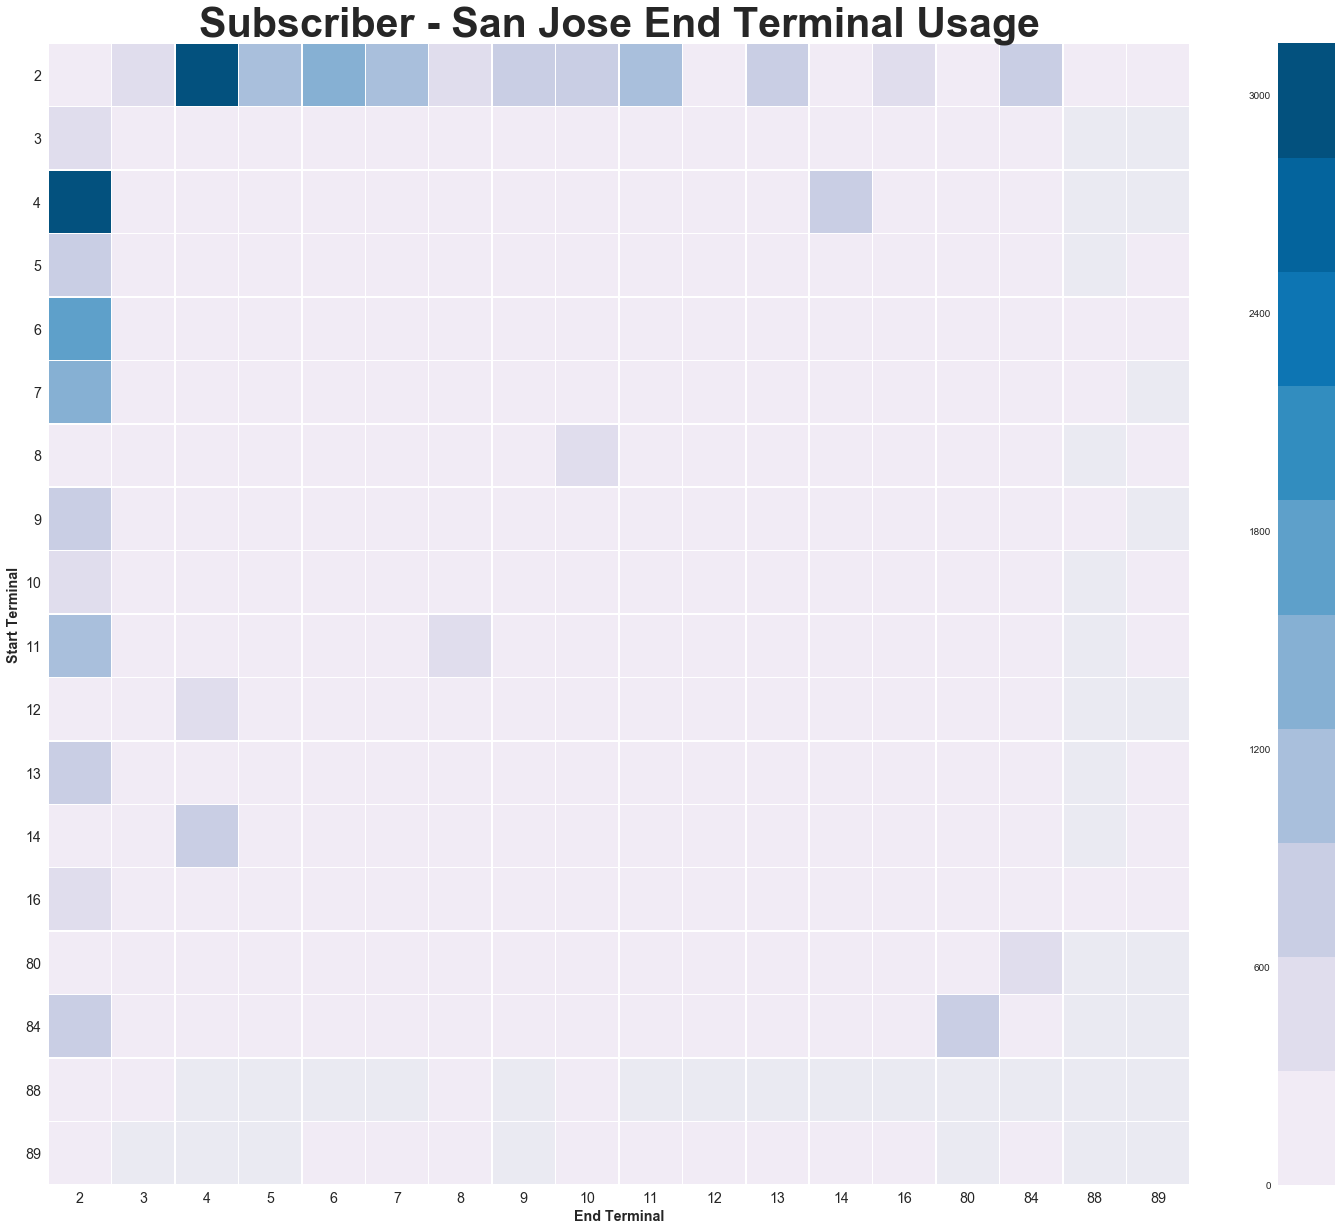

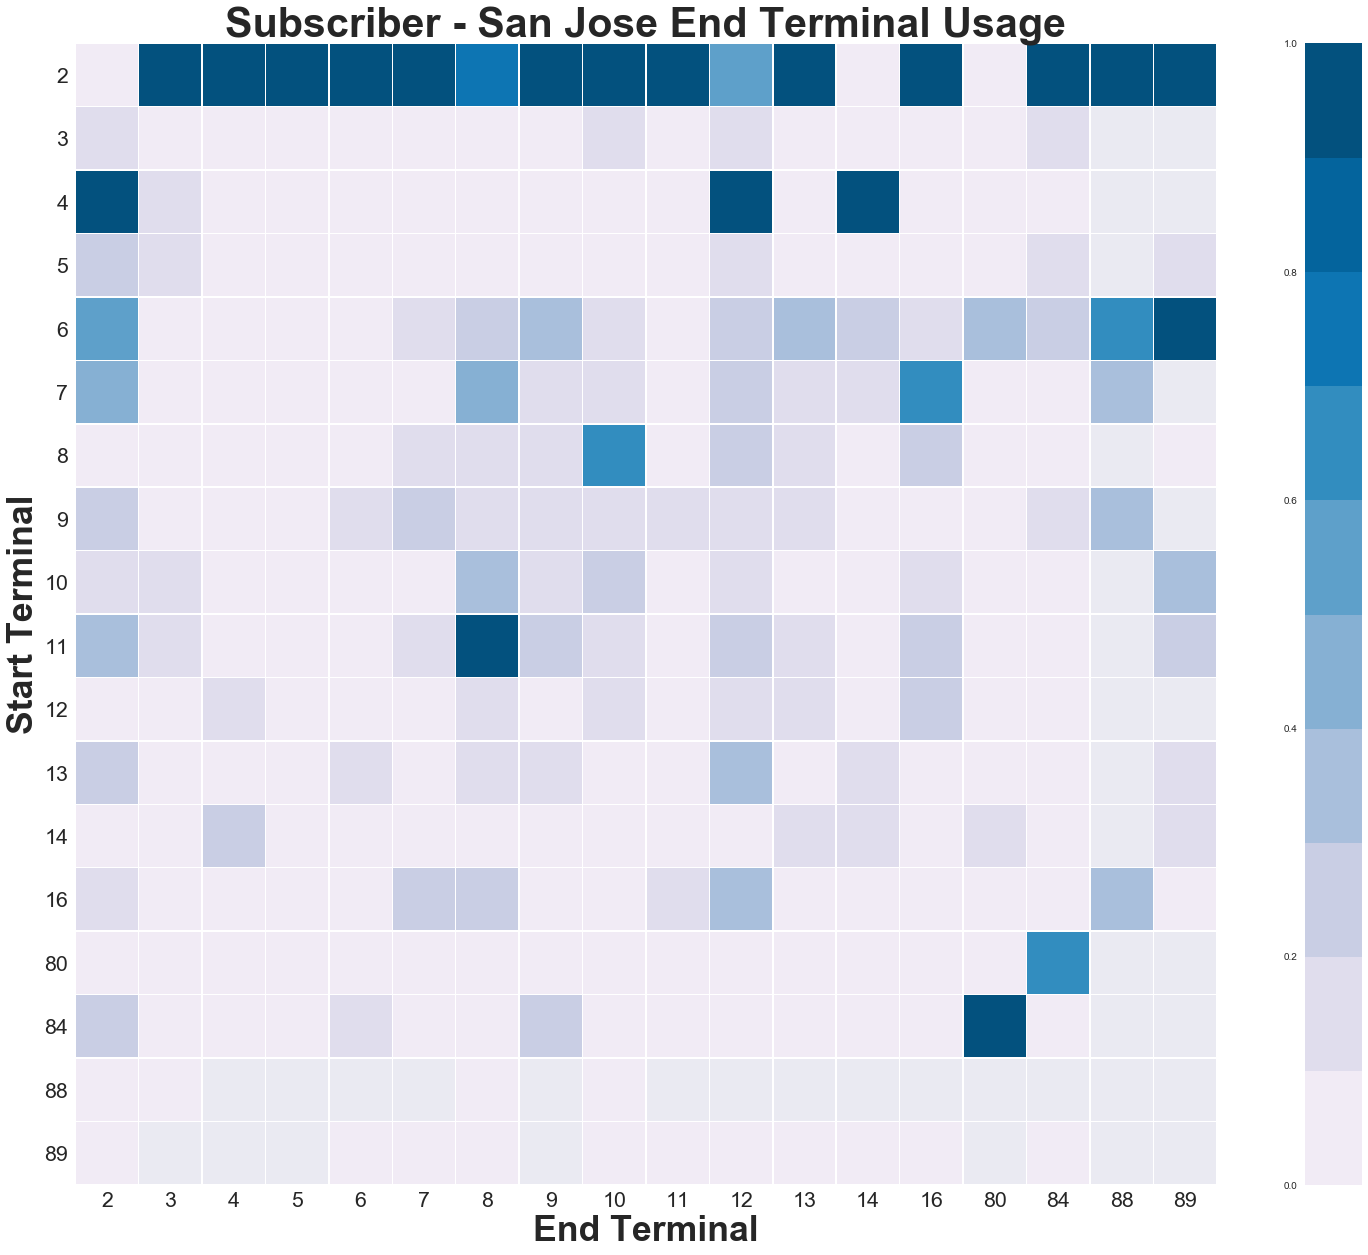

Total Trips in San Jose	43978	5.21


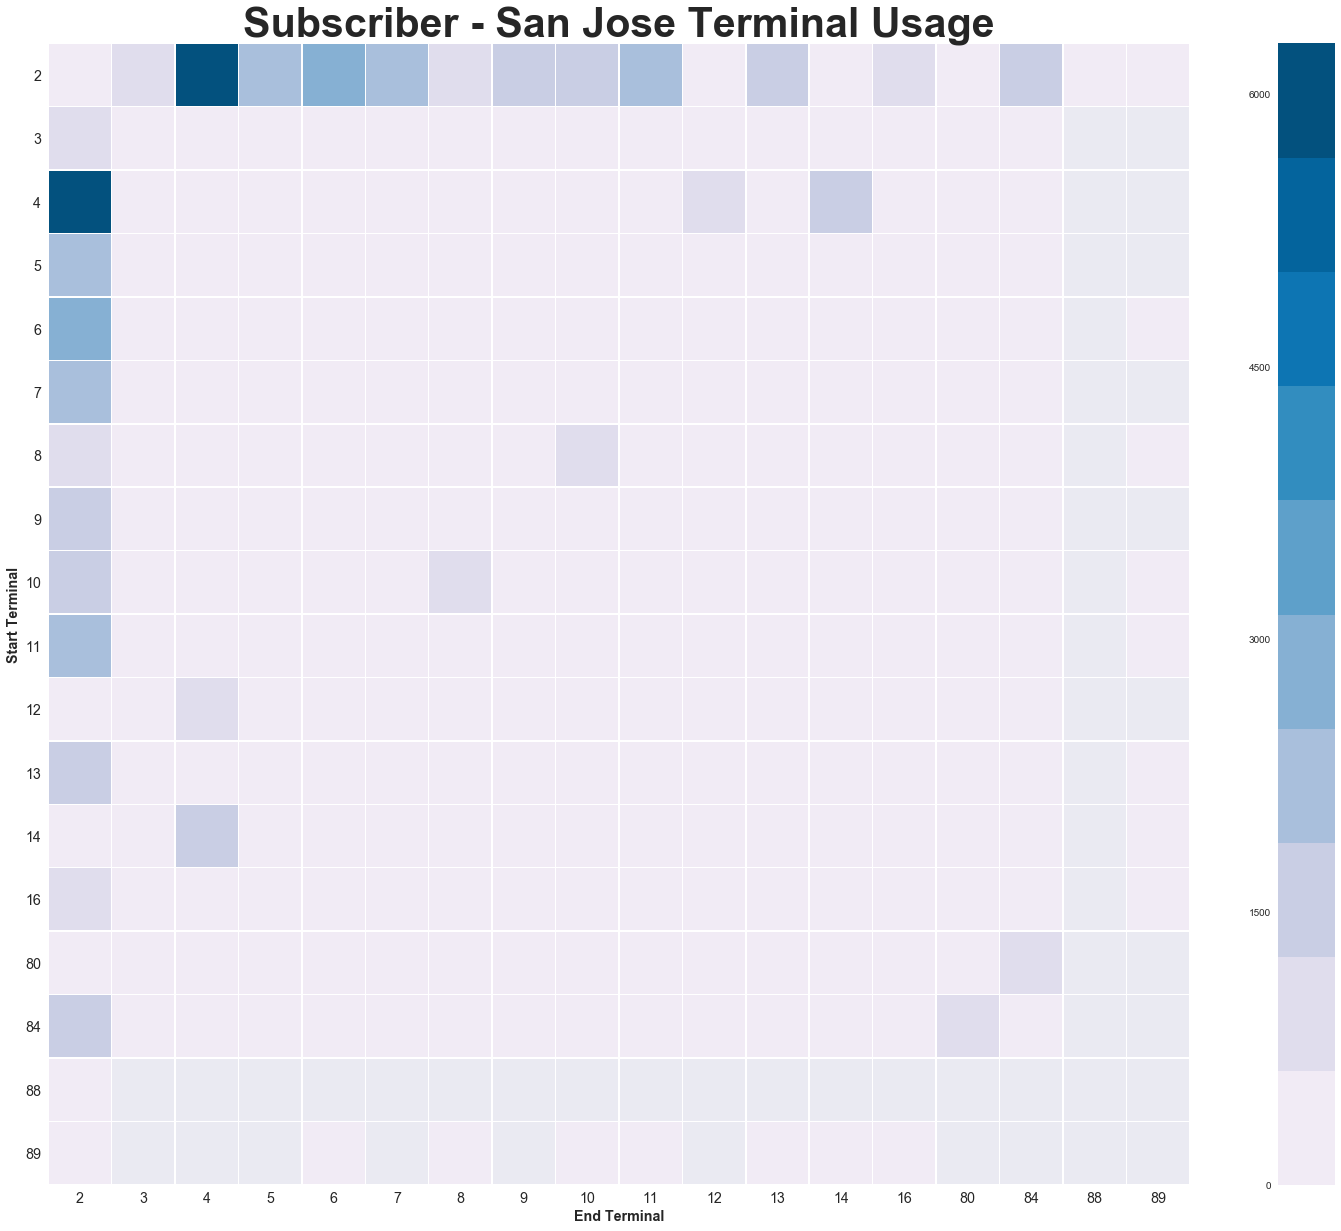

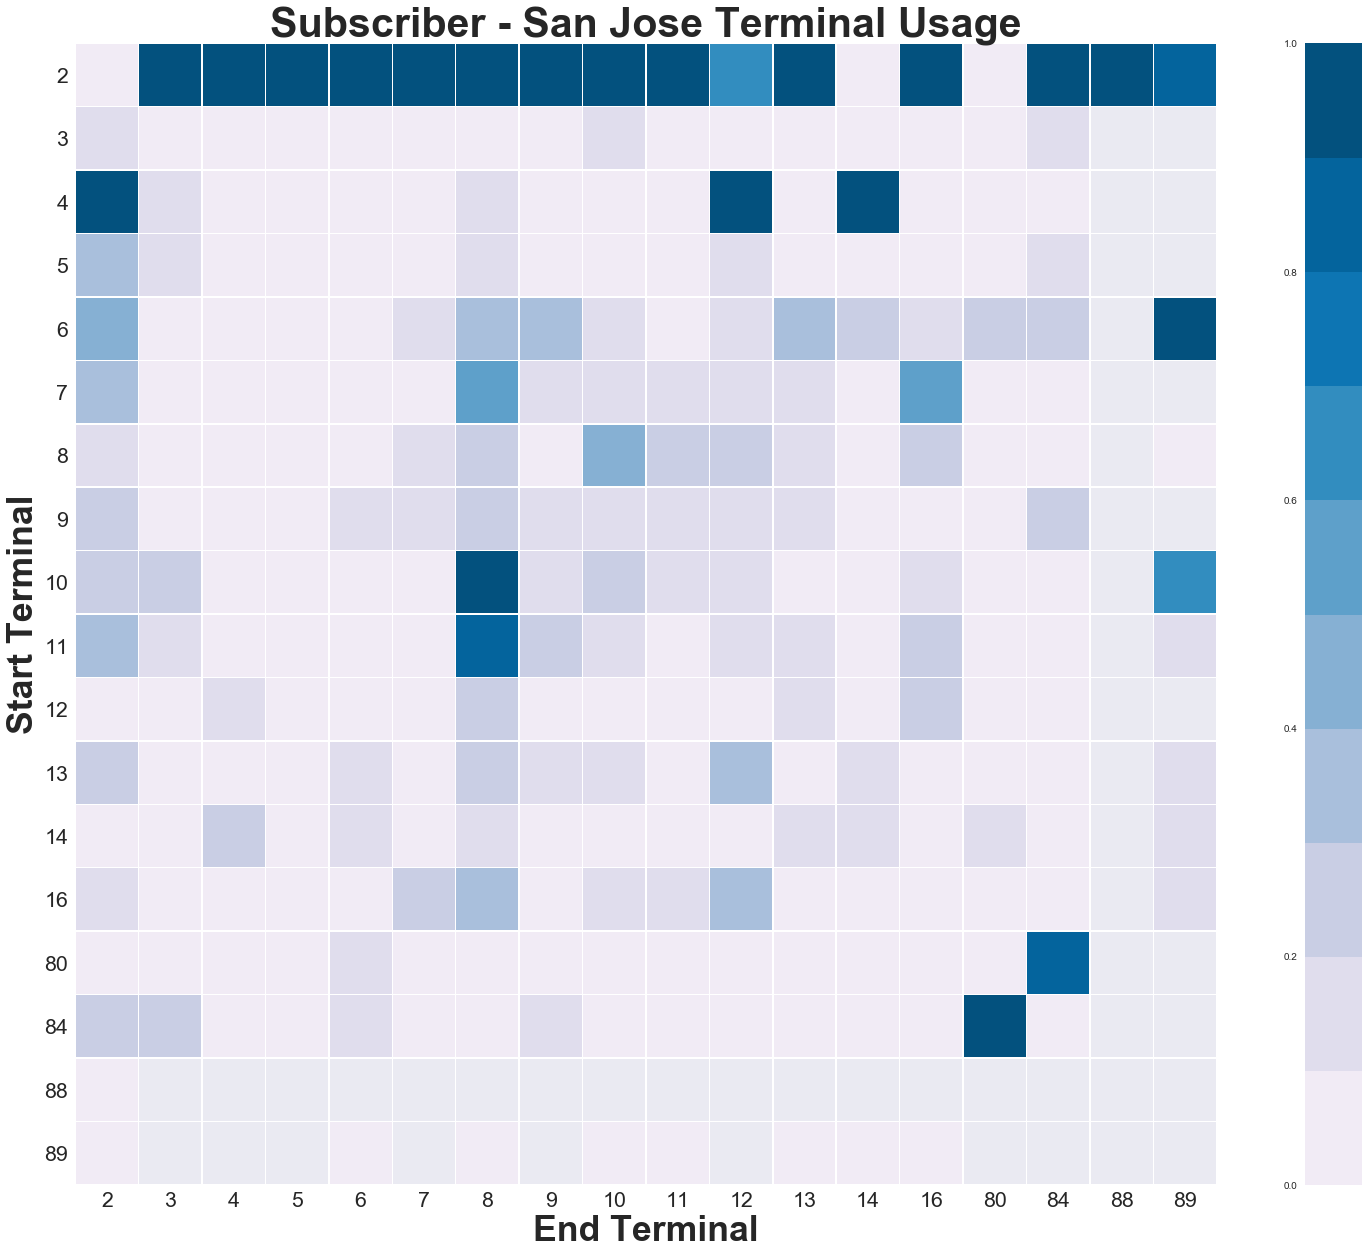

In [465]:
heatmap_regonalized_trips(trip_data, user_type='Subscriber')

### Customer Terminal Usage - By Region

Regional Terminal Usage		 110524
Non Regional Terminal Usage	    463		0.42
--------------------------------------------------------------------------------
Total Trips in Mountain View	2392	2.16


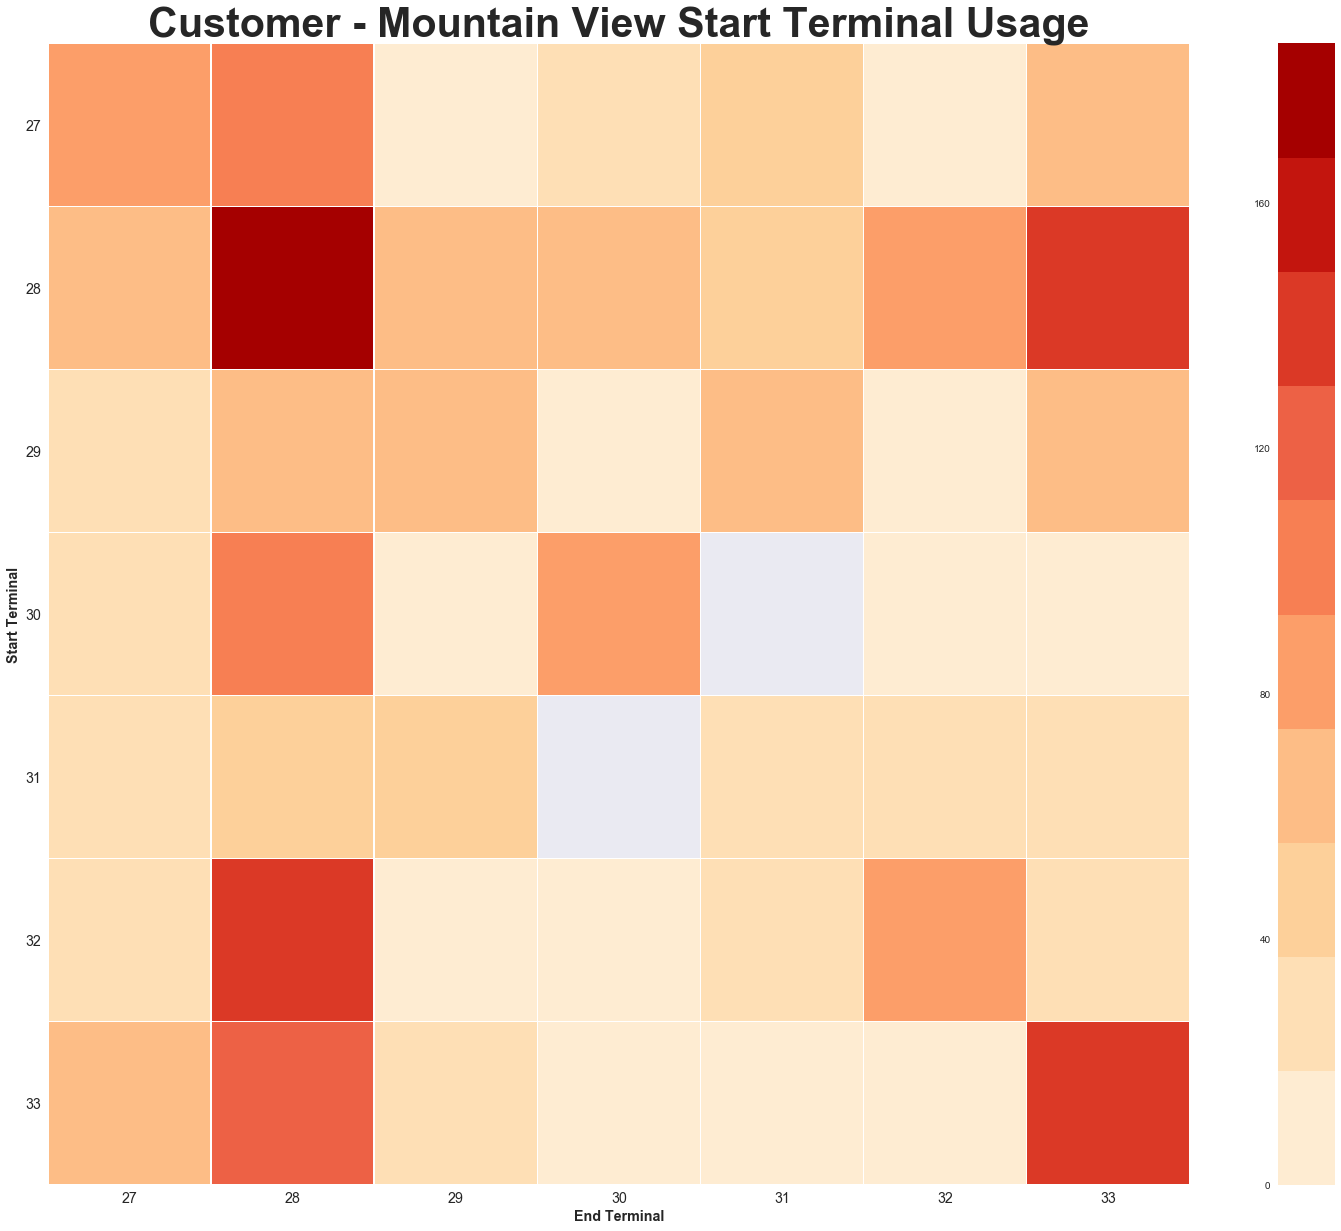

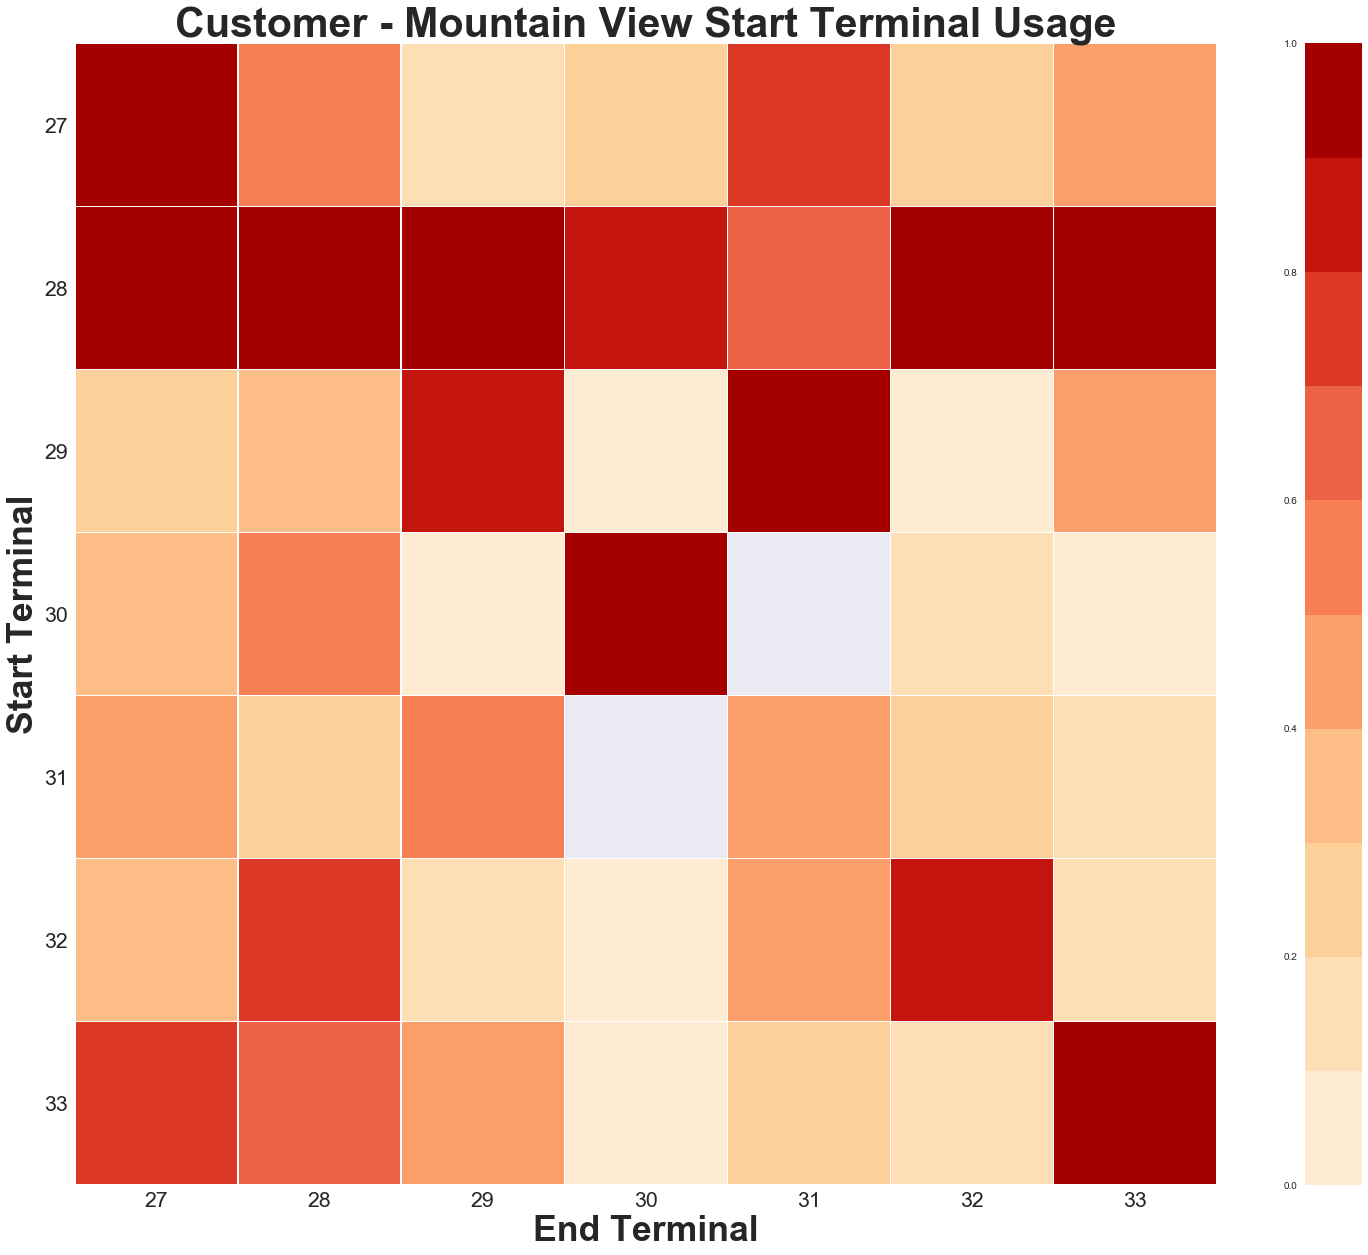

Total Trips in Mountain View	2392	2.16


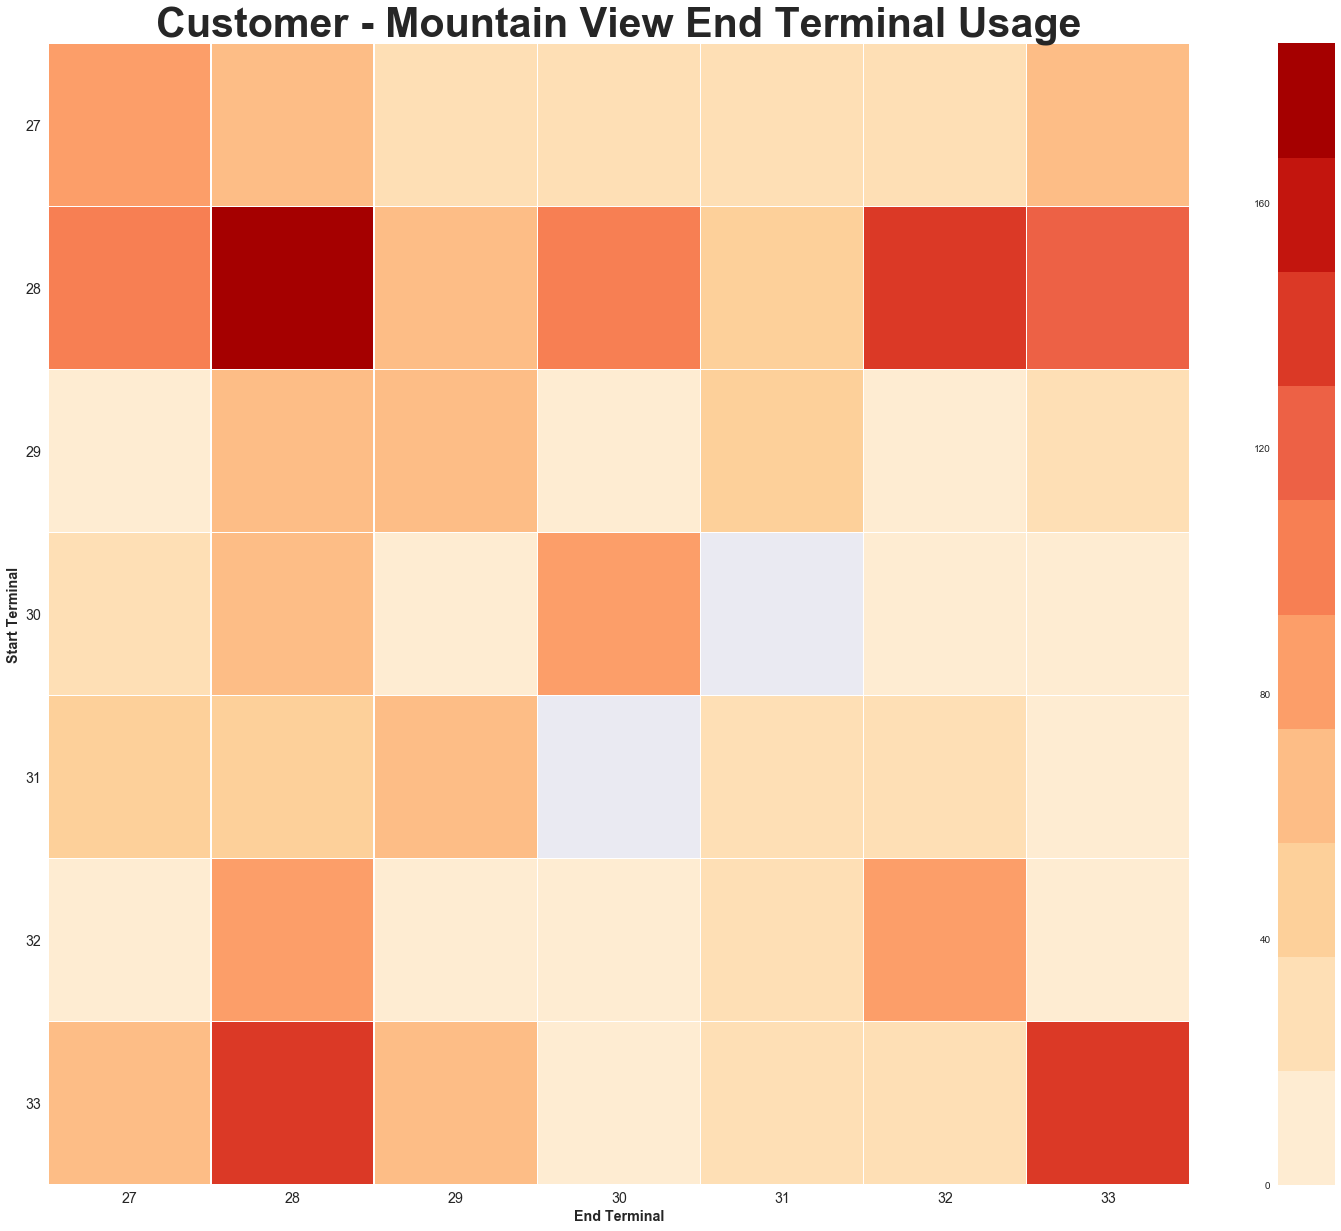

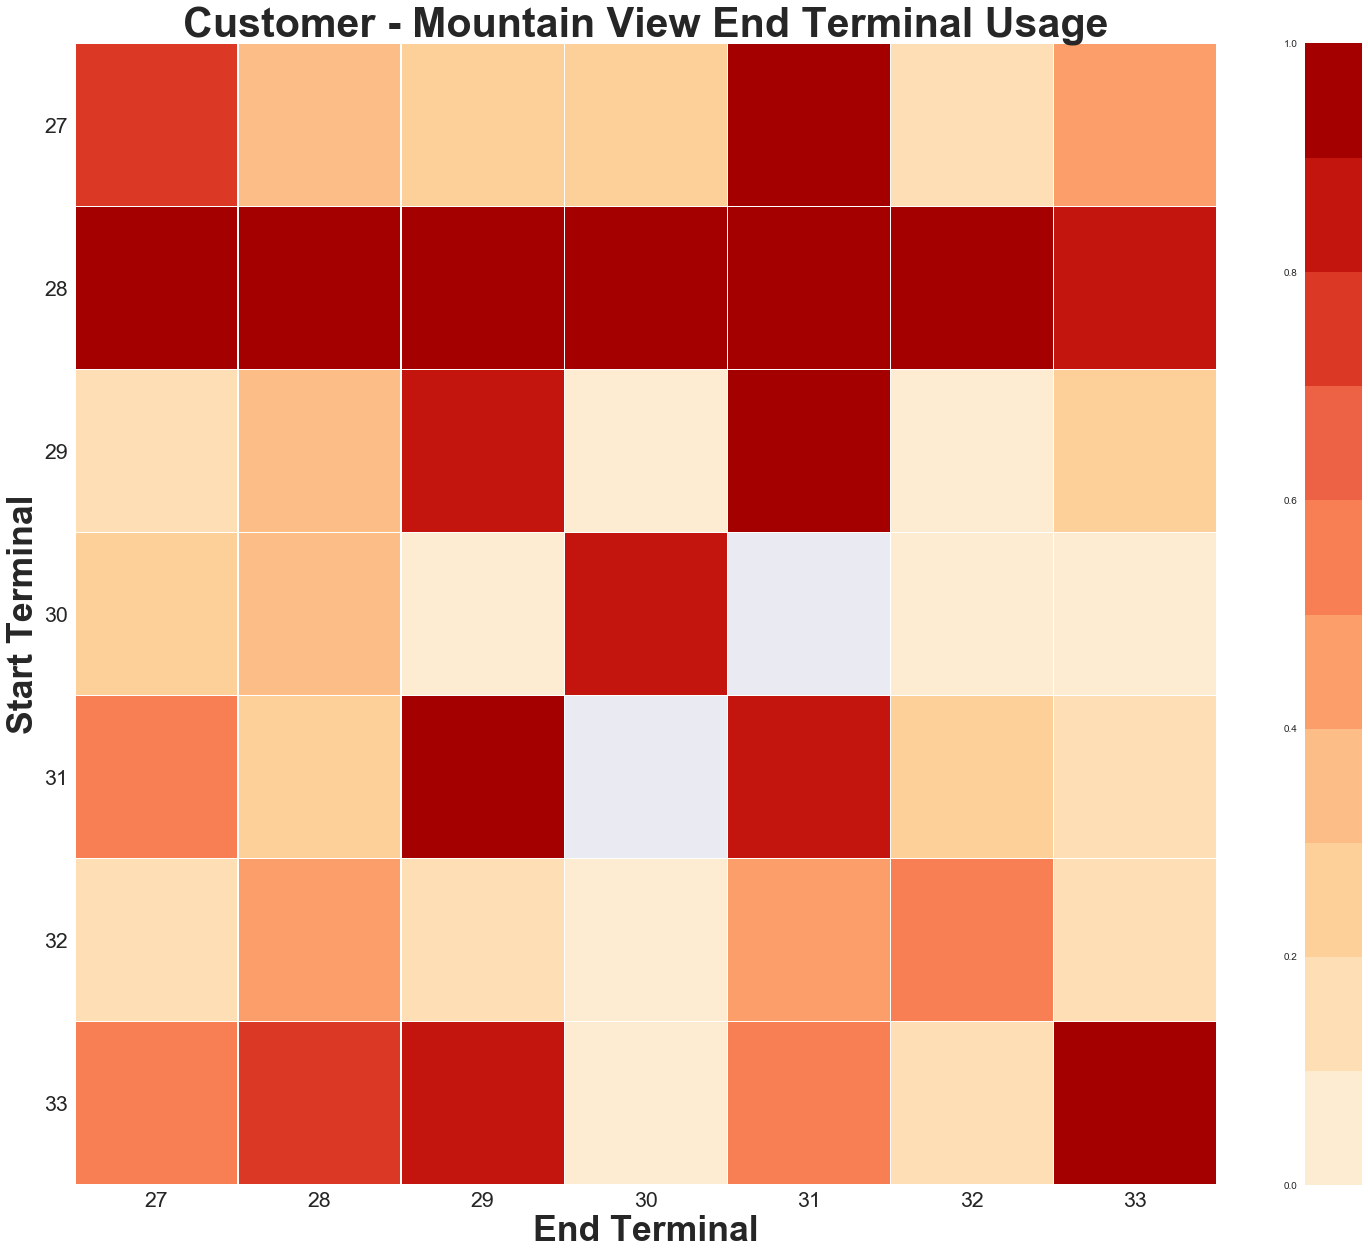

Total Trips in Mountain View	2392	2.16


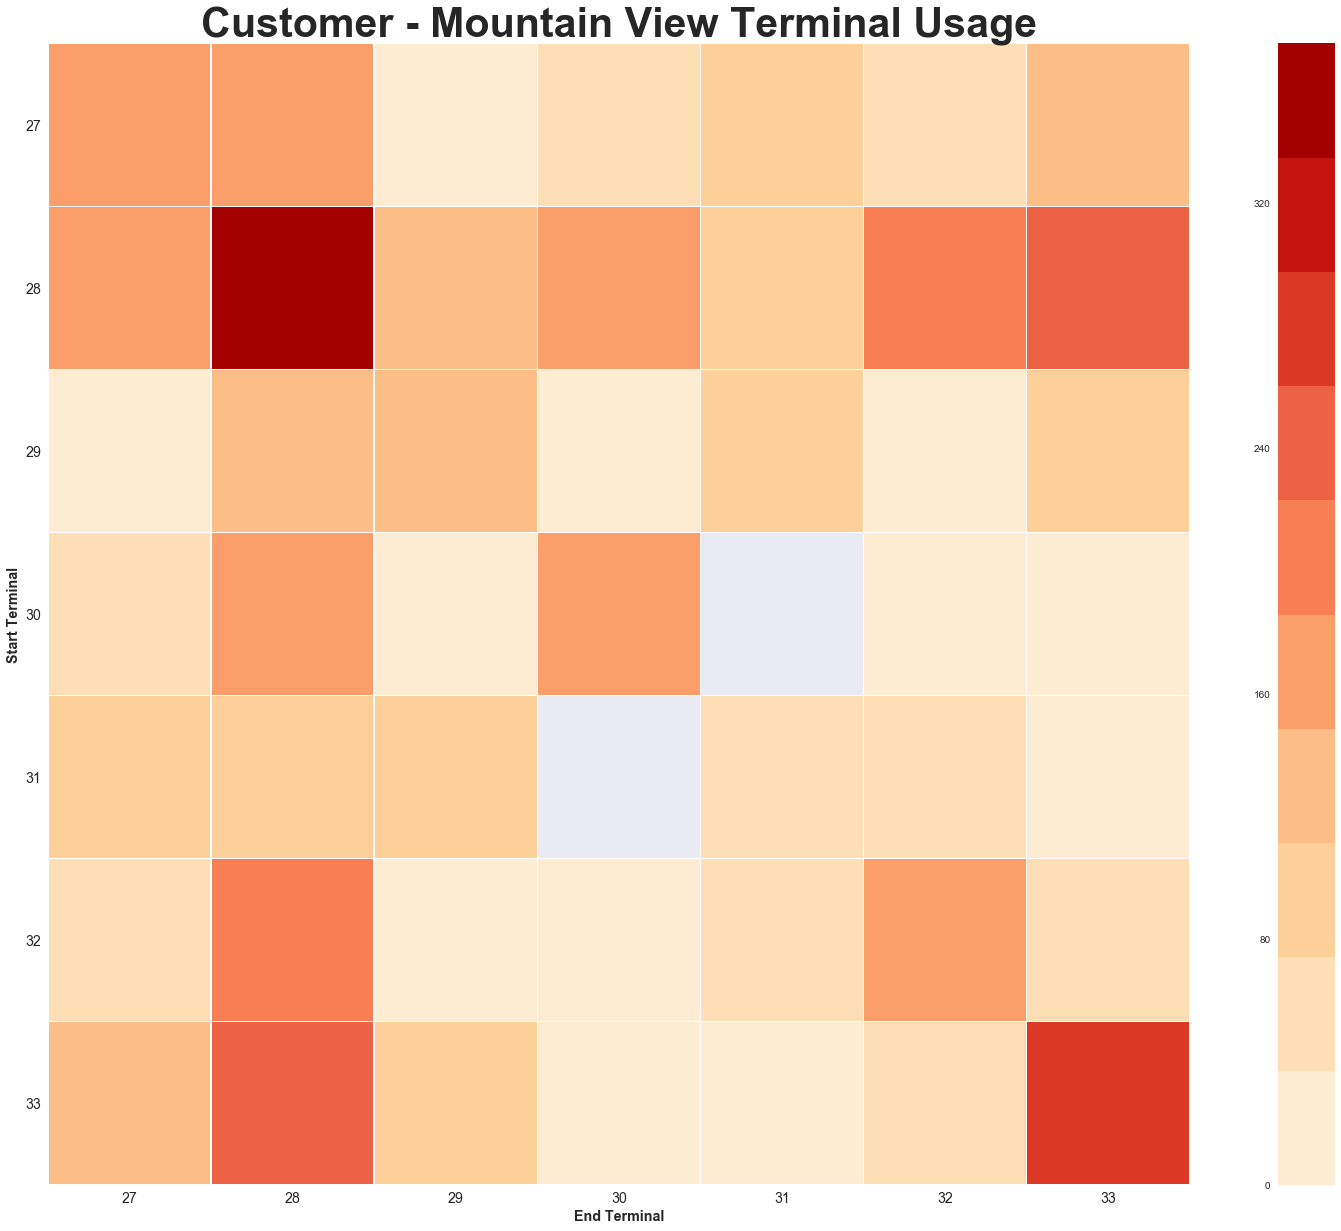

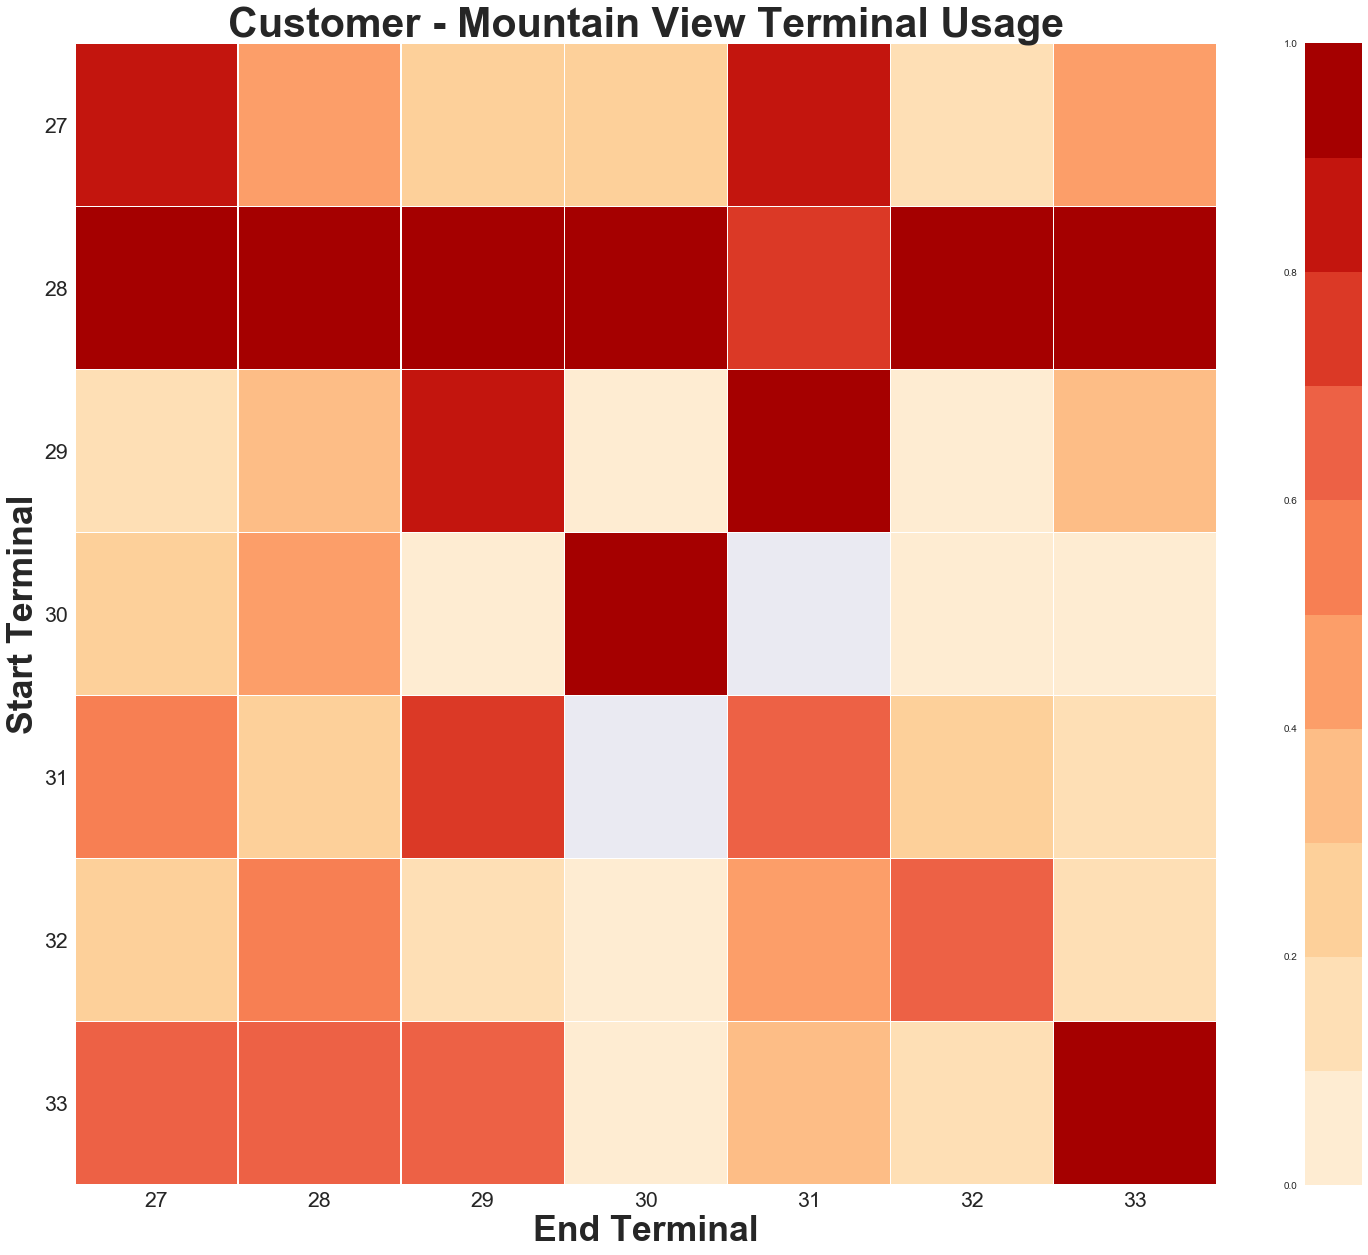

Total Trips in Redwood City	506	0.46


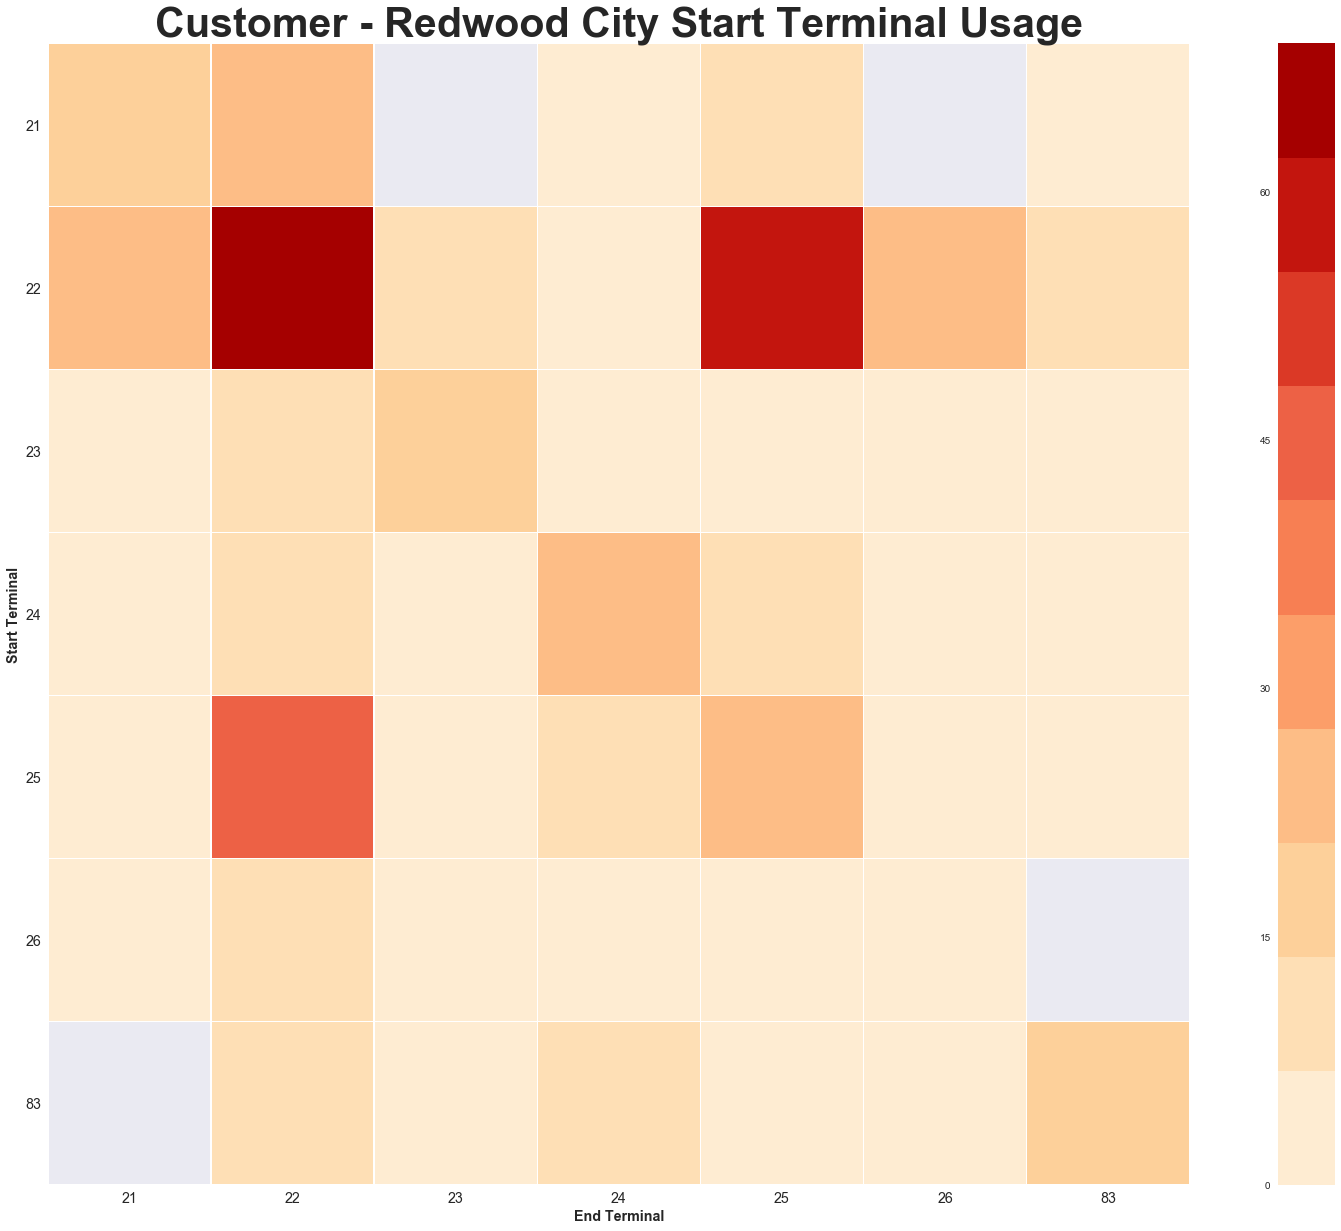

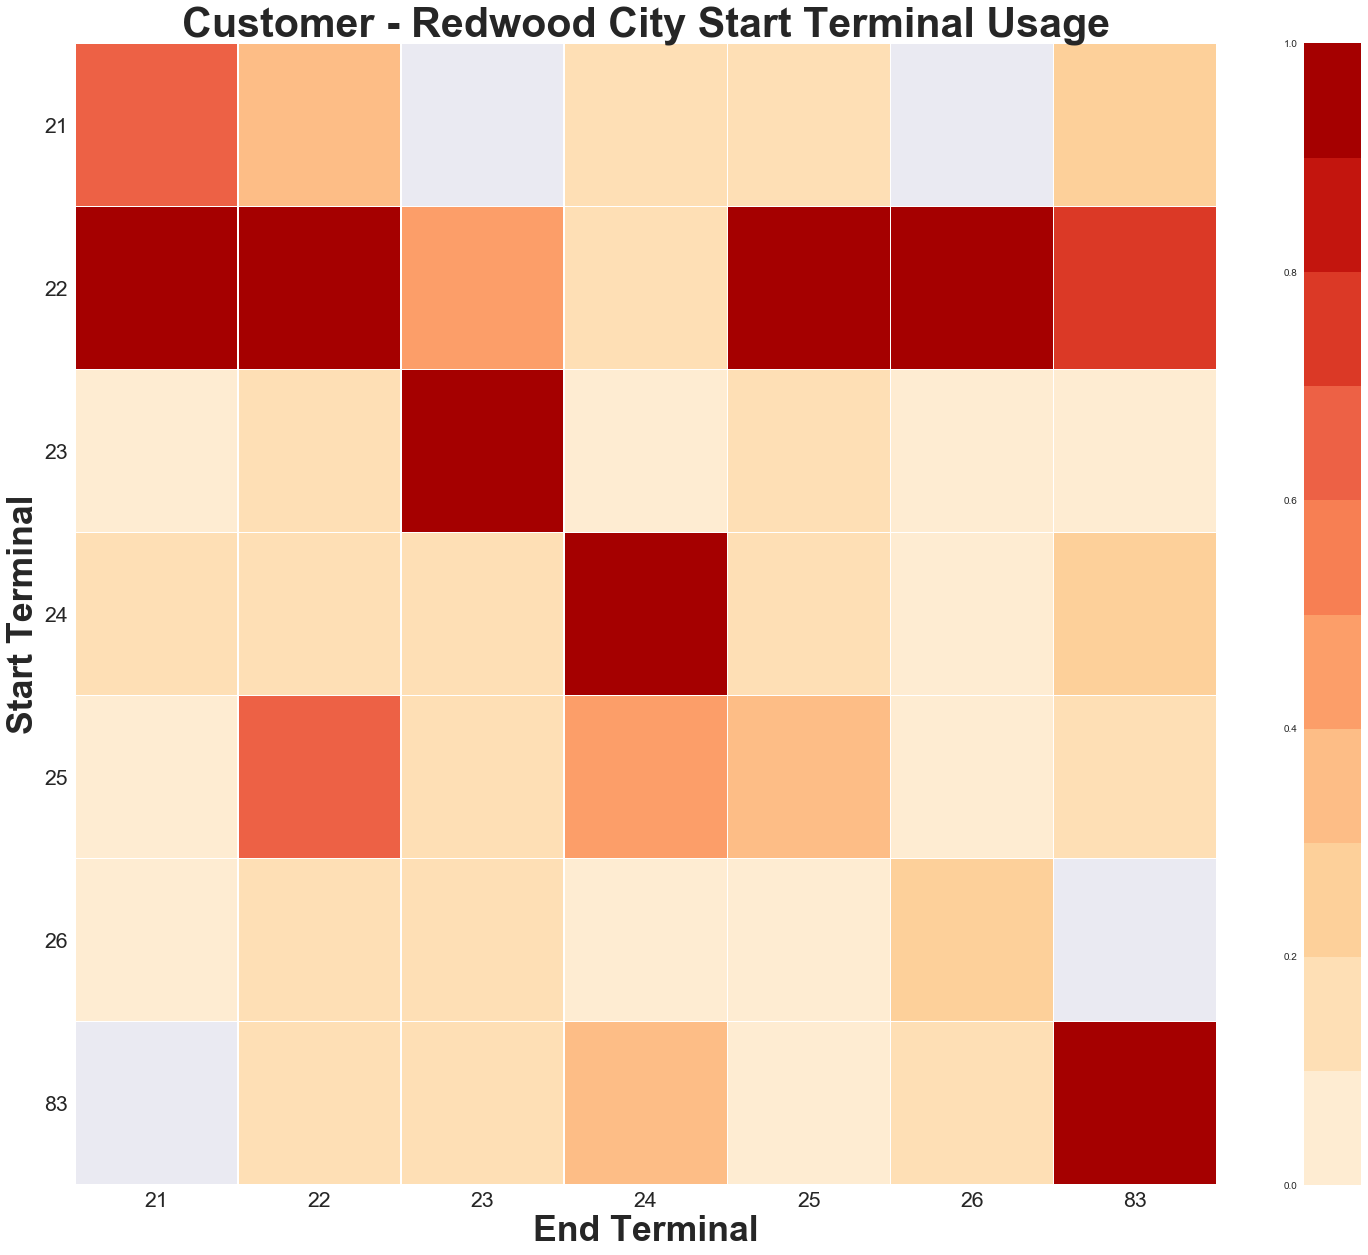

Total Trips in Redwood City	506	0.46


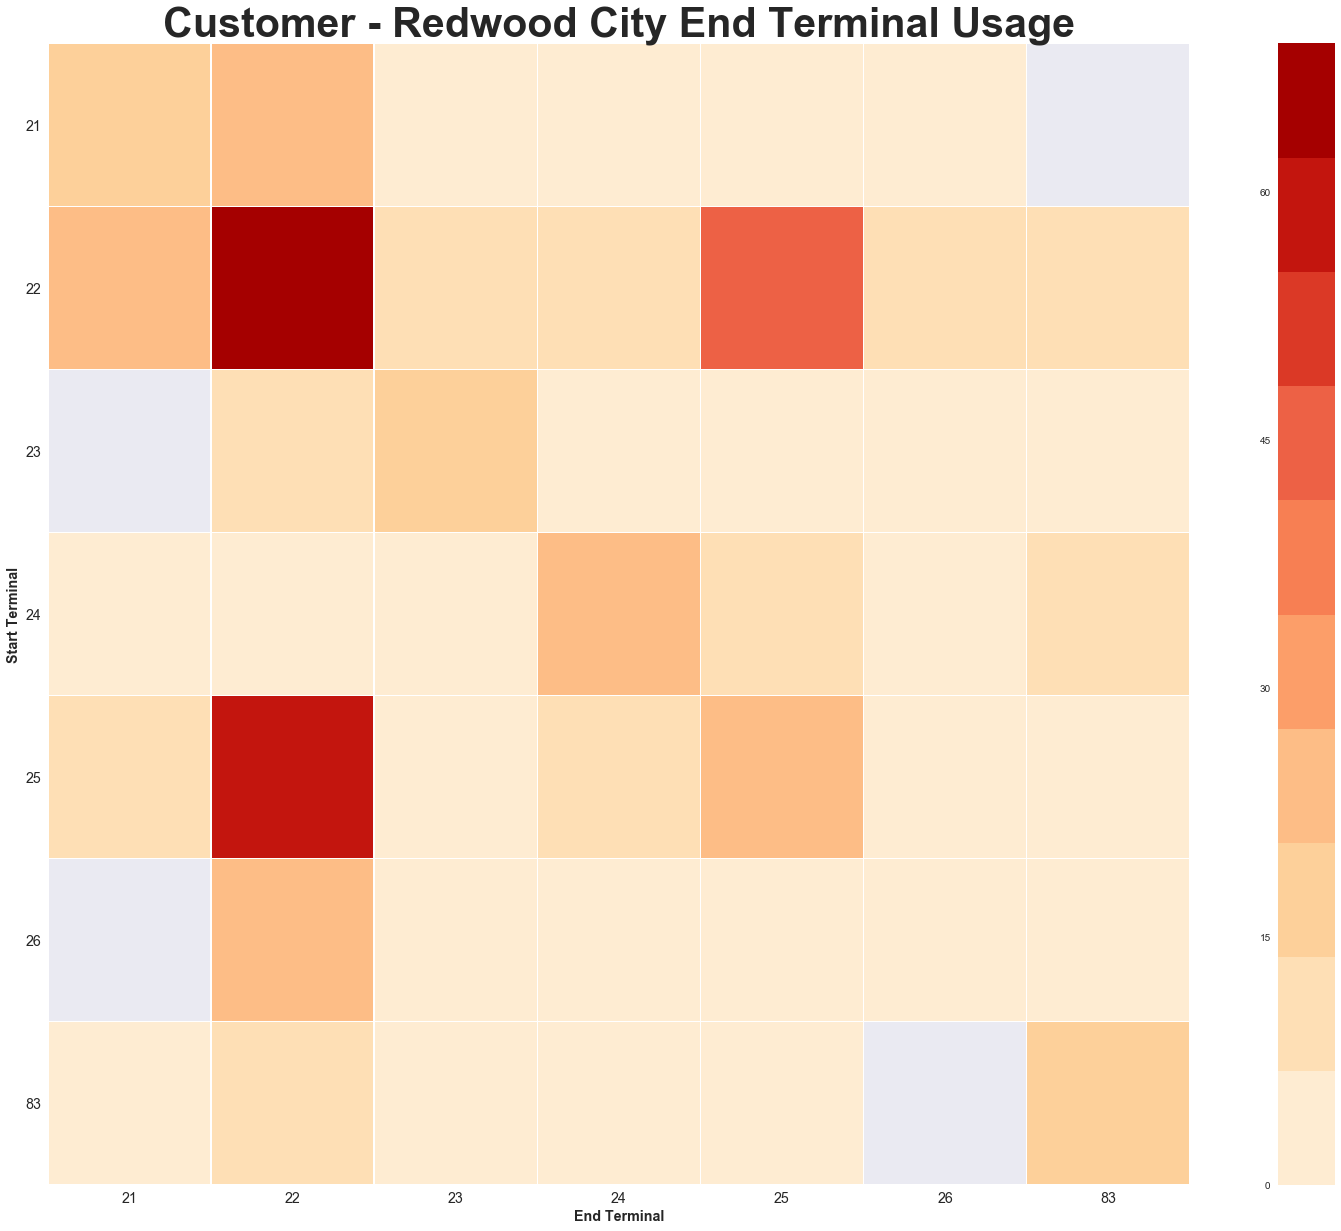

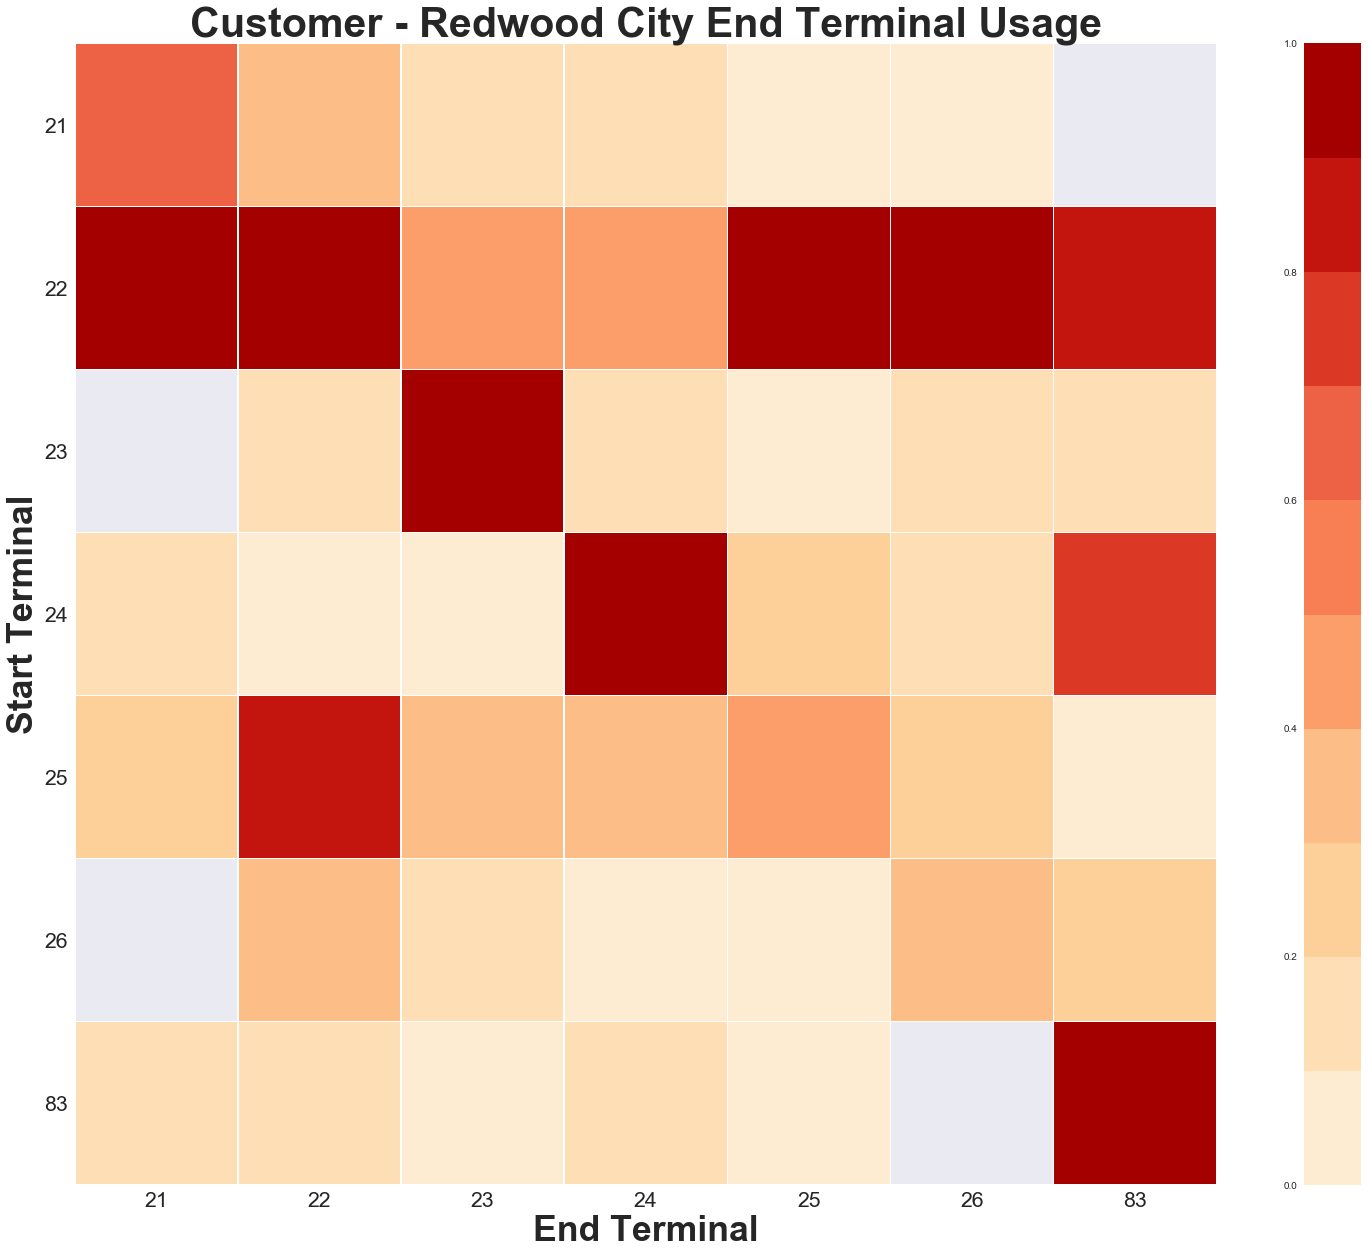

Total Trips in Redwood City	506	0.46


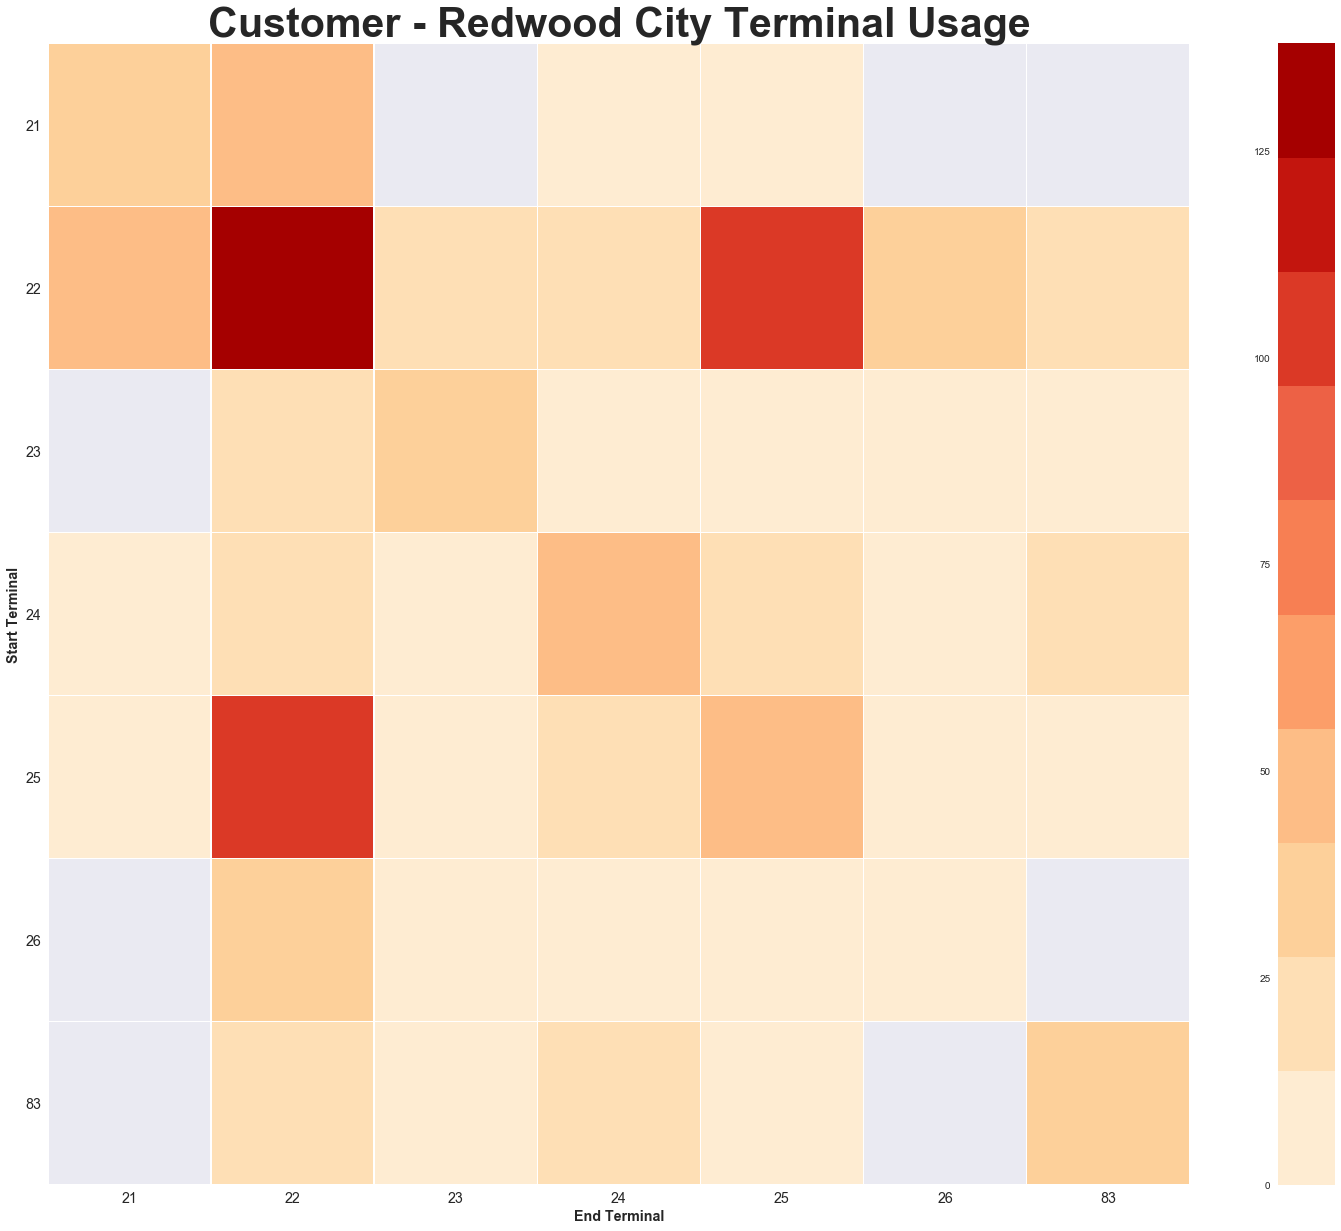

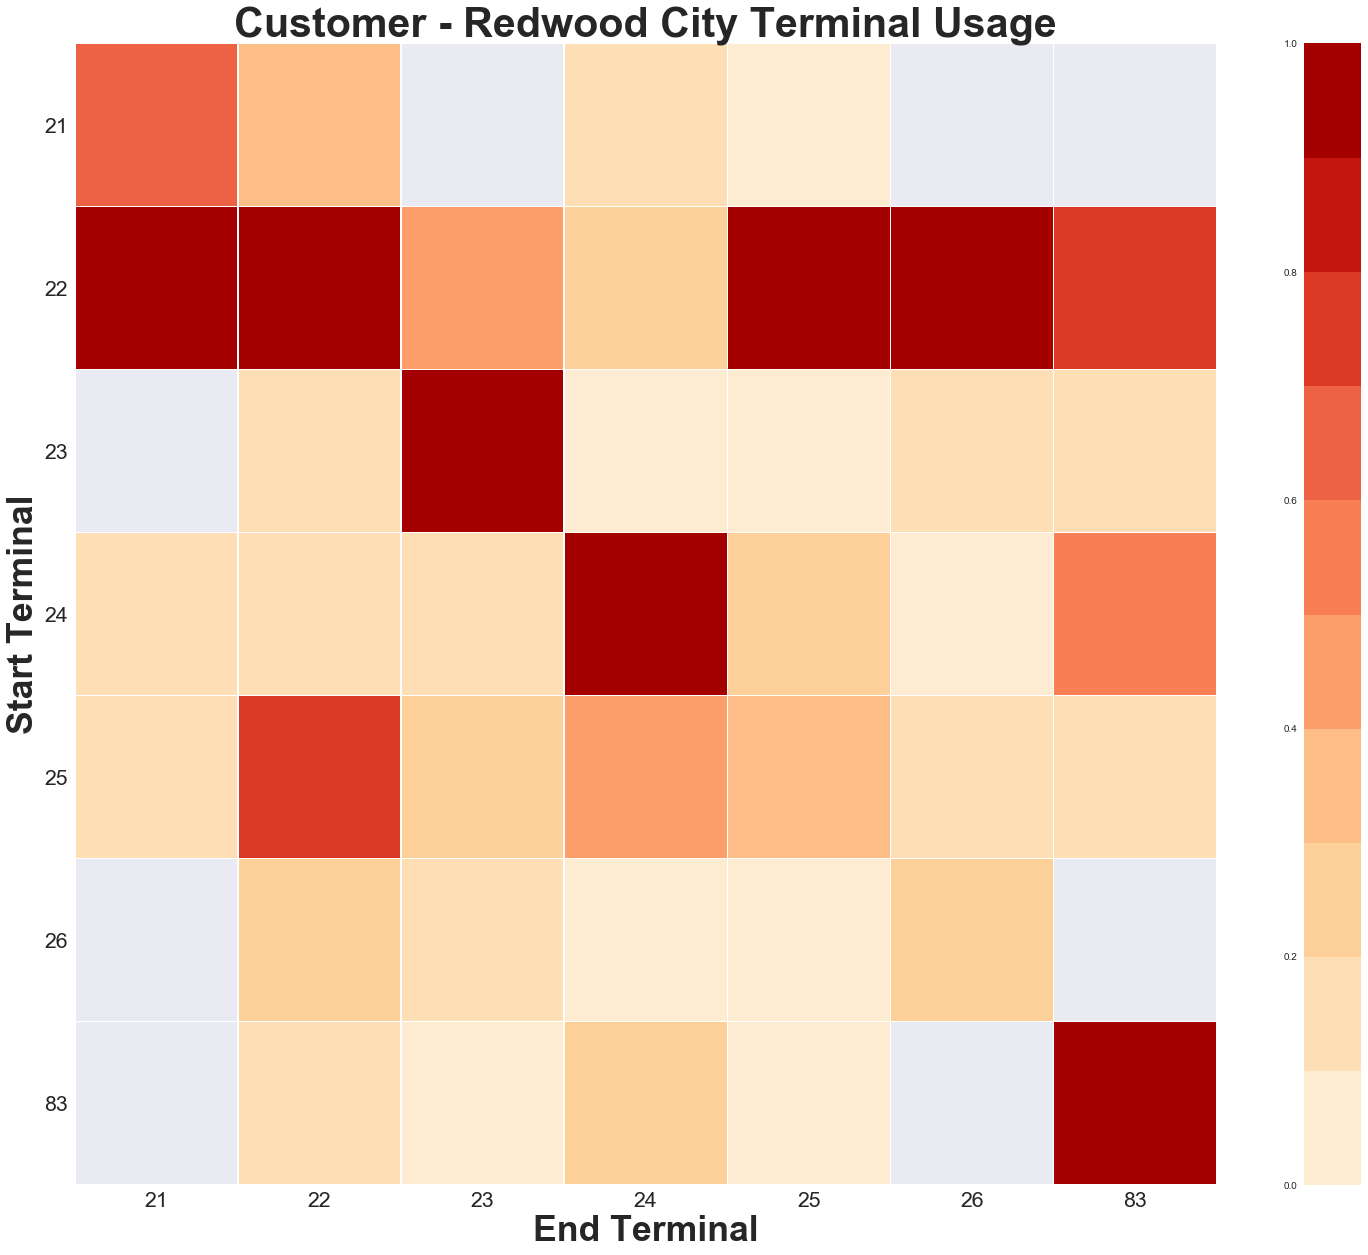

Total Trips in San Francisco	98531	89.15


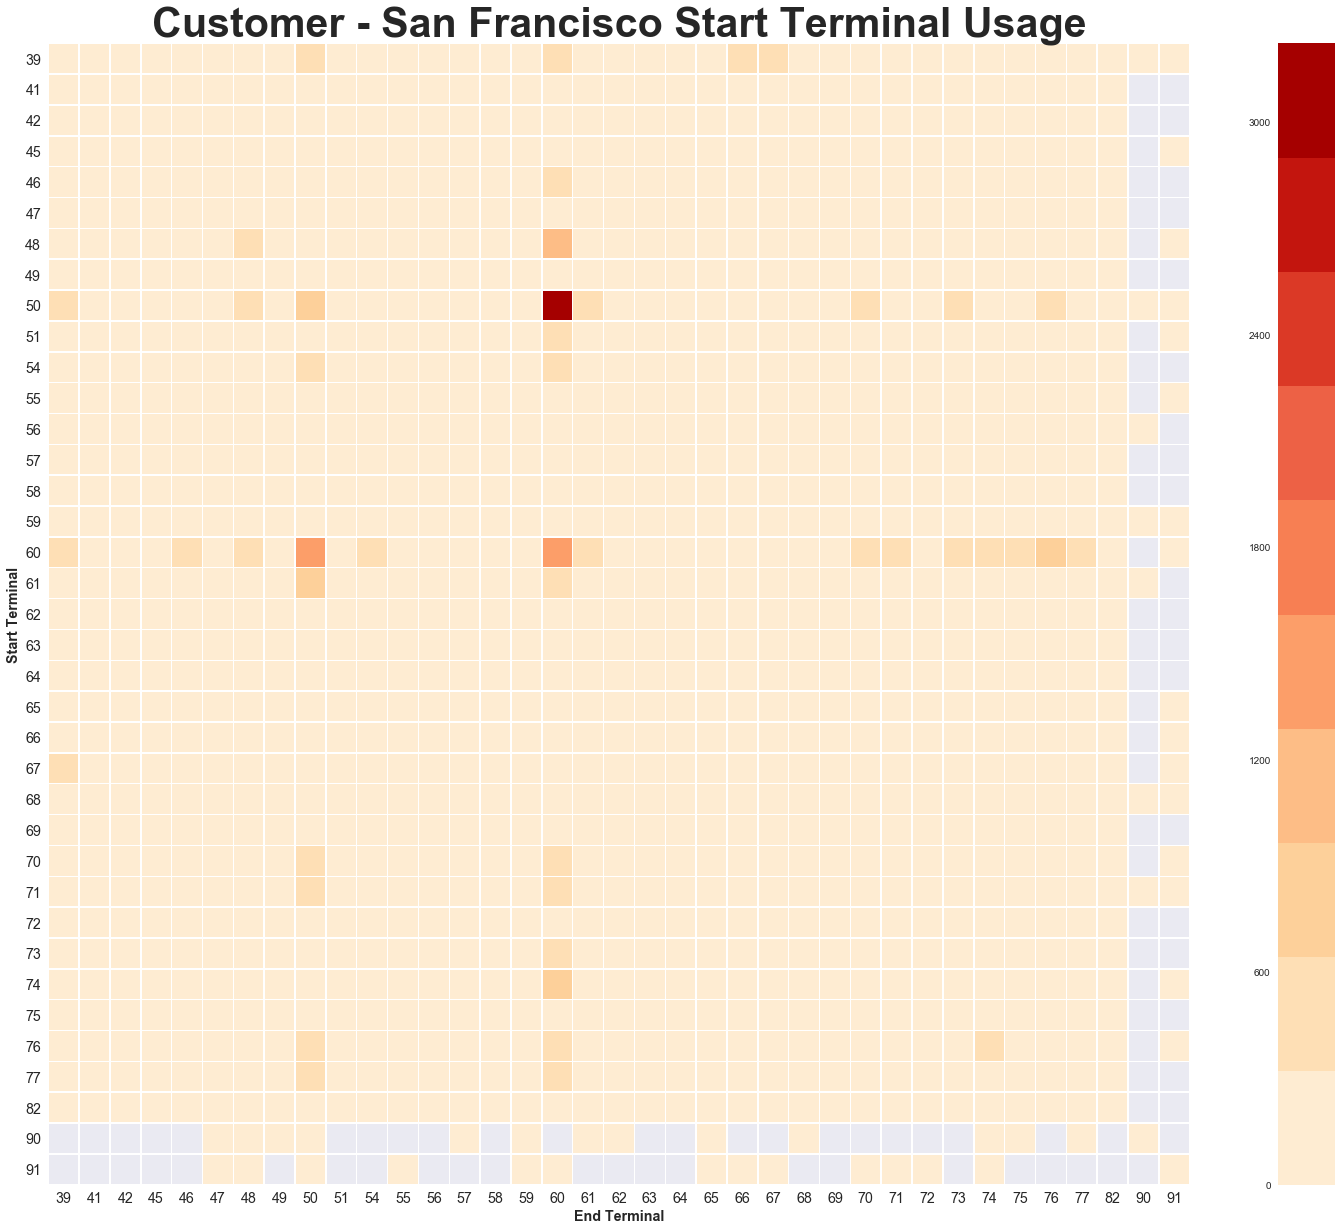

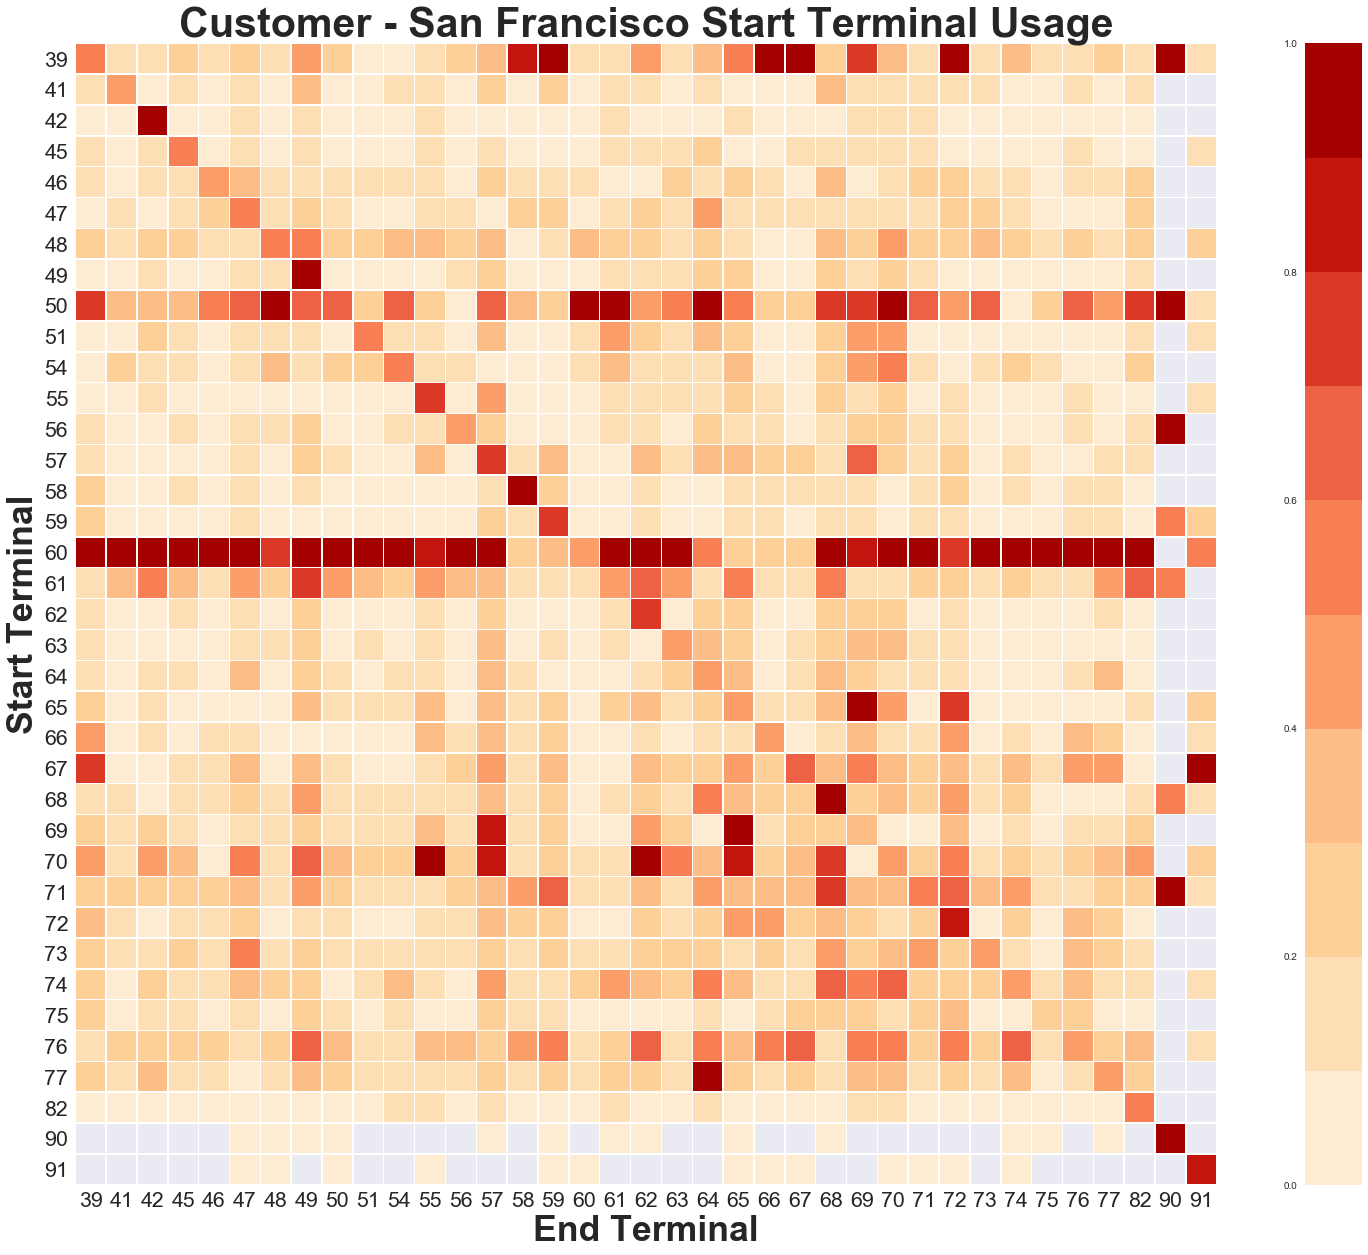

Total Trips in San Francisco	98531	89.15


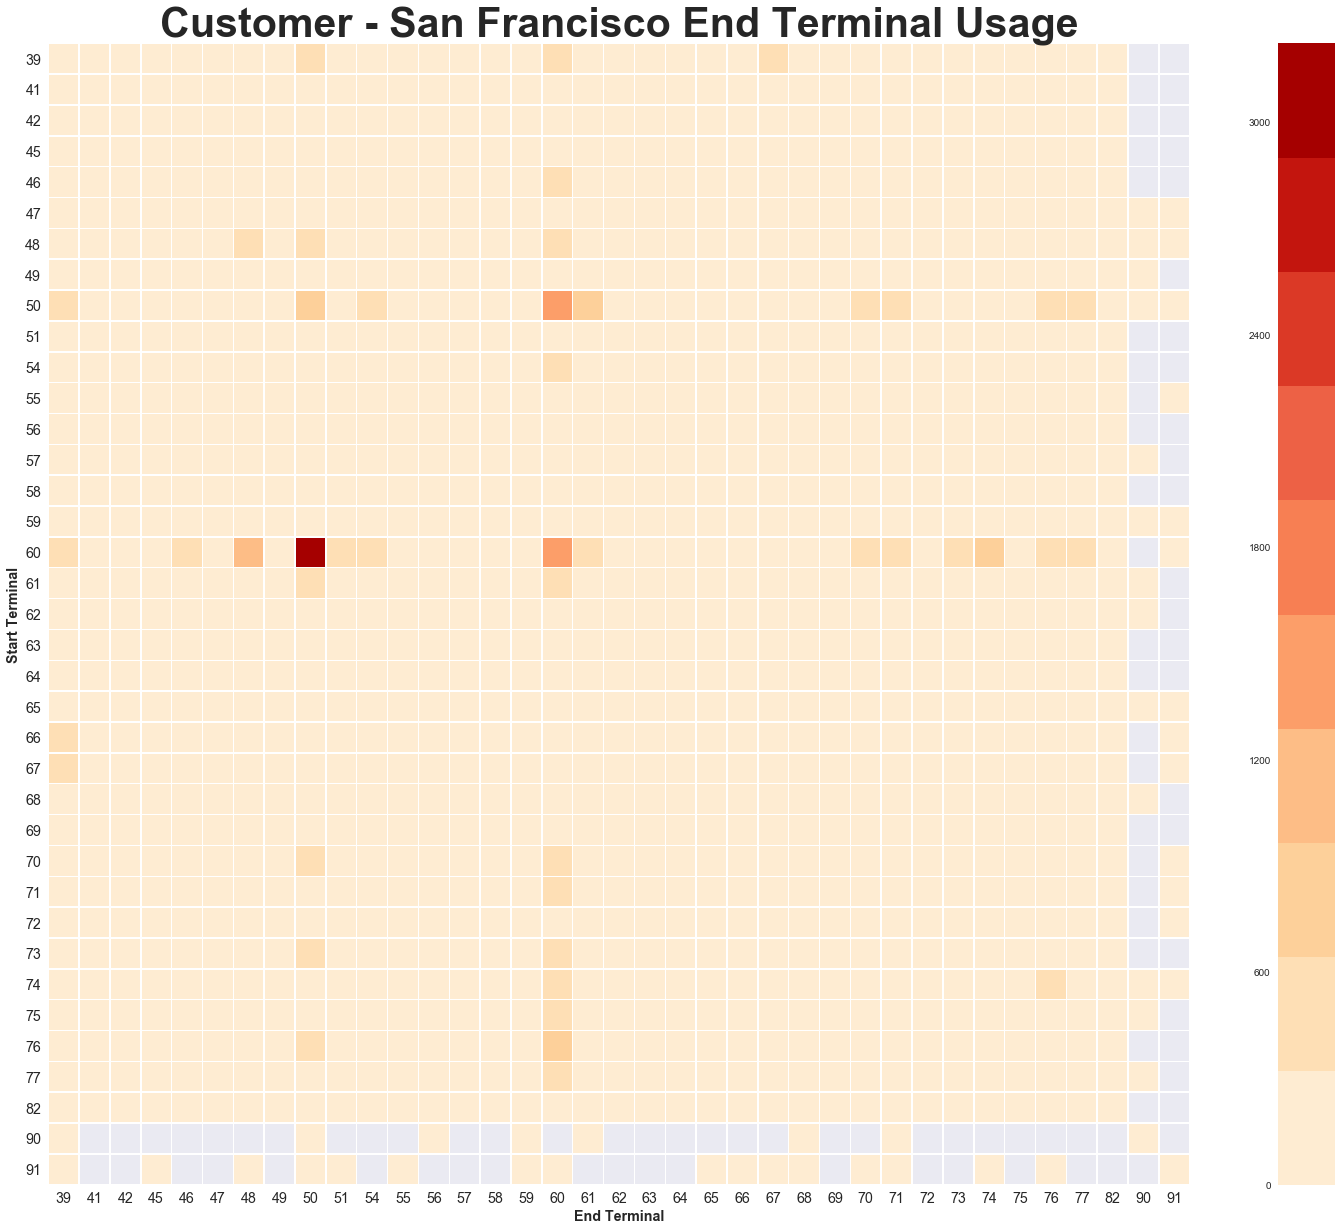

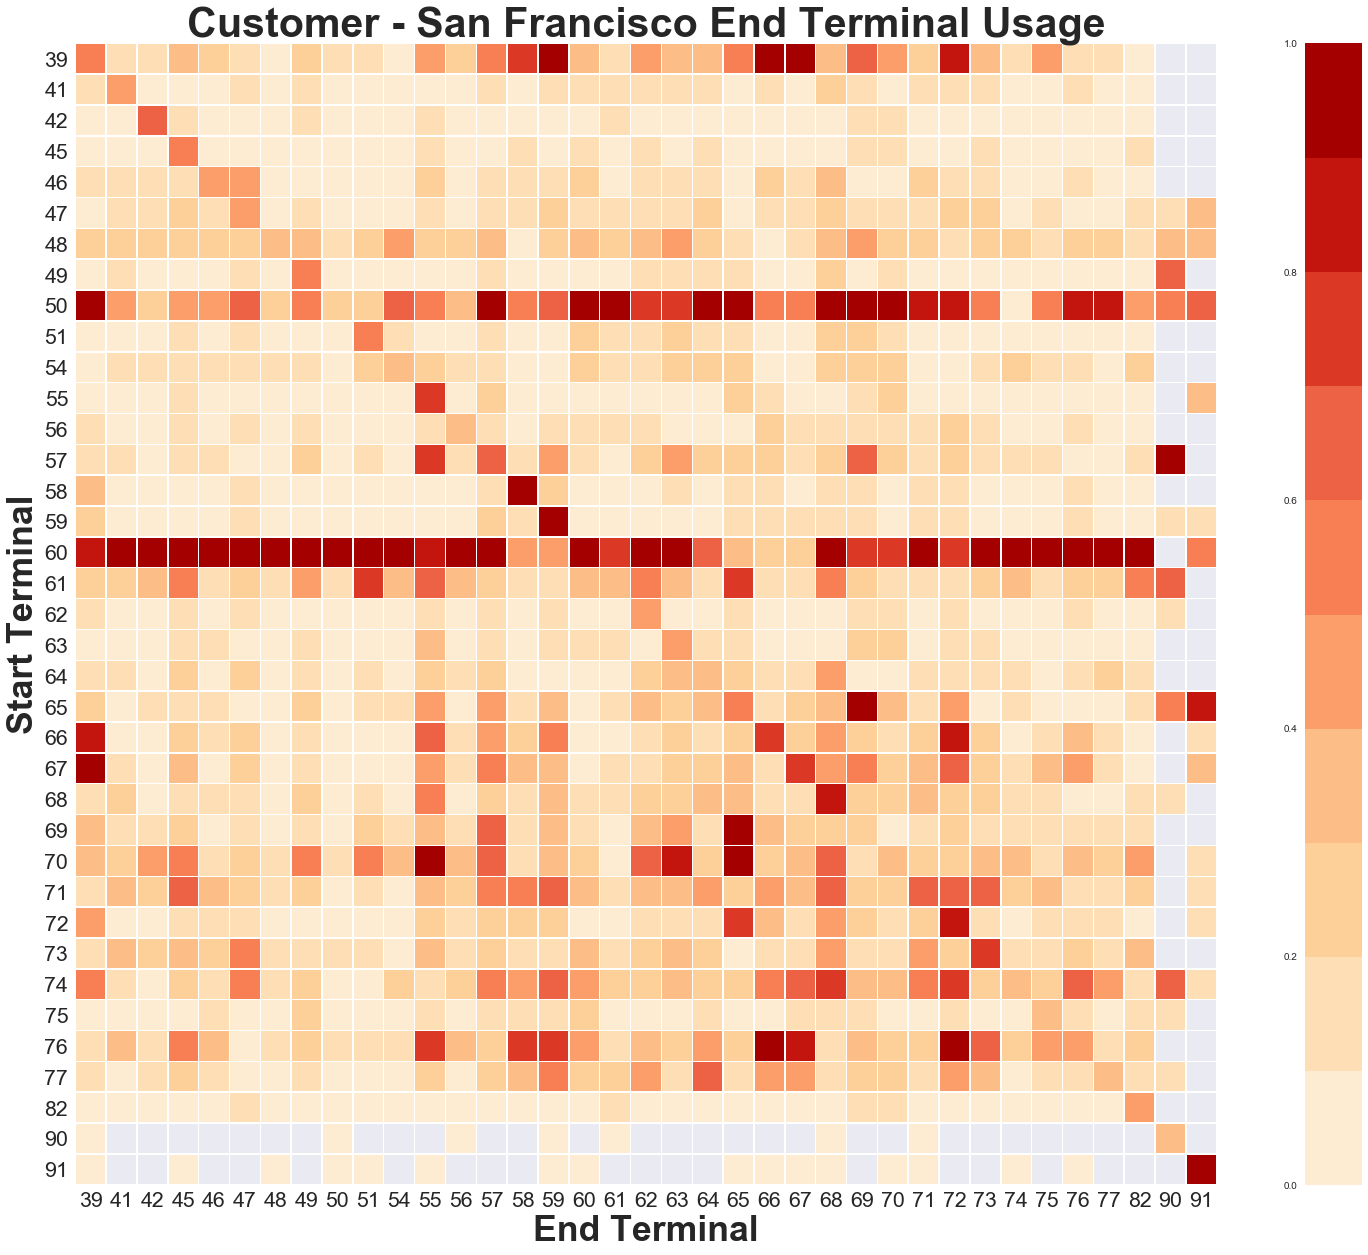

Total Trips in San Francisco	98531	89.15


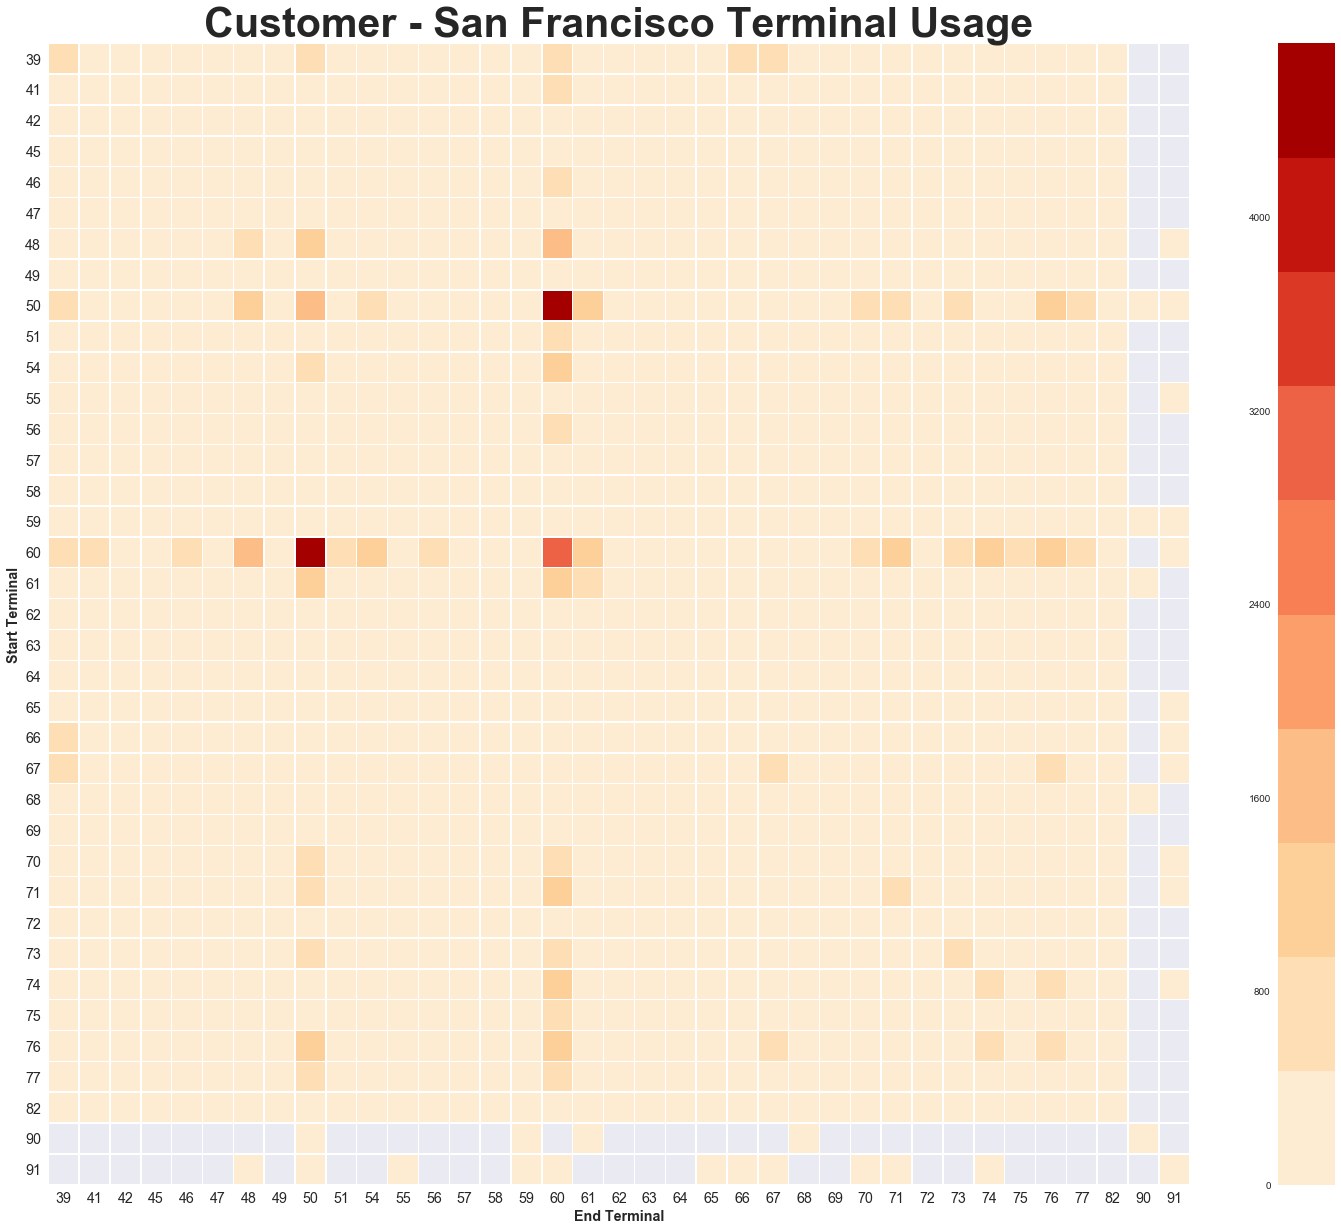

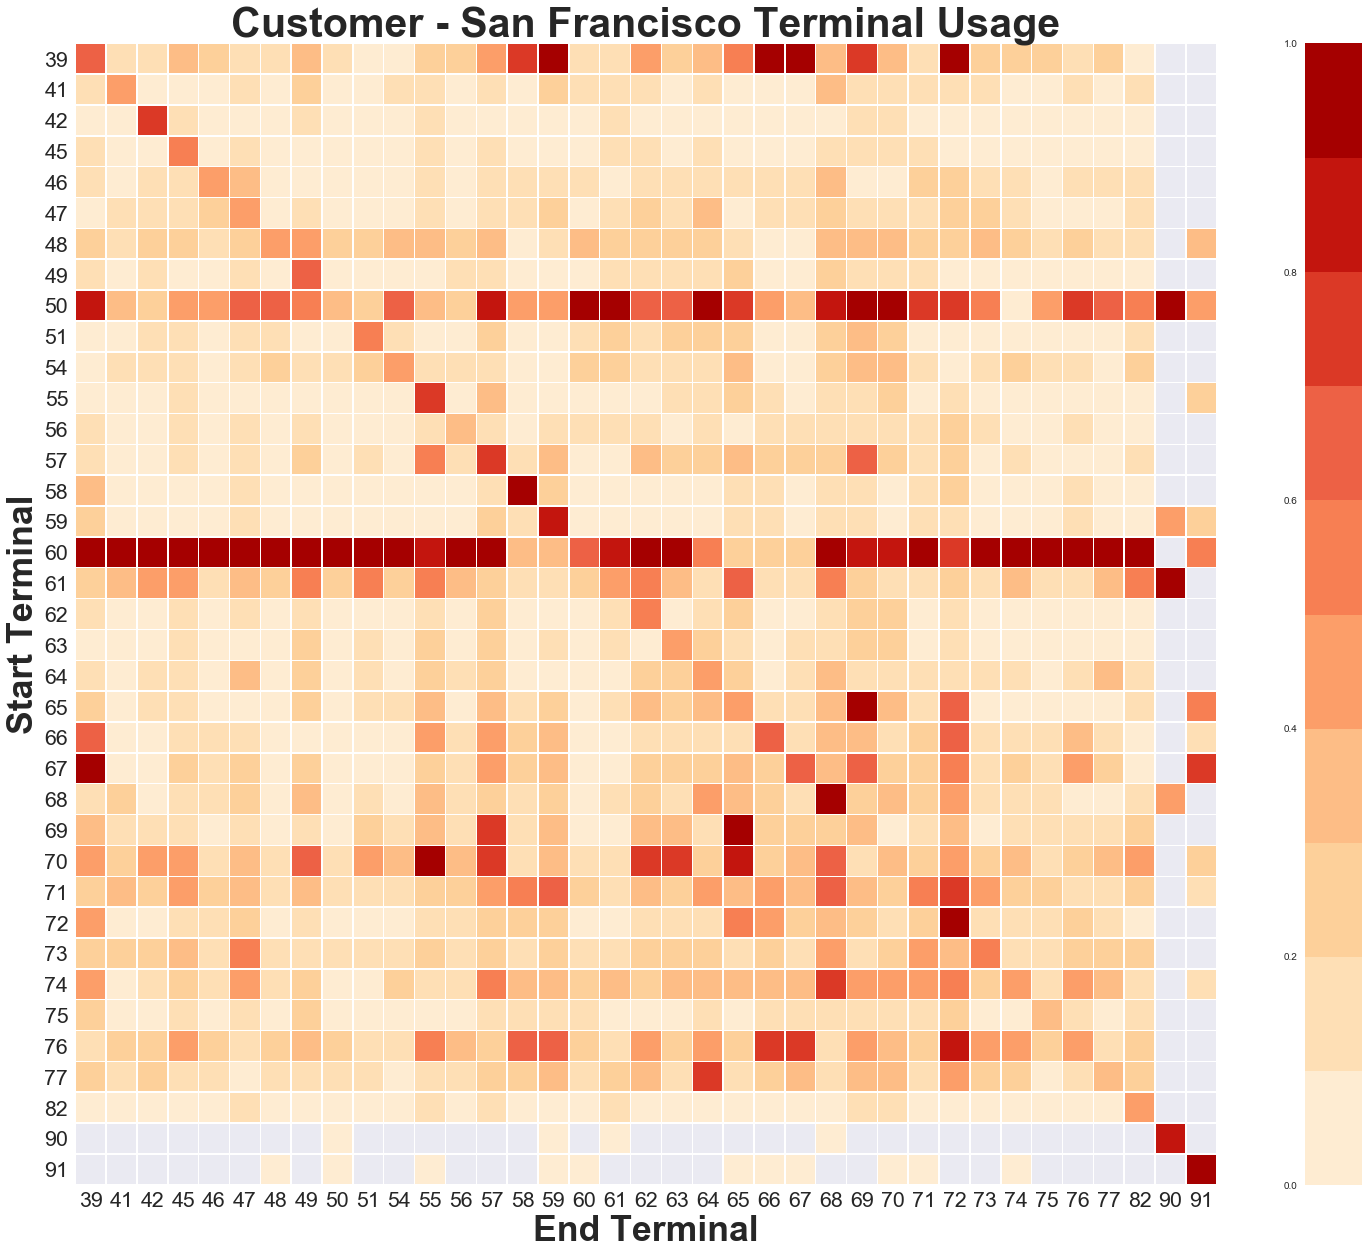

Total Trips in Palo Alto	2061	1.86


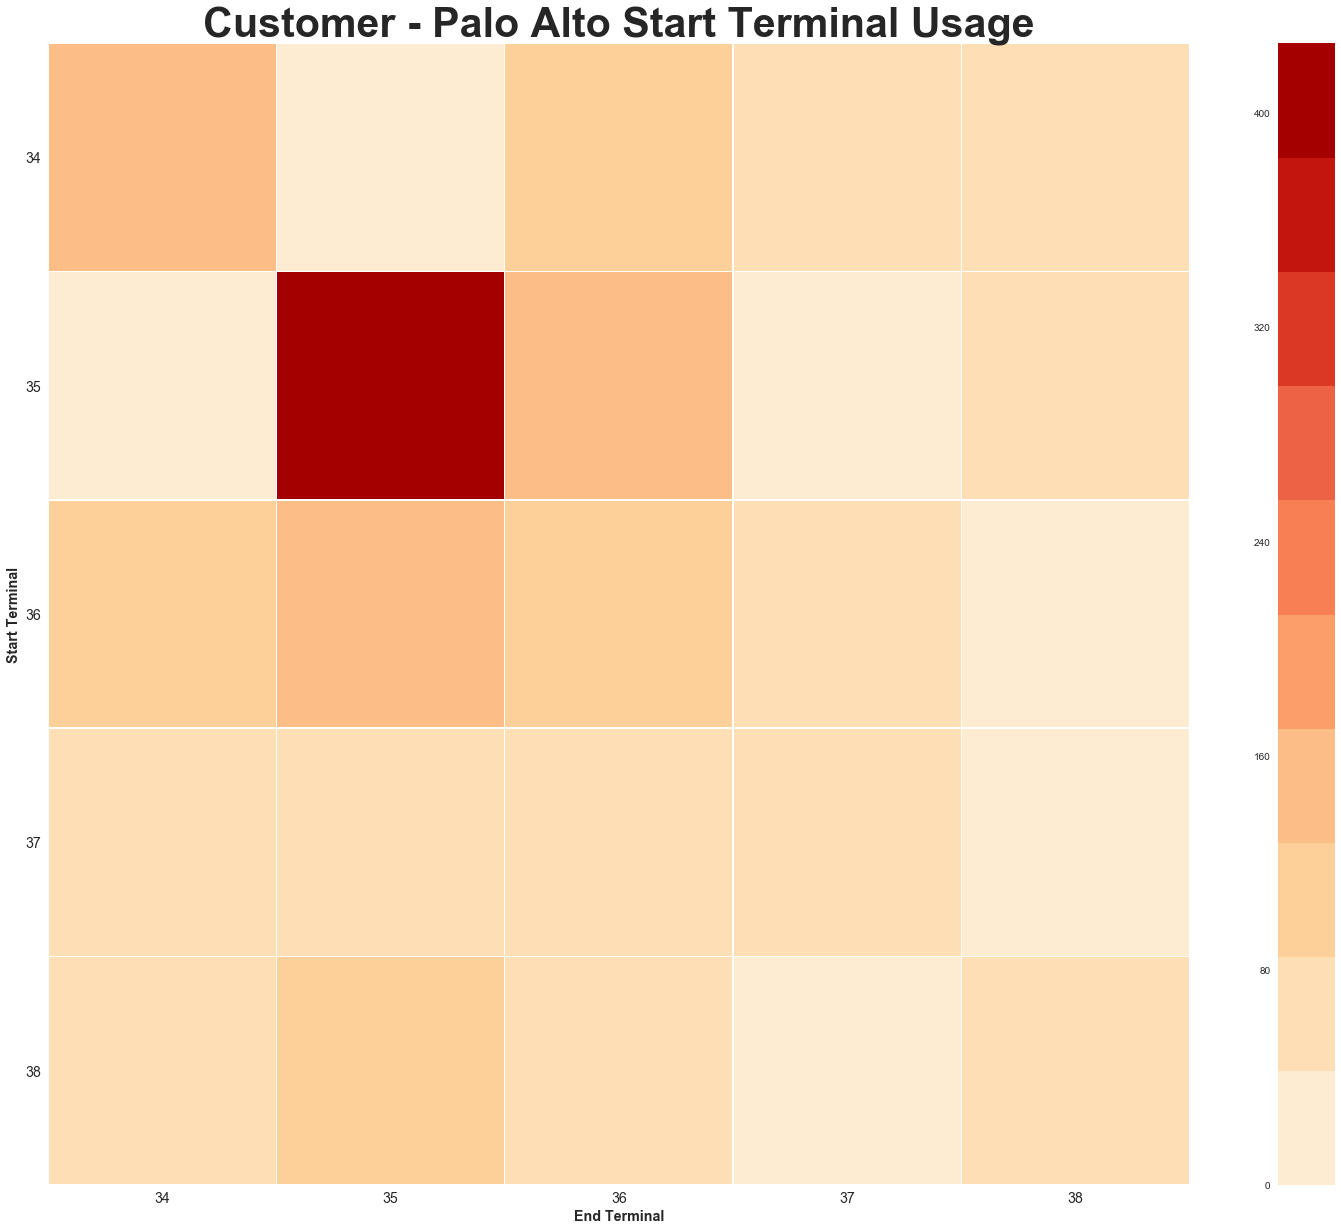

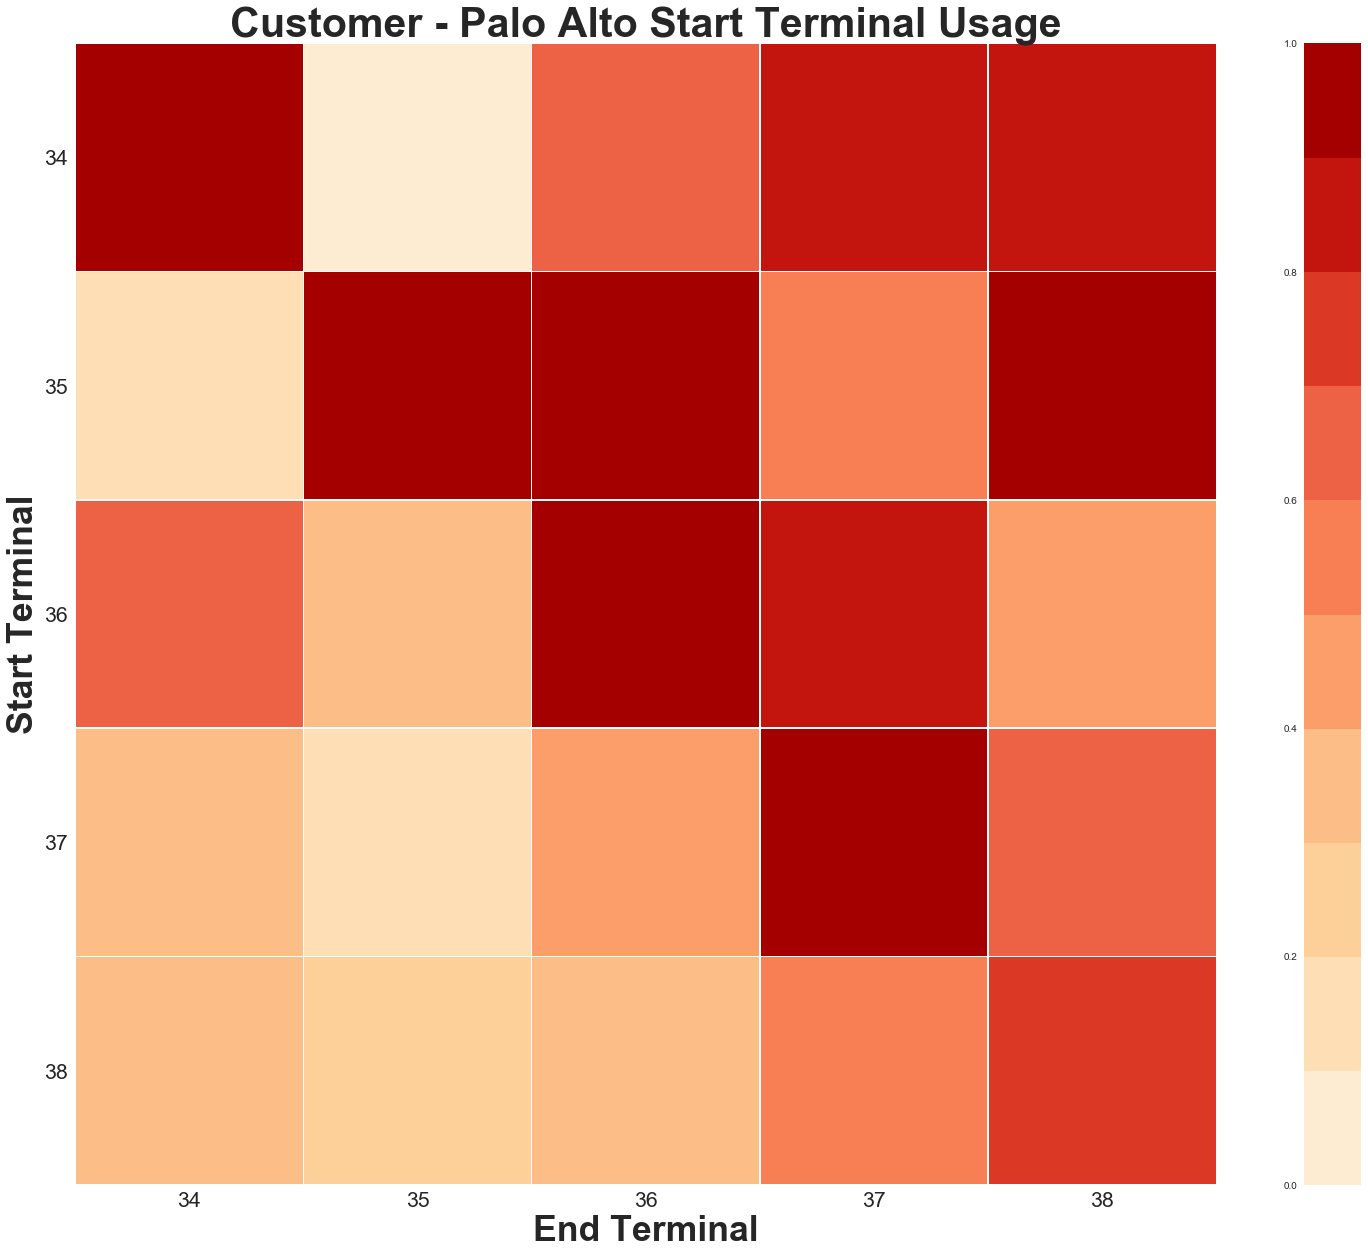

Total Trips in Palo Alto	2061	1.86


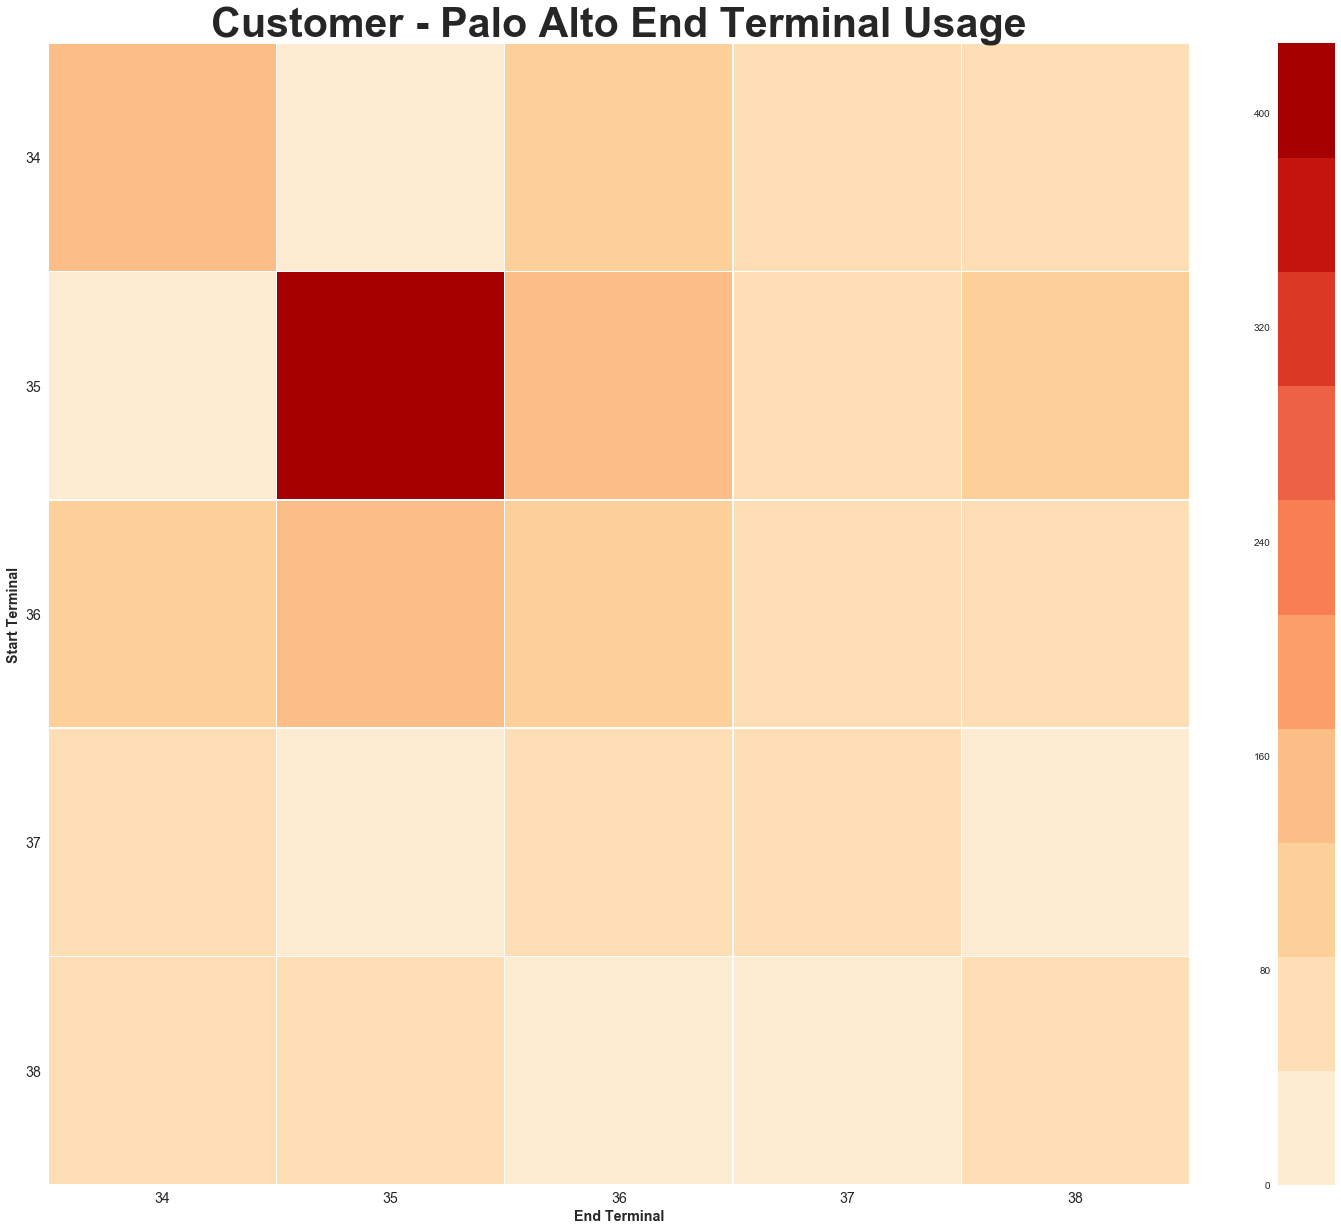

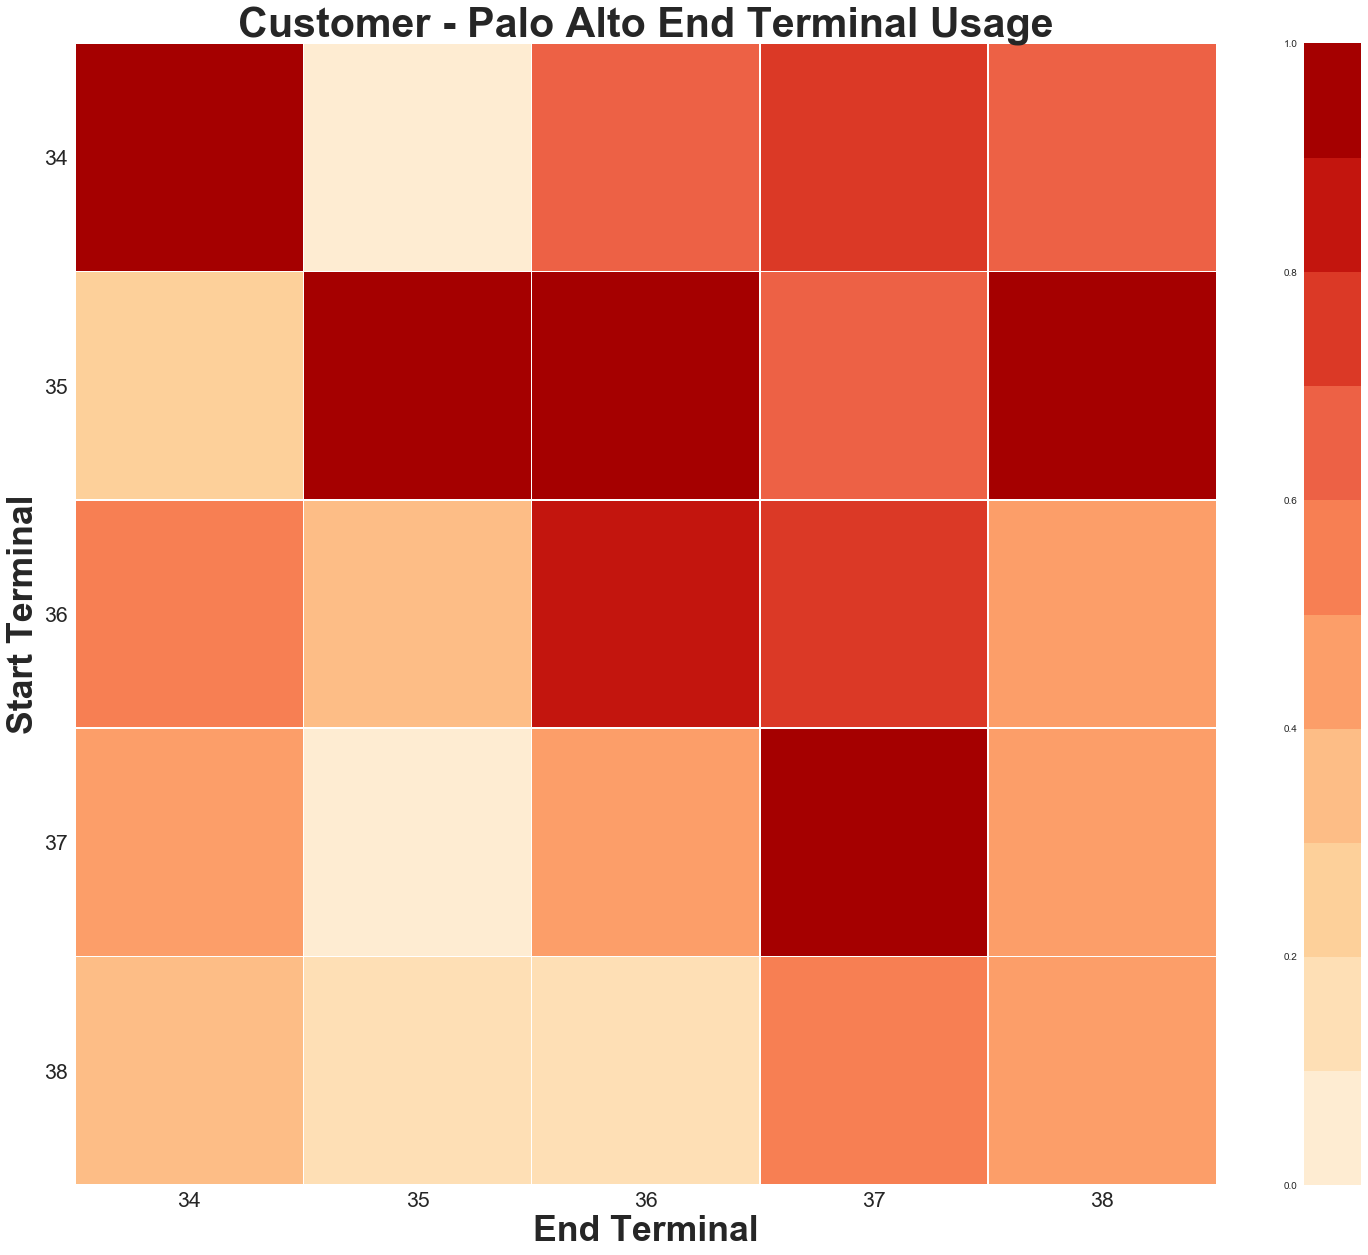

Total Trips in Palo Alto	2061	1.86


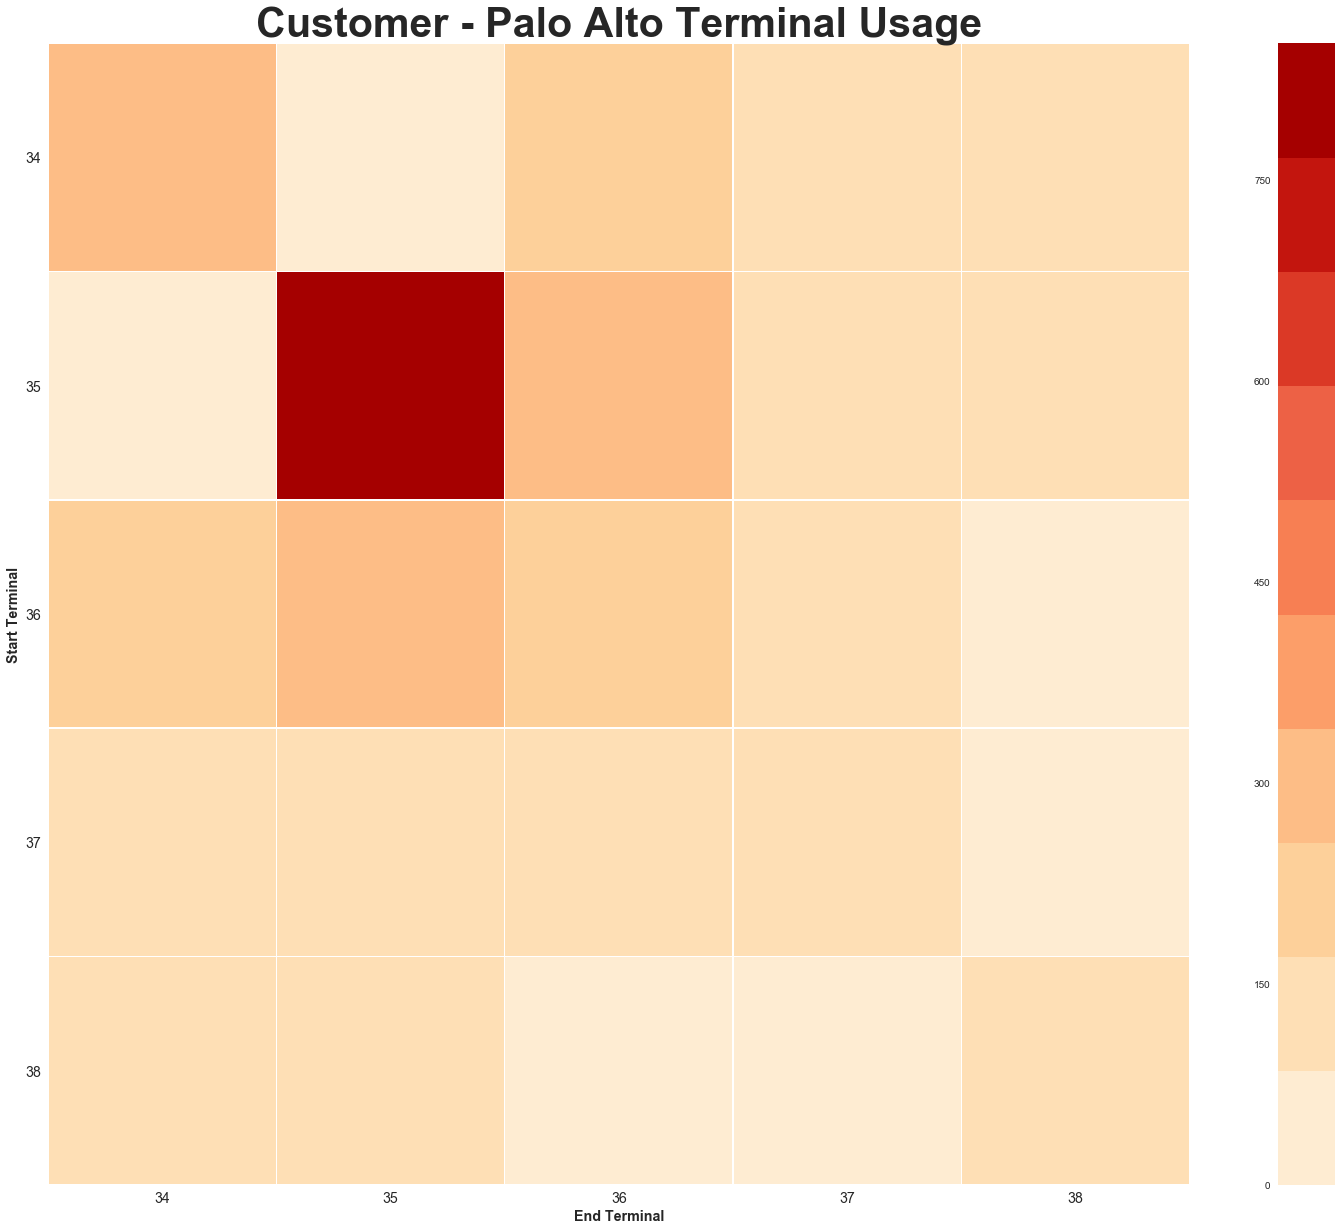

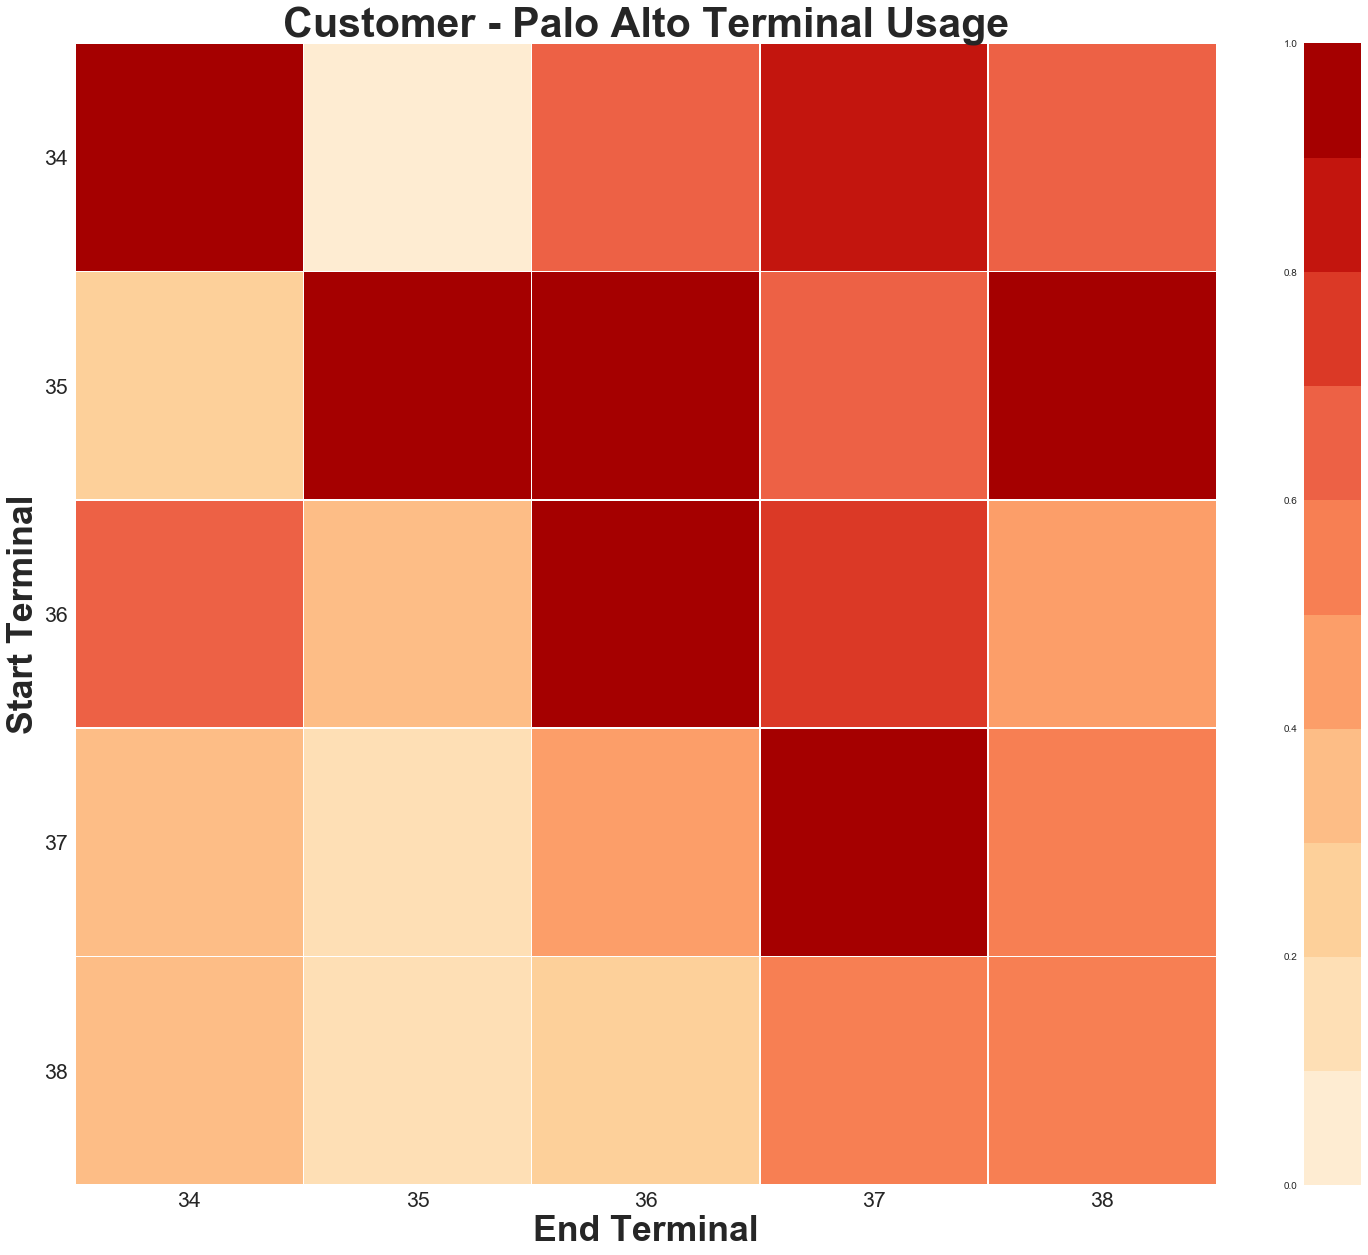

Total Trips in San Jose	7034	6.36


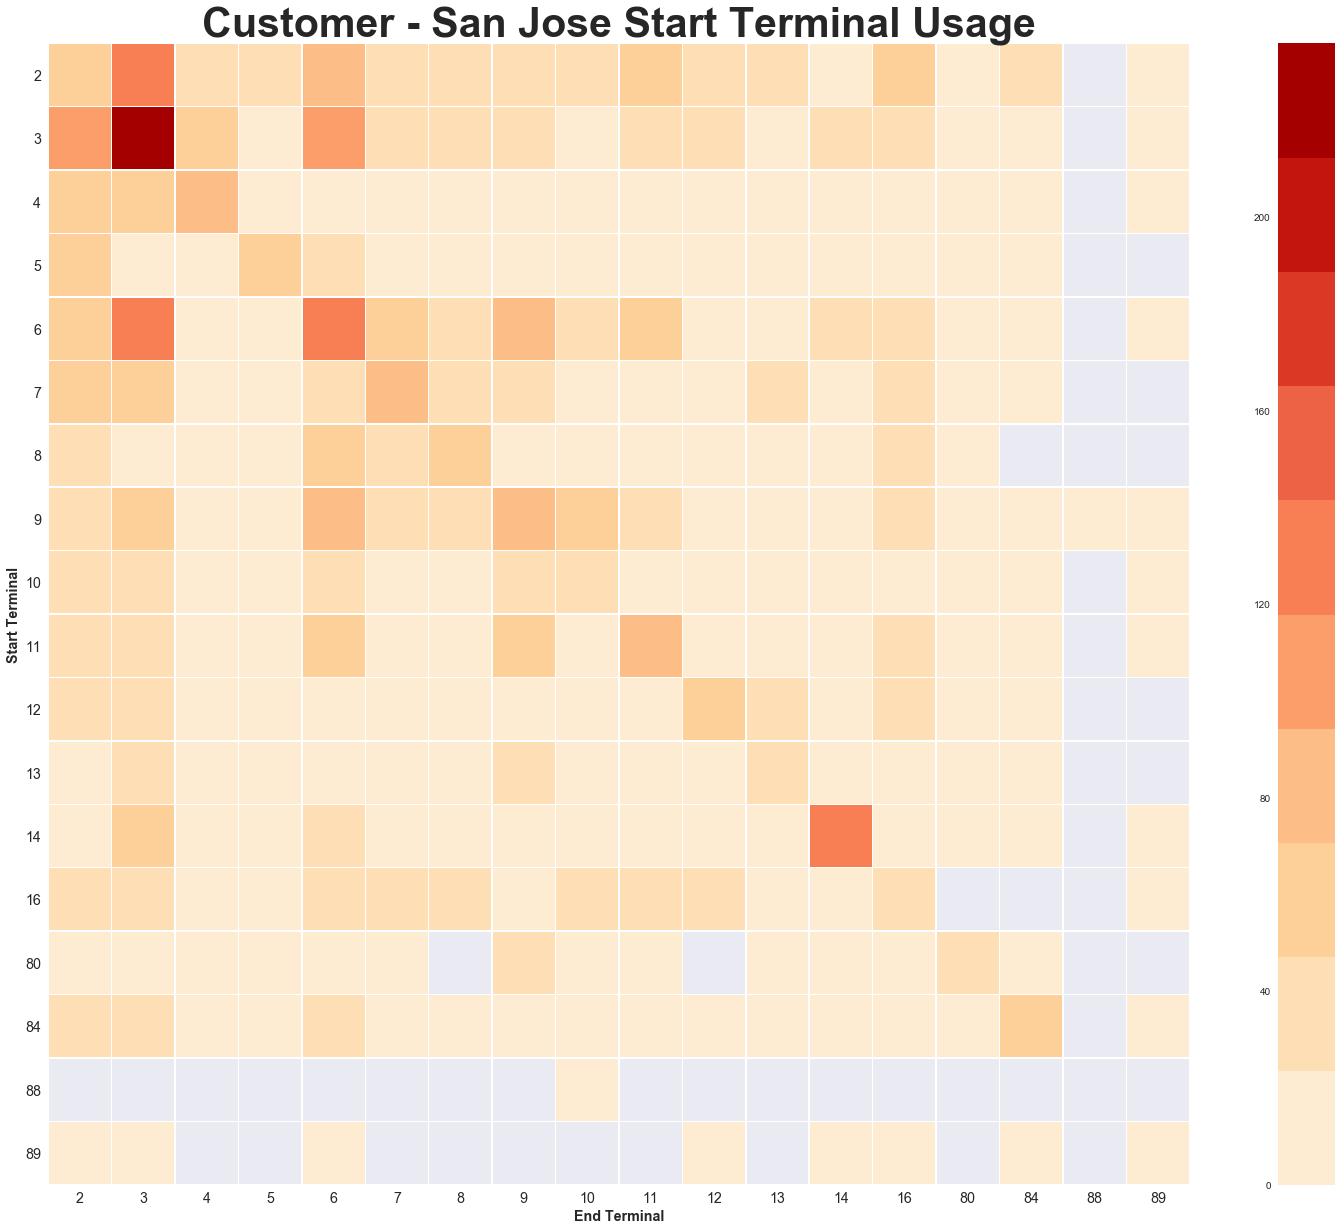

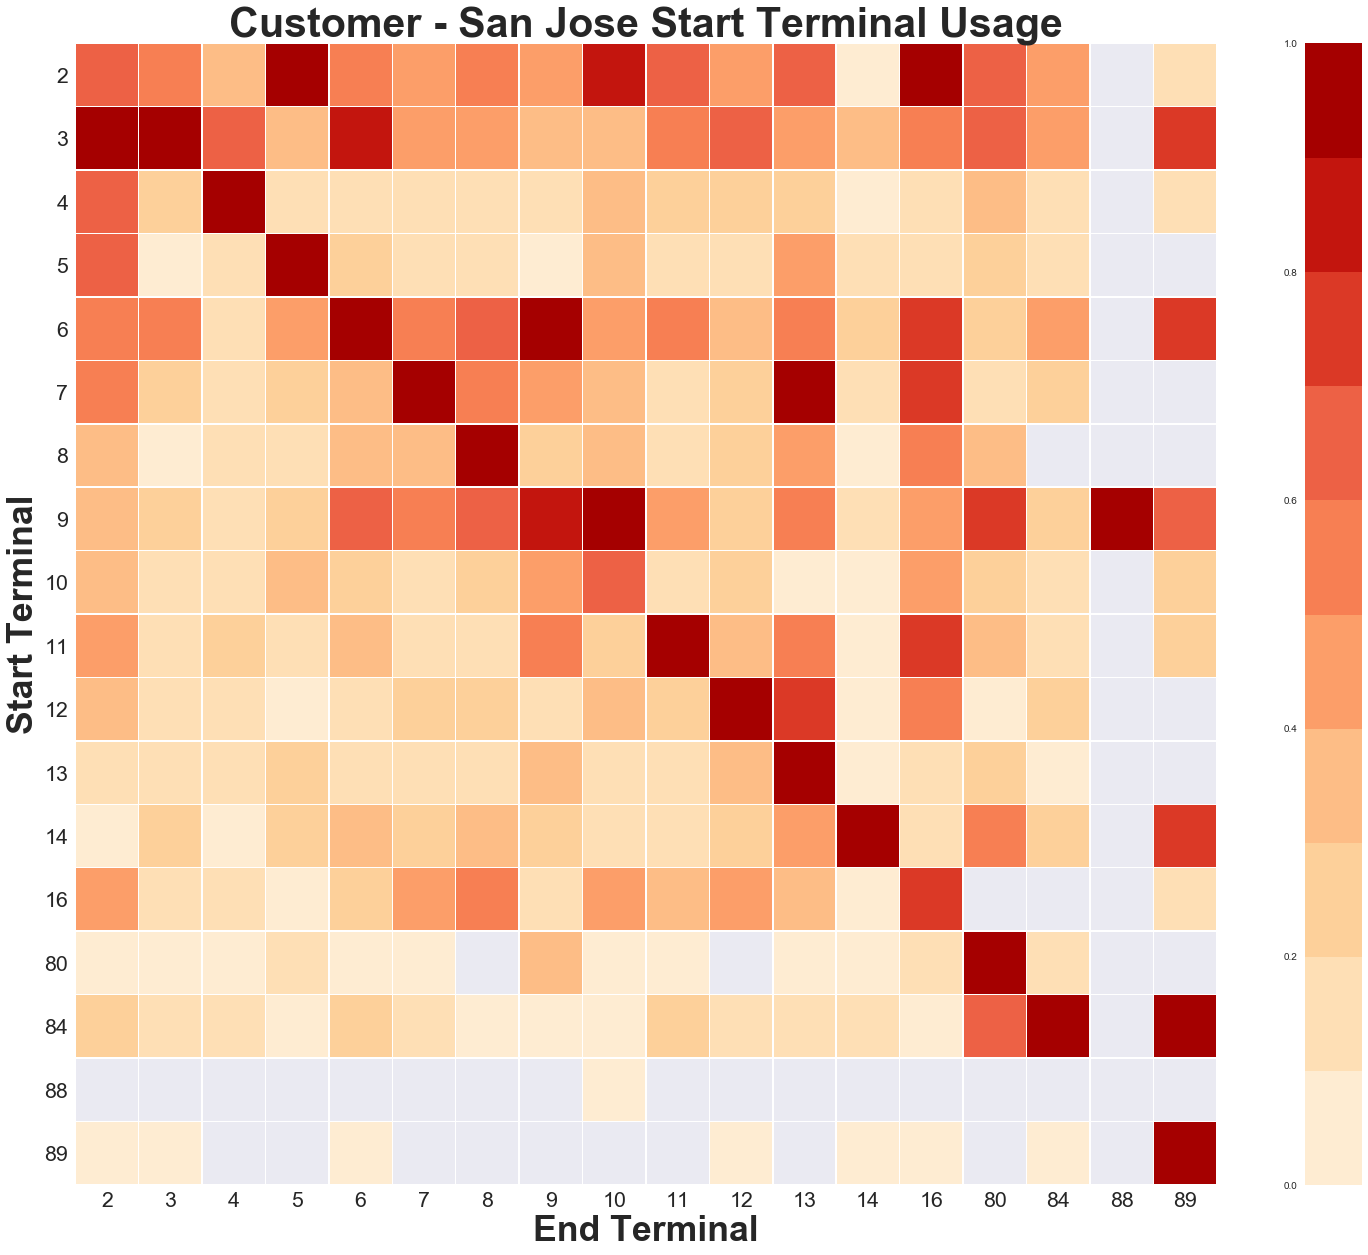

Total Trips in San Jose	7034	6.36


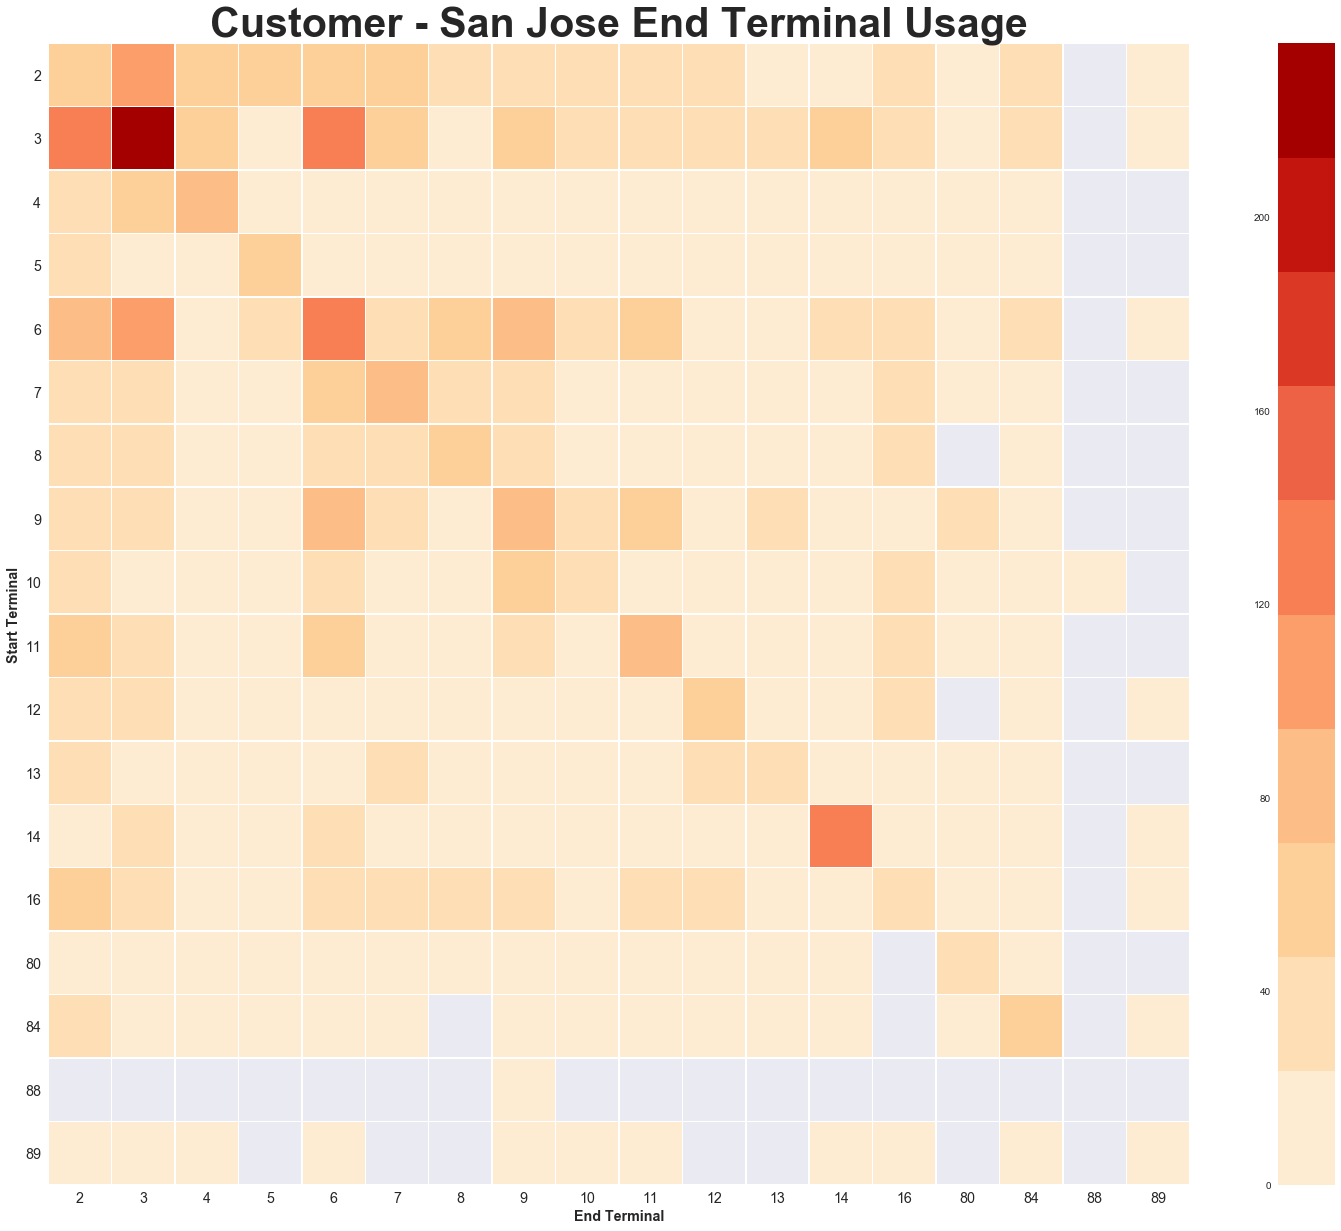

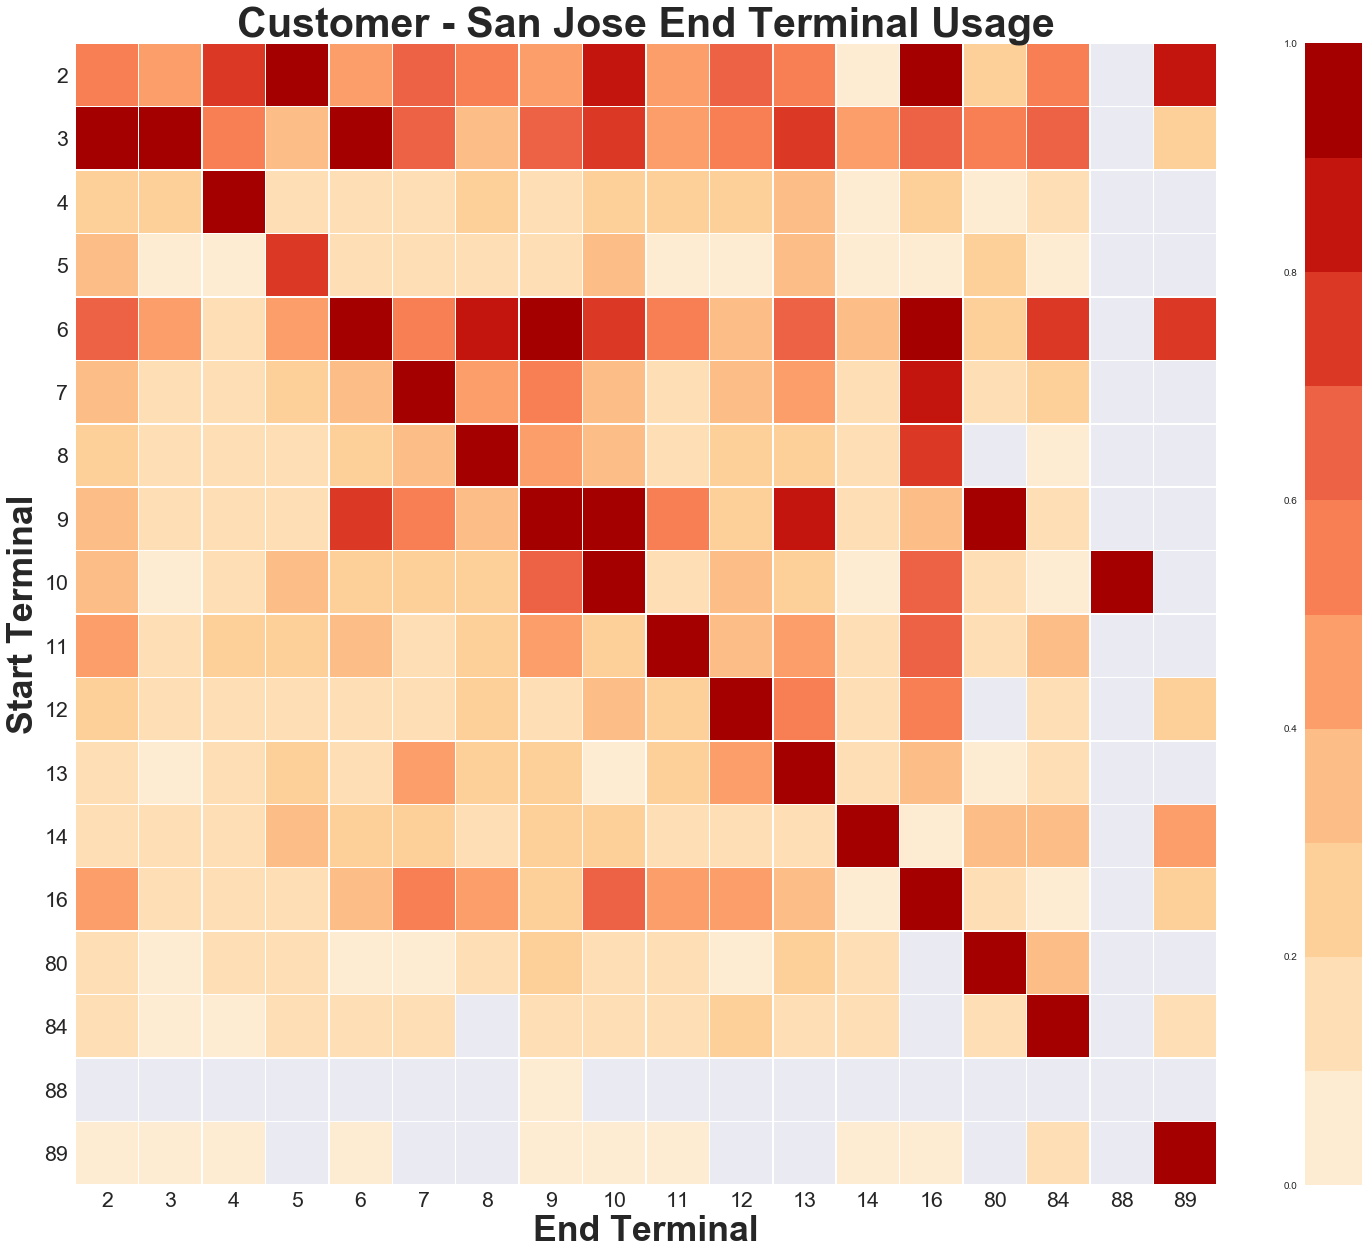

Total Trips in San Jose	7034	6.36


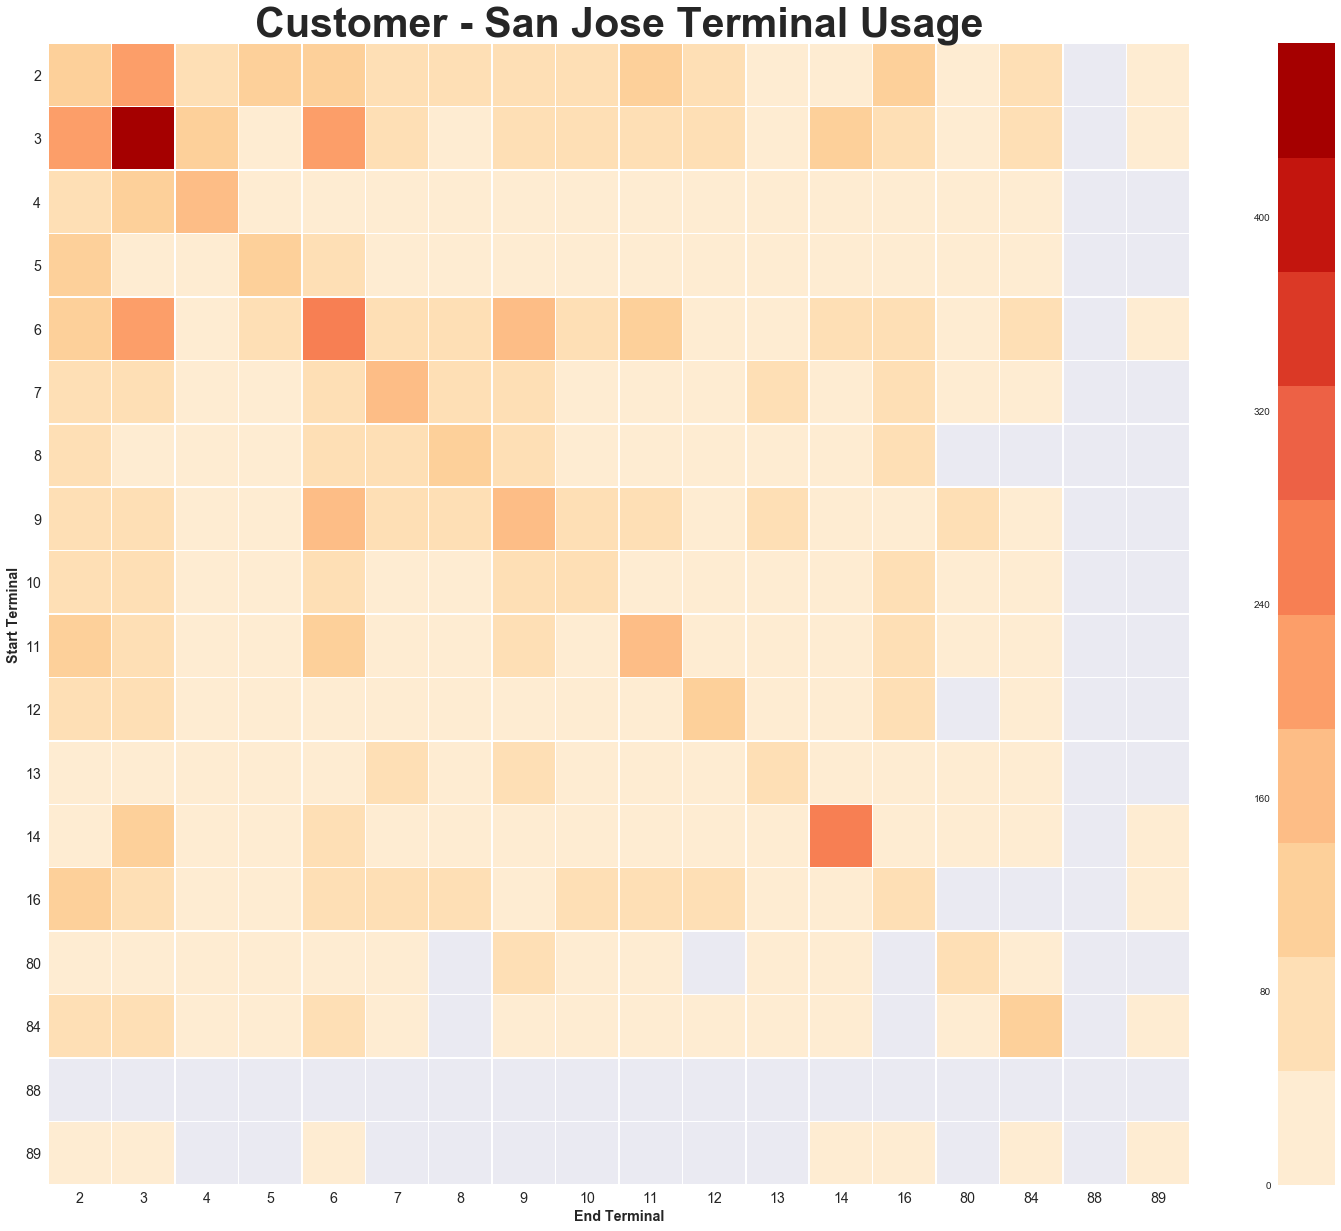

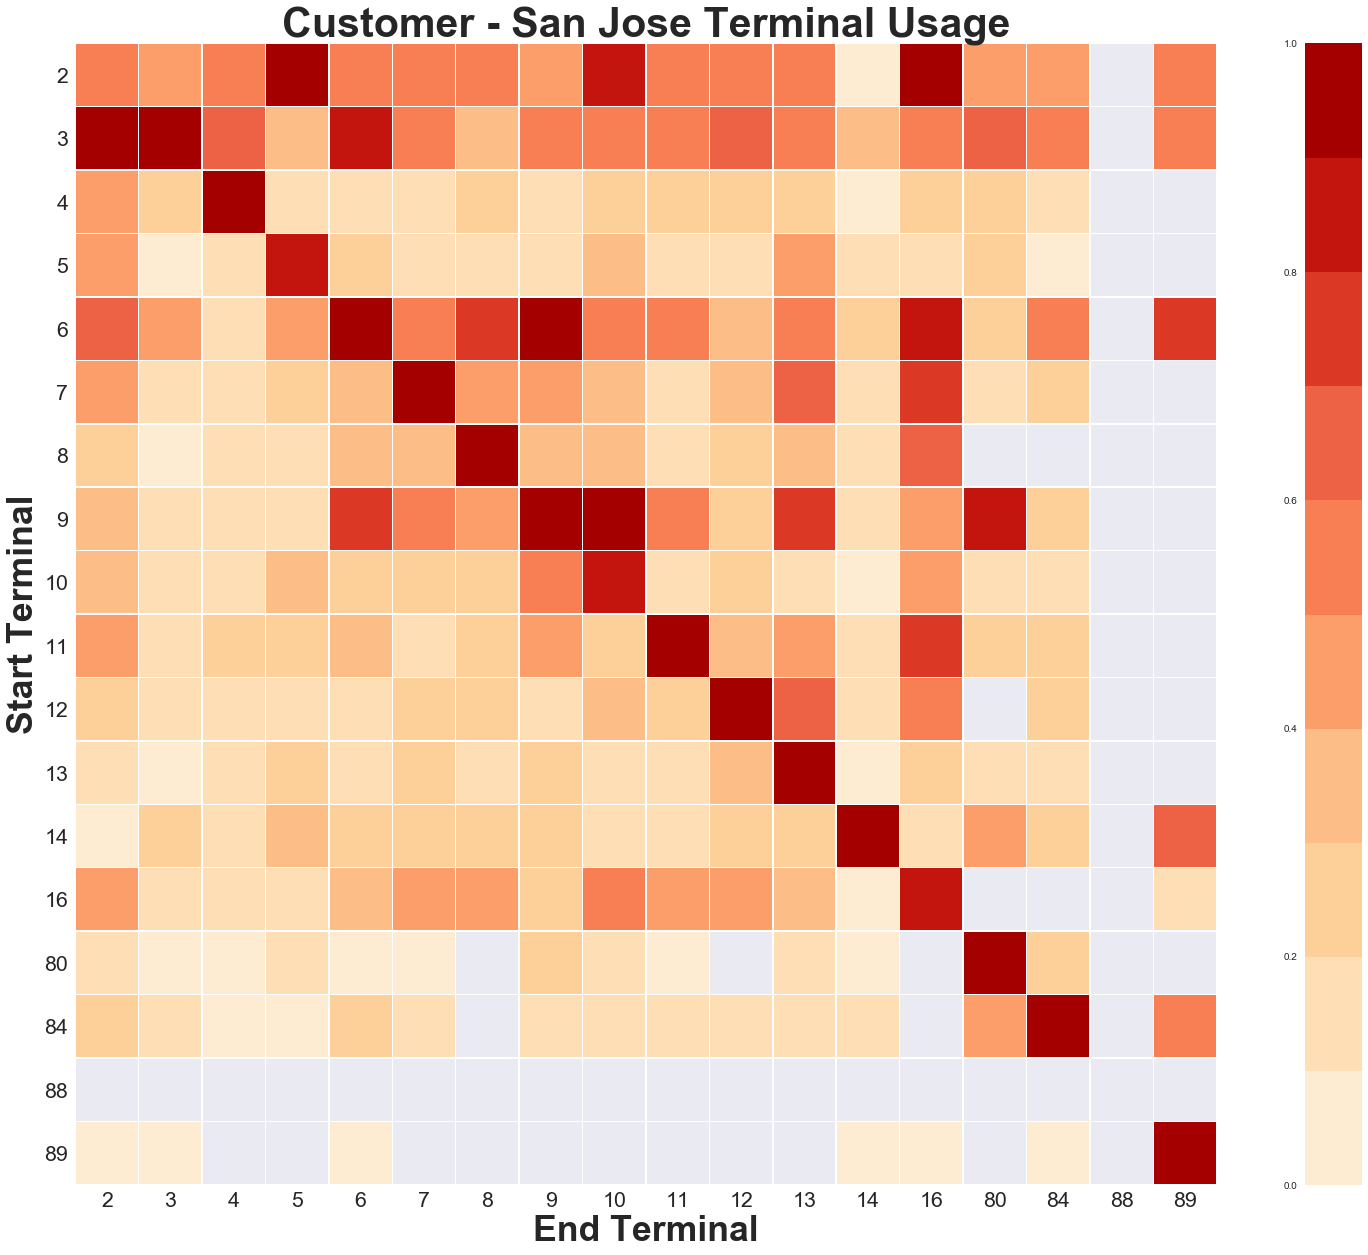

In [466]:
heatmap_regonalized_trips(trip_data, user_type='Customer')

# Top Subscriber Stations - start, end, all

## Load Station Data

In [231]:
station_data = pd.DataFrame()

station_data= pd.read_csv('../clean_data/station_data_cleaned_final.csv', index_col=0, parse_dates=['last_service_date', 'first_service_date'])
station_data.head()

station_id                               name        lat        long  \
0           2  San Jose Diridon Caltrain Station  37.329732 -121.901782   
1           3              San Jose Civic Center  37.330698 -121.888979   
2           4             Santa Clara at Almaden  37.333988 -121.894902   
3           5                   Adobe on Almaden  37.331415 -121.893200   
4           6                   San Pedro Square  37.336721 -121.894074   

   dock_count  landmark first_service_date last_service_date  zip_code  \
0          27  San Jose         2013-08-29        2016-08-31     95113   
1          15  San Jose         2013-08-29        2016-08-31     95113   
2          11  San Jose         2013-08-29        2016-08-31     95113   
3          19  San Jose         2013-08-29        2016-08-31     95113   
4          15  San Jose         2013-08-29        2016-08-31     95113   

   days_in_service  
0             1098  
1             1098  
2             1098  
3             1098  
4             1098

In [232]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 10 columns):
station_id            79 non-null int64
name                  79 non-null object
lat                   79 non-null float64
long                  79 non-null float64
dock_count            79 non-null int64
landmark              79 non-null object
first_service_date    79 non-null datetime64[ns]
last_service_date     79 non-null datetime64[ns]
zip_code              79 non-null int64
days_in_service       79 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 6.8+ KB


In [241]:
def trip_route_hypothesis(A, B, agg='mean'):
    
    if agg == 'mean':    
        A_data = A.groupby('start_terminal')['duration'].mean()
        B_data = B.groupby('start_terminal')['duration'].mean()
    elif agg == 'median':
        A_data = A.groupby('start_terminal')['duration'].median()
        B_data = B.groupby('start_terminal')['duration'].median()
    elif agg == 'min':
        A_data = A.groupby('start_terminal')['duration'].min()
        B_data = B.groupby('start_terminal')['duration'].min()
    elif agg == 'max':
        A_data = A.groupby('start_terminal')['duration'].max()
        B_data = B.groupby('start_terminal')['duration'].max()
    else:
        pass
            
    # calculate Means
    A_mean = A_data.mean()
    B_mean = B_data.mean()
    diff_mean = A_mean - B_mean
    
    # Variance
    A_var = A_data.var()
    B_var = B_data.var()
    
    # Length
    A_count = len(A_data)
    B_count = len(B_data)
    
    # Standard Deviation
    std_error = math.sqrt(A_var/A_count + B_var/B_count)

    # Margin of Error
    margin = 1.96*std_error

    # calculate t statistic and p value with scipy
    t, p = stats.ttest_ind(A_data, B_data)
    
    reject_null = False
    
    if p < 0.05:
        reject_null = True
    else:
        reject_null = False
    
    result = [A_mean, B_mean, diff_mean, std_error, margin, t, p, reject_null]
    
    return result

# Goal 3 - Identify Trends in Service Areas

### Hypothesis 1a - Subscriber One Way Trips Duration vs Round Trip Duration
> $H$o : Subscriber Round Trip Duration = Subscriber One Way Trip Duration
>
> $H$a : Subscriber Round Trip Duration ≠ Subscriber One Way Trip Duration

In [242]:
data = trip_data[trip_data.user_type == 'Subscriber']

A = data[data.start_terminal == data.end_terminal]
B = data[data.start_terminal != data.end_terminal]



tests = {'Mean' : trip_route_hypothesis(A, B, agg='mean'),
            'Median' : trip_route_hypothesis(A, B, agg='median'),
            'Min' : trip_route_hypothesis(A, B, agg='min'),
            'Max' : trip_route_hypothesis(A, B, agg='max')}

results = pd.DataFrame()
results = results.from_dict(tests)
results.index = ['Subscriber One Way Trip Duration', 'Subscriber Round Trip Duration', 'Difference of Means', 
                 'Standard Error', 'Margin of Error', 'T-Value', 'P-Value', 'Reject Null']
results.head(len(results.index))

Max         Mean       Median  \
Subscriber One Way Trip Duration    2851.93      781.055      664.421   
Subscriber Round Trip Duration      3079.31      505.692      457.932   
Difference of Means                -227.382      275.363      206.489   
Standard Error                      110.513      24.5912      33.8178   
Margin of Error                     216.605      48.1988      66.2828   
T-Value                            -2.05772       11.285       6.1896   
P-Value                           0.0414465  1.75466e-21  6.10519e-09   
Reject Null                            True         True         True   

                                         Min  
Subscriber One Way Trip Duration     63.9429  
Subscriber Round Trip Duration       96.3378  
Difference of Means                  -32.395  
Standard Error                       5.55895  
Margin of Error                      10.8955  
T-Value                             -5.67524  
P-Value                           7.5118e-08  
Reject Null                             True

### Hypothesis 1b - Customers One Way Trips Duration vs Round Trip Duration
> $H$o : Customer Round Trip Duration = Customer One Way Trip Duration
>
> $H$a : Customer Round Trip Duration ≠ Customer One Way Trip Duration

In [243]:
data = trip_data[trip_data.user_type == 'Customer']

A = data[data.start_terminal == data.end_terminal]
B = data[data.start_terminal != data.end_terminal]



tests = {'Mean' : trip_route_hypothesis(A, B, agg='mean'),
            'Median' : trip_route_hypothesis(A, B, agg='median'),
            'Min' : trip_route_hypothesis(A, B, agg='min'),
            'Max' : trip_route_hypothesis(A, B, agg='max')}

results = pd.DataFrame()
results = results.from_dict(tests)
results.index = ['Customer One Way Trip Duration', 'Customer Round Trip Duration', 'Difference of Means', 
                 'Standard Error', 'Margin of Error', 'T-Value', 'P-Value', 'Reject Null']
results.head(len(results.index))

Max         Mean       Median       Min
Customer One Way Trip Duration   3453.49      1554.25      1461.51    120.11
Customer Round Trip Duration     3433.55      1044.16      873.426       164
Difference of Means              19.9391      510.086      588.081  -43.8904
Standard Error                   57.2759      37.4902      49.8419   30.9628
Margin of Error                  112.261      73.4808      97.6901   60.6872
T-Value                          0.34752      13.6656      11.8553  -1.42403
P-Value                         0.728705  7.64891e-28  4.30336e-23  0.156586
Reject Null                        False         True         True     False

### Hypothesis 1c - Subscriber One Way Trip Duration vs Customer One Way Trip Duration
> $H$o : Subscriber One Way Trip Duration = Customer One Way Trip Duration
>
> $H$a : Subscriber One Way Trip Duration ≠ Customer One Way Trip Duration

In [244]:
data = trip_data[trip_data.start_terminal == trip_data.end_terminal]

A = data[data.user_type == 'Subscriber']
B = data[data.user_type == 'Customer']



tests = {'Mean' : trip_route_hypothesis(A, B, agg='mean'),
            'Median' : trip_route_hypothesis(A, B, agg='median'),
            'Min' : trip_route_hypothesis(A, B, agg='min'),
            'Max' : trip_route_hypothesis(A, B, agg='max')}

results = pd.DataFrame()
results = results.from_dict(tests)
results.index = ['Subscriber One Way Trip Duration', 'Customer One Way Trip Duration', 'Difference of Means', 
                 'Standard Error', 'Margin of Error', 'T-Value', 'P-Value', 'Reject Null']
results.head(len(results.index))

Max         Mean       Median  \
Subscriber One Way Trip Duration      2851.93      781.055      664.421   
Customer One Way Trip Duration        3453.49      1554.25      1461.51   
Difference of Means                  -601.565     -773.193     -797.085   
Standard Error                        86.7893      39.3595      54.5237   
Margin of Error                       170.107      77.1446      106.867   
T-Value                              -7.02873     -19.4351     -14.4846   
P-Value                           8.20706e-11  1.02639e-41  1.06908e-29   
Reject Null                              True         True         True   

                                        Min  
Subscriber One Way Trip Duration    63.9429  
Customer One Way Trip Duration       120.11  
Difference of Means                -56.1667  
Standard Error                      28.3339  
Margin of Error                     55.5344  
T-Value                            -1.94096  
P-Value                           0.0542582  
Reject Null                           False

### Hypothesis 1d - Subscriber Round Trip Duration vs Customer Round Trip Duration
> $H$o : Subscriber Round Trip Duration = Customer Round Trip Duration
>
> $H$a : Subscriber Round Trip Duration ≠ Customer Round Trip Duration

In [245]:
data = trip_data[trip_data.start_terminal != trip_data.end_terminal]

A = data[data.user_type == 'Subscriber']
B = data[data.user_type == 'Customer']


tests = {'Mean' : trip_route_hypothesis(A, B, agg='mean'),
            'Median' : trip_route_hypothesis(A, B, agg='median'),
            'Min' : trip_route_hypothesis(A, B, agg='min'),
            'Max' : trip_route_hypothesis(A, B, agg='max')}

results = pd.DataFrame()
results = results.from_dict(tests)
results.index = ['Subscriber Round Trip Duration', 'Customer Round Trip Duration', 'Difference of Means', 
                 'Standard Error', 'Margin of Error', 'T-Value', 'P-Value', 'Reject Null']
results.head(len(results.index))

Max         Mean       Median  \
Subscriber Round Trip Duration     3079.31      505.692      457.932   
Customer Round Trip Duration       3433.55      1044.16      873.426   
Difference of Means               -354.243     -538.471     -415.493   
Standard Error                     89.2259      21.4726      25.5933   
Margin of Error                    174.883      42.0864      50.1629   
T-Value                           -3.97018     -25.0771     -16.2345   
P-Value                         0.00011232  8.87539e-55  1.62888e-34   
Reject Null                           True         True         True   

                                        Min  
Subscriber Round Trip Duration      96.3378  
Customer Round Trip Duration            164  
Difference of Means                -67.6622  
Standard Error                      13.6671  
Margin of Error                     26.7875  
T-Value                            -4.95073  
P-Value                         2.01503e-06  
Reject Null                            True

# Goal 4 - Does Weather Affect Subscribers?

### Analyze Only Weekday Morning and Evening Commutes
> Narrow Down Data
- Subscribers in the San Francisco Service Area
    - Morning Commuters
    - Evening Commuters

In [491]:
subscriber_data = trip_data[(trip_data.user_type == 'Subscriber') & (trip_data.start_zip == 94107) & (trip_data.end_zip == 94107)].copy()
print(len(subscriber_data))

769677


In [492]:
# Define commute Hours
morning_commute_hours = [ 7, 10]
evening_commute_hours = [16, 19]

In [547]:
morning_commuter_data = subscriber_data[(subscriber_data.start_date.dt.hour >= morning_commute_hours[0]) & (subscriber_data.start_date.dt.hour <= morning_commute_hours[1])]
evening_commuter_data = subscriber_data[(subscriber_data.start_date.dt.hour >= evening_commute_hours[0]) & (subscriber_data.start_date.dt.hour <= evening_commute_hours[1])]

commuter_data = pd.concat([morning_commuter_data, evening_commuter_data])


In [549]:
print('Dataset\t\t\t    Number of Trips\t    Share of All Trips')
print('All Trip Data\t\t\t%s\t\t\t%0.2f' % (len(trip_data), (len(trip_data)/len(trip_data)*100.)))
print('Subscriber Data\t\t\t%s\t\t\t %0.2f' % (len(subscriber_data), (len(subscriber_data))/len(trip_data)*100.))
print('Commuter Data\t\t\t%s\t\t\t %0.2f' % (len(commuter_data), (len(commuter_data))/len(trip_data)*100.))
print('Morning Commuter Data\t\t%s\t\t\t %0.2f' % (len(morning_commuter_data), (len(morning_commuter_data))/len(trip_data)*100.))
print('Evening Commuter Data\t\t%s\t\t\t %0.2f' % (len(evening_commuter_data), (len(evening_commuter_data))/len(trip_data)*100.))

Dataset			    Number of Trips	    Share of All Trips
All Trip Data			955557			100.00
Subscriber Data			769677			 80.55
Commuter Data			561716			 58.78
Morning Commuter Data		289286			 30.27
Evening Commuter Data		272430			 28.51


In [536]:
def hypothesis_test(A, B):
    # calculate Means
    A_data = A.copy()
    B_data = B.copy()

    A_mean = A_data.mean()
    B_mean = B_data.mean()
    diff_mean = A_mean - B_mean

    # Variance
    A_var = A_data.var()
    B_var = B_data.var()

    # Length
    A_count = len(A_data)
    B_count = len(B_data)

    # Standard Deviation
    std_error = math.sqrt(A_var/A_count + B_var/B_count)

    # Margin of Error
    margin = 1.96*std_error

    # calculate t statistic and p value with scipy
    t, p = stats.ttest_ind(A_data, B_data)

    reject_null = False

    if p < 0.05:
        reject_null = True
    else:
        reject_null = False

    result = [A_mean, B_mean, diff_mean, std_error, margin, t, p, reject_null]

    return result

### Test 1 - Number of Trips in Morning and Evening Commute Hours
> $H$o : Number of Morning Commuter Trips = Number of Evening Commuter Trips
>
> $H$a : Number of Morning Commuter Trips ≠ Number of Evening Commuter Trips

### Result 1 - Number of Morning Commuter Trips ≠ Number of Evening Commuter Trips

> From calculations we arrive at <b>margin of error 13.69907</b>
>
- Reject $H$o if range of 95% confidence interval is +/- 0.015 
> 
> From calculations we arrive at <b>mean difference 15.33758</b>, thus the $H$o is <b>rejected</b>
>
- T Statistic <b>2.19443</b> 
- P Value <b>0.02831</b> which is below the 0.05 threshhold thus we <b> reject the $H$o</b>

In [565]:
# trips per day
morning_commuter_trips_per_day = morning_commuter_data.groupby(morning_commuter_data.start_date.dt.date)['trip_id'].count()
evening_commuter_trips_per_day = evening_commuter_data.groupby(evening_commuter_data.start_date.dt.date)['trip_id'].count()
test_results = hypothesis_test(morning_commuter_trips_per_day, evening_commuter_trips_per_day)

print('Morning Commute Hour Mean Trip Count\t%0.5f' % test_results[0])
print('Evening Commute Hour Mean Trip Count\t%0.5f' % test_results[1])
print('Difference of Means\t\t\t %0.5f' % test_results[2])
print('Standard Error\t\t\t\t  %0.5f' % test_results[3])
print('Margin of Error\t\t\t\t %0.5f' % test_results[4])
print('T-Score\t\t\t\t\t  %0.5f' % test_results[5])
print('P-Value\t\t\t\t\t  %0.5f' % test_results[6])
print('Can Reject Null\t\t\t%s' % test_results[7])

Morning Commute Hour Mean Trip Count	263.22657
Evening Commute Hour Mean Trip Count	247.88899
Difference of Means			 15.33758
Standard Error				  6.98932
Margin of Error				 13.69907
T-Score					  2.19443
P-Value					  0.02831
Can Reject Null			True


### Test 2 - Number of Trips in Morning and Evening Commute Hours
> $H$o : Number of Commuter Trips on Cold Days = Number of Commuter Trips on Normal Days
>
> $H$a : Number of Commuter Trips on Cold Days ≠ Number of Commuter Trips on Normal Days

### Result 2 - Number of Morning Commuter Trips ≠ Number of Evening Commuter Trips

> From calculations we arrive at <b>margin of error 13.69907</b>
>
- Reject $H$o if range of 95% confidence interval is +/- 0.015 
> 
> From calculations we arrive at <b>mean difference 15.33758</b>, thus the $H$o is <b>rejected</b>
>
- T Statistic <b>2.19443</b> 
- P Value <b>0.02831</b> which is below the 0.05 threshhold thus we <b> reject the $H$o</b>

In [678]:
def P_calc(df, variable='min_temp'):

    min_temp = df.min_temp.min()
    if min_temp > df.mean_temp.min():
        min_temp = df.mean_temp.min()
    if min_temp > df.max_temp.min():
        min_temp = df.max_temp.min()

    max_temp = df.min_temp.max()
    if max_temp < df.mean_temp.max():
        max_temp = df.mean_temp.max()
    if max_temp < df.max_temp.max():
        max_temp = df.max_temp.max()
    
    
    results_data = pd.DataFrame()
    result_chunks = []

    for i in range(int(min_temp), int(max_temp)+1, 1):

        temp_cut_off = i

        group_A = df[df[variable] <= temp_cut_off]
        group_B = df[df[variable] > temp_cut_off]

        data_A = group_A.groupby(group_A.start_date.dt.date)['trip_id'].count()
        data_B = group_B.groupby(group_B.start_date.dt.date)['trip_id'].count()

        R = hypothesis_test(data_A, data_B)
        result_chunks.append(R)
        
#         print('(%s of %s)' % (i, int(max_temp)+1))

    results_data = pd.DataFrame(result_chunks)
    results_data['cutoff_temp'] = range(int(min_temp), int(max_temp)+1, 1)

    results_data.columns = ['group_A_mean', 'group_B_mean', 'diff_mean', 'std_error', 'margin', 't_score', 'p_value', 'reject_null', 'cutoff_temp']
    results_data.set_index('cutoff_temp', inplace=True)
    results_data.dropna(subset=['group_A_mean', 'std_error'], inplace=True)
    
    return results_data



        

In [679]:
# Trips on Cold Days
temp_cut_off = commuter_data.mean_temp.mean()
temp_cut_off = 60

cold_days = commuter_data[commuter_data.mean_temp <= temp_cut_off]
norm_days = commuter_data[commuter_data.mean_temp > temp_cut_off]

print('Number of Cold Days\t%s' % len(cold_days))
print('Number of Norm Days\t%s' % len(norm_days))
print('Temperature Cutoff\t%0.2f' % temp_cut_off)

data_A = cold_days.groupby(cold_days.start_date.dt.date)['trip_id'].count()
data_B = norm_days.groupby(norm_days.start_date.dt.date)['trip_id'].count()

test_results = hypothesis_test(data_A, data_B)

print('Cold Day Commuter Mean Trip Count\t%0.5f' % test_results[0])
print('Normal Day Commuter Mean Trip Count\t%0.5f' % test_results[1])
print('Difference of Means\t\t\t %0.5f' % test_results[2])
print('Standard Error\t\t\t\t  %0.5f' % test_results[3])
print('Margin of Error\t\t\t\t %0.5f' % test_results[4])
print('T-Score\t\t\t\t\t  %0.5f' % test_results[5])
print('P-Value\t\t\t\t\t  %0.5f' % test_results[6])

print('Can Reject Null\t\t\t%s' % test_results[7])

Number of Cold Days	256307
Number of Norm Days	305409
Temperature Cutoff	60.00
Cold Day Commuter Mean Trip Count	476.40706
Normal Day Commuter Mean Trip Count	544.40107
Difference of Means			 -67.99401
Standard Error				  19.52087
Margin of Error				 38.26090
T-Score					  -3.47964
P-Value					  0.00052
Can Reject Null			True


/Users/samgutentag/anaconda/envs/springboard/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/springboard/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


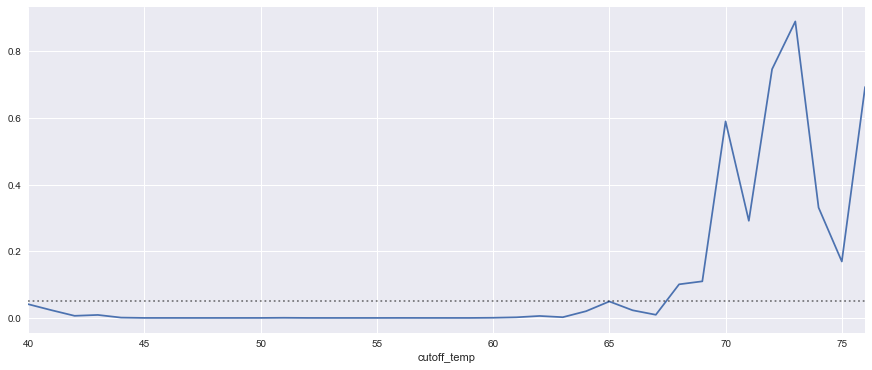

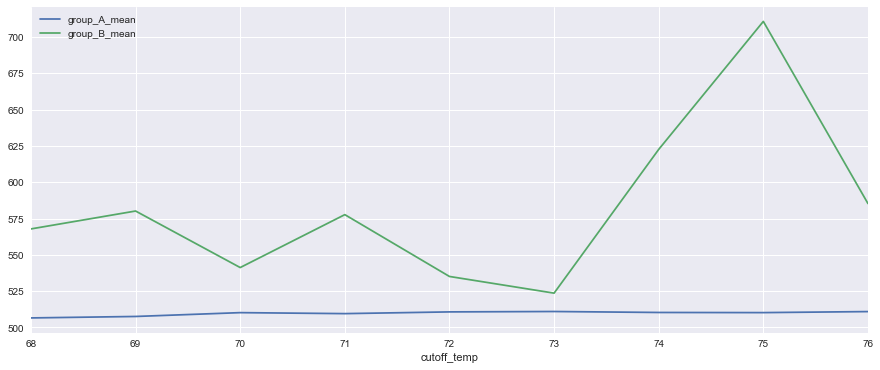

In [680]:
mean_temp_results_data = P_calc(commuter_data, variable='mean_temp')

ax = mean_temp_results_data['p_value'].plot(figsize=(15,6))
ax.axhline(y=0.05, color='k', linestyle=':', alpha=0.5)
plt.show()

ax = mean_temp_results_data[mean_temp_results_data.reject_null == False][['group_A_mean', 'group_B_mean']].plot(figsize=(15,6))
plt.show()

/Users/samgutentag/anaconda/envs/springboard/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/springboard/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


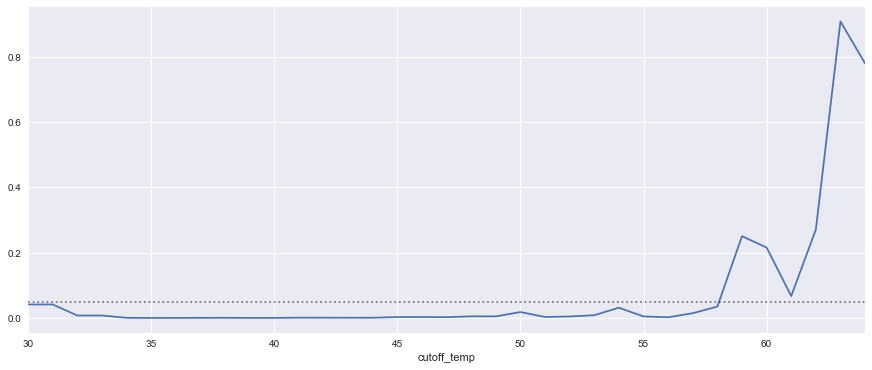

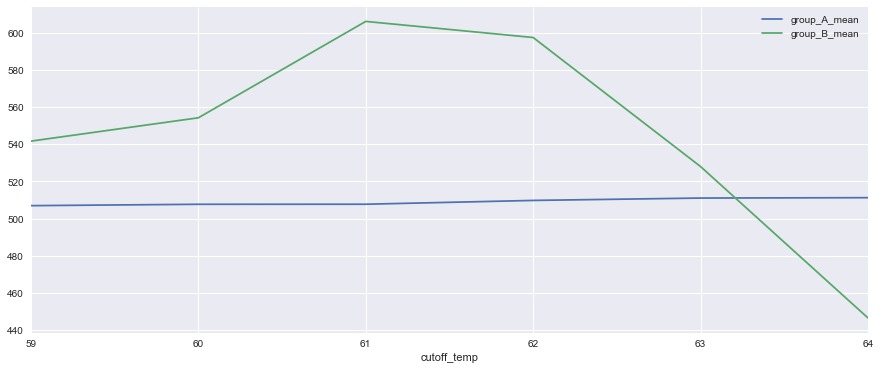

In [688]:
min_temp_results_data = P_calc(commuter_data, variable='min_temp')

ax = min_temp_results_data['p_value'].plot(figsize=(15,6))
ax.axhline(y=0.05, color='k', linestyle=':', alpha=0.5)
plt.show()

ax = min_temp_results_data[min_temp_results_data.reject_null == False][['group_A_mean', 'group_B_mean']].plot(figsize=(15,6))
plt.show()

/Users/samgutentag/anaconda/envs/springboard/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/springboard/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


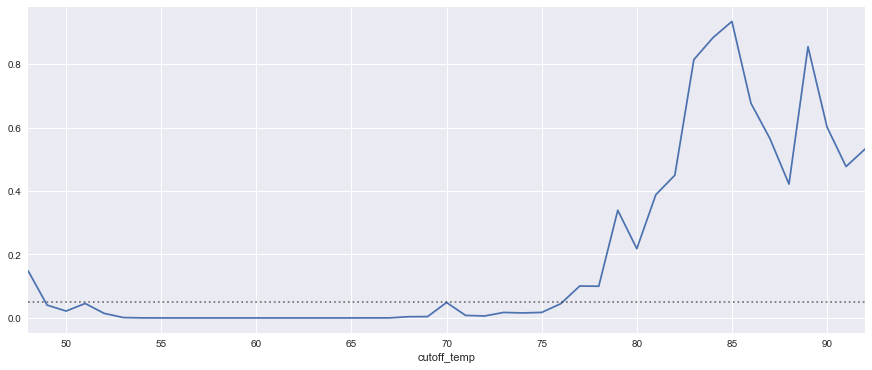

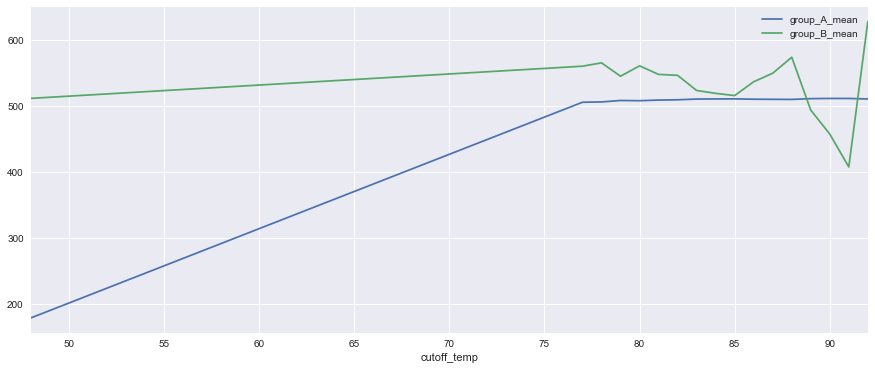

In [689]:
max_temp_results_data = P_calc(commuter_data, variable='max_temp')

ax = max_temp_results_data['p_value'].plot(figsize=(15,6))
ax.axhline(y=0.05, color='k', linestyle=':', alpha=0.5)
plt.show()

ax = max_temp_results_data[max_temp_results_data.reject_null == False][['group_A_mean', 'group_B_mean']].plot(figsize=(15,6))
plt.show()